<a href="https://colab.research.google.com/github/fatasfaps/duelingddqn-for-sepsis/blob/main/defining_sepsis_cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:32px; font-weight:600; margin-bottom:12px;">
  <b>SEPSIS-3 COHORT DEFINITION</b>
</h1>

<p style="font-size:14px; line-height:1.6;">
  This notebook defines the patient cohort used for downstream modeling,
  following the <b>Sepsis-3</b> clinical criteria.
  <br><br>
  The cohort construction is based on the methodology described in:
  <br>
  <a href="https://www.nature.com/articles/s41591-018-0213-5"
     target="_blank"
     style="color:#444; text-decoration:none;">
    Komorowski et al., Nature Medicine (2018)
  </a>
  and is adapted from the
  <a href="https://github.com/matthieukomorowski/AI_Clinician"
     target="_blank"
     style="color:#444; text-decoration:none;">
    AI-Clinician GitHub repository.</a>
</p>

<p style="font-size:14px; line-height:1.6;">
  Cohort inclusion is determined using the following logic:
</p>

<ul style="font-size:14px; line-height:1.6;">
  <li>
    <b>Suspected infection</b> is identified by the temporal co-occurrence
    of antibiotic administration and microbiological culture sampling.
  </li>
  <li>
    <b>Sepsis onset</b> is defined as the first time point at which suspected
    infection is accompanied by an increase in <b>SOFA score ≥ 2</b> from baseline.
  </li>
  <li>
    Only adult ICU stays are considered, and each patient contributes a single ICU admission.
  </li>
</ul>

<p style="font-size:14px; line-height:1.6;">
  The resulting cohort represents ICU patients meeting Sepsis-3 criteria
  and forms the basis for subsequent state space construction and MDP modeling.
</p>

<p style="font-size:13px; color:#555;">
  This notebook focuses on cohort definition only; feature extraction and model training
  are performed in subsequent stages of the pipeline.
</p>

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import time
import multiprocessing as mp
from tqdm import tqdm
from datetime import timedelta
import itertools
from itertools import tee
from multiprocessing import Pool, cpu_count
from sklearn.impute import KNNImputer
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/mimic3'

In [ ]:
start_time = time.time()

In [ ]:
# Import all data tables
abx = pd.read_csv('/content/drive/MyDrive/mimic3/abx.csv')
culture = pd.read_csv('/content/drive/MyDrive/mimic3/culture.csv')
microbio = pd.read_csv('/content/drive/MyDrive/mimic3/microbio.csv')
demog = pd.read_csv('/content/drive/MyDrive/mimic3/demog.csv')
all_vitals = pd.concat([
    pd.read_csv('/content/drive/MyDrive/mimic3/ce010.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce1020.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce2030.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce3040.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce4050.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce5060.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce6070.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce7080.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce8090.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/ce90100.csv'),
], ignore_index=True)
labU = pd.concat([
    pd.read_csv('/content/drive/MyDrive/mimic3/labs_ce.csv'),
    pd.read_csv('/content/drive/MyDrive/mimic3/labs_le.csv')
], ignore_index=True)
MechVent = pd.read_csv('/content/drive/MyDrive/mimic3/mechvent.csv')
inputpreadm = pd.read_csv('/content/drive/MyDrive/mimic3/preadm_fluid.csv')
inputMV = pd.read_csv('/content/drive/MyDrive/mimic3/fluid_mv.csv')
inputCV = pd.read_csv('/content/drive/MyDrive/mimic3/fluid_cv.csv')
vasoMV = pd.read_csv('/content/drive/MyDrive/mimic3/vaso_mv.csv')
vasoCV = pd.read_csv('/content/drive/MyDrive/mimic3/vaso_cv.csv')
UOpreadm = pd.read_csv('/content/drive/MyDrive/mimic3/preadm_uo.csv')
UO = pd.read_csv('/content/drive/MyDrive/mimic3/uo.csv')

print(f"Data imported in {time.time() - start_time:.1f} seconds")

Data imported in 37.9 seconds


In [ ]:
# Convert all time columns to datetime type (with unit='s')
demog['intime'] = pd.to_datetime(demog['intime'], unit='s', errors='coerce')
demog['outtime'] = pd.to_datetime(demog['outtime'], unit='s', errors='coerce')
demog['dod'] = pd.to_datetime(demog['dod'], unit='s', errors='coerce')
abx['startdate'] = pd.to_datetime(abx['startdate'], unit='s', errors='coerce')
abx['enddate'] = pd.to_datetime(abx['enddate'], unit='s', errors='coerce')
microbio['charttime'] = pd.to_datetime(microbio['charttime'], unit='s', errors='coerce')
culture['charttime'] = pd.to_datetime(culture['charttime'], unit='s', errors='coerce')
labU['charttime'] = pd.to_datetime(labU['charttime'], unit='s', errors='coerce')
MechVent['charttime'] = pd.to_datetime(MechVent['charttime'], unit='s', errors='coerce')
all_vitals['charttime'] = pd.to_datetime(all_vitals['charttime'], unit='s', errors='coerce')
inputMV['starttime'] = pd.to_datetime(inputMV['starttime'], unit='s', errors='coerce')
inputCV['charttime'] = pd.to_datetime(inputCV['charttime'], unit='s', errors='coerce')
vasoMV['starttime'] = pd.to_datetime(vasoMV['starttime'], unit='s', errors='coerce')
vasoCV['charttime'] = pd.to_datetime(vasoCV['charttime'], unit='s', errors='coerce')
UO['charttime'] = pd.to_datetime(UO['charttime'], unit='s', errors='coerce')

print(f"Conversion to datetime has finished in {time.time() - start_time:.1f} seconds.")

Conversion to datetime has finished in 62.0 seconds.


In [ ]:
# Merge microbio and culture into bacterio
bacterio = pd.concat([microbio, culture], ignore_index=True)

# Handle missing icustay_id in bacterio
bacterio_missing_icustay = bacterio[bacterio['icustay_id'].isnull()].copy()
bacterio_has_icustay = bacterio[bacterio['icustay_id'].notnull()].copy()

# Merge missing data with demog for finding the matches
bacterio_missing_icustay = pd.merge(bacterio_missing_icustay.drop(columns='icustay_id'),
                                     demog[['subject_id', 'hadm_id', 'icustay_id', 'intime', 'outtime']],
                                     on=['subject_id', 'hadm_id'], how='left')

# Implementing Komorowski's (2018)
# 1. If charttime falls within the ICU intime and outtime range (+/- 48 hours)
valid_match = (bacterio_missing_icustay['charttime'] >= bacterio_missing_icustay['intime'] - pd.Timedelta(hours=48)) & \
              (bacterio_missing_icustay['charttime'] <= bacterio_missing_icustay['outtime'] + pd.Timedelta(hours=48))

bacterio_missing_icustay.loc[valid_match, 'filled_icustay_id'] = bacterio_missing_icustay.loc[valid_match, 'icustay_id']

# 2. If there is only one hadm_id for the matching subject_id, assign that icustay_id
grouped_by_hadm = bacterio_missing_icustay.groupby('hadm_id')['icustay_id'].nunique()
single_match_hadm = grouped_by_hadm[grouped_by_hadm == 1].index
bacterio_missing_icustay.loc[bacterio_missing_icustay['hadm_id'].isin(single_match_hadm), 'filled_icustay_id'] = bacterio_missing_icustay.loc[bacterio_missing_icustay['hadm_id'].isin(single_match_hadm), 'icustay_id']

# Merge back the filled and complete data
bacterio_missing_icustay['icustay_id'] = bacterio_missing_icustay['filled_icustay_id']
bacterio = pd.concat([bacterio_has_icustay, bacterio_missing_icustay.drop(columns=['intime', 'outtime', 'filled_icustay_id'])], ignore_index=True)


# Handle missing icustay_id in abx
abx_missing_icustay = abx[abx['icustay_id'].isnull()].copy()
abx_has_icustay = abx[abx['icustay_id'].notnull()].copy()

abx_missing_icustay = pd.merge(abx_missing_icustay.drop(columns='icustay_id'),
                                demog[['hadm_id', 'icustay_id', 'intime', 'outtime']],
                                on='hadm_id', how='left')

# Use 'startdate'
valid_match_abx = (abx_missing_icustay['startdate'] >= abx_missing_icustay['intime'] - pd.Timedelta(hours=48)) & \
                  (abx_missing_icustay['startdate'] <= abx_missing_icustay['outtime'] + pd.Timedelta(hours=48))

abx_missing_icustay.loc[valid_match_abx, 'filled_icustay_id'] = abx_missing_icustay.loc[valid_match_abx, 'icustay_id']

grouped_by_hadm_abx = abx_missing_icustay.groupby('hadm_id')['icustay_id'].nunique()
single_match_hadm_abx = grouped_by_hadm_abx[grouped_by_hadm_abx == 1].index
abx_missing_icustay.loc[abx_missing_icustay['hadm_id'].isin(single_match_hadm_abx), 'filled_icustay_id'] = abx_missing_icustay.loc[abx_missing_icustay['hadm_id'].isin(single_match_hadm_abx), 'icustay_id']

abx_missing_icustay['icustay_id'] = abx_missing_icustay['filled_icustay_id']
abx = pd.concat([abx_has_icustay, abx_missing_icustay.drop(columns=['intime', 'outtime', 'filled_icustay_id'])], ignore_index=True)

print(f"Missing icustay_ids have been founded in {time.time() - start_time:.1f} seconds.")

Missing icustay_ids have been founded in 68.2 seconds.


In [ ]:
# Function to find the onset time of Sepsis
def find_onset_for_patient(icustayid, abx_data, bacterio_data):
    """
    Processes a single icustay_id to find the onset_time
    Args:
          icustayid_chunk (list): List of icustay_ids to be processed
          abx_data (pd.DataFrame): Global ABx DataFrame
          bacterio_data (pd.DataFrame): Global Bacterio DataFrame
      Returns:
          list: List of onset_time results
    """
    # Filter ABx and Bacterio data for the current patient
    ab_patient = abx_data[abx_data['icustay_id'] == icustayid].copy()
    bact_patient = bacterio_data[bacterio_data['icustay_id'] == icustayid].copy()

    # If either table has no data, return None
    if ab_patient.empty or bact_patient.empty:
        return None

    # Perform merge only for this patient’s data
    patient_events = pd.merge(ab_patient, bact_patient, on='icustay_id', suffixes=('_abx', '_bact'))

    # Compute time differences
    patient_events['diff_time'] = (patient_events['startdate'] - patient_events['charttime']).dt.total_seconds() / 3600

    # Sort by absolute time differences
    patient_events['abs_diff'] = patient_events['diff_time'].abs()
    patient_events = patient_events.sort_values(by='abs_diff')

    for _, row in patient_events.iterrows():
        # Rule 1: Antibiotics (ABx) given first
        if row['diff_time'] <= 0 and row['abs_diff'] <= 24:
            return {'icustay_id': icustayid, 'onset_time': row['startdate']}
        # Rule 2: Culture taken first
        elif row['diff_time'] > 0 and row['diff_time'] <= 72:
            return {'icustay_id': icustayid, 'onset_time': row['charttime']}

    return None

# Wrapper function to process one patient and update progress
def process_and_update(icustayid, abx_data, bacterio_data, progress_counter):
    result = find_onset_for_patient(icustayid, abx_data, bacterio_data)
    progress_counter.value += 1
    return result

# --- Main Program ---
if __name__ == '__main__':
    start_time = time.time()

    # Remove rows with NaN values in primary keys before processing
    abx = abx.dropna(subset=['icustay_id', 'startdate']).copy()
    bacterio = bacterio.dropna(subset=['icustay_id', 'charttime']).copy()

    # Get unique list of icustay_id from both tables
    all_icustayids = pd.concat([abx['icustay_id'], bacterio['icustay_id']]).dropna().unique()

    print(f"Total unique icustay_ids to process: {len(all_icustayids)}")

    num_cores = mp.cpu_count()
    print(f"Using {num_cores} CPU cores for parallel processing.")

   # Use multiprocessing.Manager to create shareable objects
    with mp.Manager() as manager:
        progress_counter = manager.Value('i', 0) # 'i' for integer

        # Prepare arguments for each process; each task processes ONE icustay_id
        task_args = [(icustayid, abx, bacterio, progress_counter) for icustayid in all_icustayids]

        with mp.Pool(processes=num_cores) as pool:
            # Use starmap_async to run processes asynchronously
            result_async = pool.starmap_async(process_and_update, task_args)

            # Print progress periodically in the main process
            while not result_async.ready():
                time.sleep(5)  # Wait 5 seconds before checking again
                progress = progress_counter.value
                total = len(all_icustayids)
                percentage = (progress / total) * 100 if total > 0 else 0
                print(f"Processing... {progress}/{total} ({percentage:.1f}%)")

            # Retrieve results after all processes have completed
            results = result_async.get()

    final_results = [res for res in results if res is not None]

    onset = pd.DataFrame(final_results)

    if not onset.empty:
        onset['icustay_id'] = onset['icustay_id'].astype(int)
        onset['onset_time'] = pd.to_datetime(onset['onset_time'])
        onset = onset.drop_duplicates(subset=['icustay_id'], keep='first')

    # Print first 50 rows for verification
    print(f"\nNumber of records with onset_time found: {len(onset)}")
    print(f"Total time taken: {time.time() - start_time:.1f} seconds")
    print("\n--- Onset Time Findings (first 50) ---")
    print(onset[['icustay_id', 'onset_time']].head(50).to_markdown(index=False))

    # Saving results
    onset.to_csv('onset.csv', index=False)
    onset.to_csv(os.path.join(data_dir, 'onset.csv'), index=False)

Total unique icustay_ids to process: 52953
Using 8 CPU cores for parallel processing.
Processing... 2053/52953 (3.9%)
Processing... 6529/52953 (12.3%)
Processing... 11739/52953 (22.2%)
Processing... 17385/52953 (32.8%)
Processing... 22363/52953 (42.2%)
Processing... 29292/52953 (55.3%)
Processing... 36719/52953 (69.3%)
Processing... 37446/52953 (70.7%)

Number of records with onset_time found: 26299
Total time taken: 40.4 seconds

--- Onset Time Findings (first 50) ---
|   icustay_id | onset_time          |
|-------------:|:--------------------|
|       291788 | 2108-04-12 00:00:00 |
|       253656 | 2162-05-16 21:10:00 |
|       214619 | 2177-09-04 16:15:00 |
|       239289 | 2177-03-15 00:00:00 |
|       217590 | 2188-05-27 22:59:00 |
|       252772 | 2109-08-22 00:00:00 |
|       201668 | 2170-09-19 17:47:00 |
|       222038 | 2185-04-17 12:15:00 |
|       210325 | 2140-11-16 00:00:00 |
|       200853 | 2194-07-06 00:00:00 |
|       214267 | 2164-04-23 00:00:00 |
|       245719 | 21

In [ ]:
# ----------------------------------------------------------------------
## 1. COMBINE BASE DATA
# ----------------------------------------------------------------------
# Use 'demog' and 'onset' from previous cells
combined_df = pd.merge(onset, demog, on=['icustay_id'], how='left')
combined_df['onset_time'] = pd.to_datetime(combined_df['onset_time'])
combined_df = combined_df[['icustay_id', 'onset_time',
                           'gender', 'age', 'elixhauser', 'morta_hosp', 'morta_90', 'los']]
print(f"[DEBUG] Patients in combined_df (based on onset valid): {combined_df['icustay_id'].nunique()}")
# combined_filter_cols (pasien 20.115)
combined_filter_cols = combined_df[['icustay_id', 'onset_time']].copy()

# ----------------------------------------------------------------------
## 2. FILTER AND MERGE DATA
# ----------------------------------------------------------------------
print("Filtering and merging data...")

# Take icustay_id and onset_time for time-series filtering
combined_filter_cols = combined_df[['icustay_id', 'onset_time']].copy()

# Filter large tables first using inner merge
vitals_filtered = pd.merge(all_vitals, combined_filter_cols, on='icustay_id', how='inner')
lab_filtered = pd.merge(labU, combined_filter_cols, on='icustay_id', how='inner')

# Drop all_vitals and labU, which are large, since they’ve already been filtered
del all_vitals, labU
gc.collect()

# Standardize column names of value columns before concatenation
if 'value' in lab_filtered.columns:
    lab_filtered = lab_filtered.rename(columns={'value': 'valuenum'})
elif 'valuenum' not in lab_filtered.columns:
    print("WARNING: Laboratory value column not found (neither 'value' nor 'valuenum').")

# Now, merge the filtered data
all_data_filtered = pd.concat([vitals_filtered, lab_filtered], ignore_index=True)

# Delete intermediate DataFrames
del vitals_filtered, lab_filtered
gc.collect()

# Perform time-based filtering and deduplication on the smaller dataset
all_data_filtered['charttime'] = pd.to_datetime(all_data_filtered['charttime'])
all_data_filtered = all_data_filtered.drop_duplicates(subset=['icustay_id', 'charttime', 'itemid'], keep='first')
all_data_filtered['time_diff_hours'] = (all_data_filtered['charttime'] - all_data_filtered['onset_time']).dt.total_seconds() / 3600

# Create the final fully filtered DataFrame for 80 hrs
filtered_df = all_data_filtered[(all_data_filtered['time_diff_hours'] >= -48) & (all_data_filtered['time_diff_hours'] <= 60)].copy()

# Delete intermediate DataFrames
del all_data_filtered
gc.collect()

# ----------------------------------------------------------------------
## 3. MAPPING AND RESHAPING
# ----------------------------------------------------------------------
# Utilize BigQuery and MIMIC-3 Demo Ver. to check itemid labels
column_name_map = {
    # 1. Demographics and Scales
    580: 'Weight_kg', 581: 'Weight_kg', 224639: 'Weight_kg', 226512: 'Weight_kg',
    226707: 'Height_cm', 226730: 'Height_cm',
    228096: 'RASS',

    # 2. Vital Signs
    211: 'HR', 220045: 'HR',
    6: 'SysBP', 51: 'SysBP', 455: 'SysBP', 220179: 'SysBP', 225309: 'SysBP', 6701: 'SysBP', 224167: 'SysBP', 227243: 'SysBP',
    52: 'MeanBP', 443: 'MeanBP', 456: 'MeanBP', 6702: 'MeanBP', 220052: 'MeanBP', 220181: 'MeanBP', 224322: 'MeanBP', 225312: 'MeanBP',
    8368: 'DiaBP', 8440: 'DiaBP', 8441: 'DiaBP', 8555: 'DiaBP', 225310: 'DiaBP',
    615: 'RR', 618: 'RR', 3337: 'RR', 3603: 'RR', 220210: 'RR', 224422: 'RR',
    678: 'Temp_C', 3655: 'Temp_C', 223761: 'Temp_C', 223762: 'Temp_C',
    646: 'SpO2', 220228: 'SpO2', 220277: 'SpO2', 834: 'SpO2',
    190: 'FiO2', 3420: 'FiO2', 223835: 'FiO2', 727: 'FiO2',
    535: 'Peak_Ins_Pressure', 224695: 'Peak_Ins_Pressure',
    543: 'Plateau_Pressure', 224696: 'Plateau_Pressure',
    444: 'Mean_Airway_Pressure', 224697: 'Mean_Airway_Pressure',
    445: 'Minute_Volume', 448: 'Minute_Volume', 450: 'Minute_Volume', 224687: 'Minute_Volume',
    654: 'Tidal_Volume', 681: 'Tidal_Volume', 684: 'Tidal_Volume', 96: 'Tidal_Volume', 97: 'Tidal_Volume', 98: 'Tidal_Volume', 2566: 'Tidal_Volume', 3050: 'Tidal_Volume', 3083: 'Tidal_Volume', 224421: 'Tidal_Volume', 224684: 'Tidal_Volume', 224686: 'Tidal_Volume',
    113: 'CVP', 220074: 'CVP',
    116: 'Cardiac_Index', 228177: 'Cardiac_Index', 228368: 'Cardiac_Index', 1366: 'Cardiac_Index', 1372: 'Cardiac_Index',
    491: 'PAP', 492: 'PAP', 8448: 'PAP',

    # 3. Lab Values
    829: 'Potassium', 1535: 'Potassium', 3725: 'Potassium', 3792: 'Potassium', 4194: 'Potassium', 227442: 'Potassium', 227464: 'Potassium', 50971: 'Potassium', 50822: 'Potassium',
    837: 'Sodium', 1536: 'Sodium', 3726: 'Sodium', 3803: 'Sodium', 4195: 'Sodium', 220645: 'Sodium', 226534: 'Sodium', 50983: 'Sodium', 50824: 'Sodium',
    788: 'Chloride', 1523: 'Chloride', 3724: 'Chloride', 3747: 'Chloride', 4193: 'Chloride', 220602: 'Chloride', 226536: 'Chloride', 50902: 'Chloride', 50806: 'Chloride',
    807: 'Glucose', 811: 'Glucose', 1529: 'Glucose', 3744: 'Glucose', 220621: 'Glucose', 225664: 'Glucose', 226537: 'Glucose', 50931: 'Glucose', 50809: 'Glucose',
    821: 'Magnesium', 1532: 'Magnesium', 220635: 'Magnesium', 50960: 'Magnesium',
    786: 'Calcium', 1522: 'Calcium', 112: 'Calcium', 3746: 'Calcium', 3766: 'Calcium', 225625: 'Calcium', 50808: 'Calcium', 50893: 'Calcium',
    816: 'Ionized Calcium', 225667: 'Ionized Calcium',
    814: 'Hb', 220228: 'Hb', 51222: 'Hb', 50811: 'Hb',
    1127: 'WBC_Count', 1542: 'WBC_Count', 3834: 'WBC_Count', 4200: 'WBC_Count', 220546: 'WBC_Count', 51301: 'WBC_Count', 51300: 'WBC_Count',
    828: 'Platelets_count', 3789: 'Platelets_count', 227457: 'Platelets_count', 51265: 'Platelets_count',
    825: 'PTT', 1533: 'PTT', 3796: 'PTT', 227466: 'PTT', 51275: 'PTT',
    824: 'PT', 1286: 'PT', 51274: 'PT',
    780: 'Arterial_pH', 1126: 'Arterial_pH', 132: 'Arterial_pH', 139: 'Arterial_pH', 3839: 'Arterial_pH', 4753: 'Arterial_pH', 50820: 'Arterial_pH',
    490: 'paO2', 3785: 'paO2', 3837: 'paO2', 3838: 'paO2', 50821: 'paO2', 779: 'paO2',
    3784: 'paCO2', 3835: 'paCO2', 3836: 'paCO2', 778: 'paCO2',
    74: 'Arterial_BE', 776: 'Arterial_BE', 108: 'Arterial_BE', 110: 'Arterial_BE', 136: 'Arterial_BE', 3736: 'Arterial_BE', 3740: 'Arterial_BE', 4196: 'Arterial_BE', 224828: 'Arterial_BE', 50802: 'Arterial_BE',
    51: 'HCO3', 777: 'HCO3', 787: 'HCO3', 227443: 'HCO3', 50803: 'HCO3', 50804: 'HCO3',
    86: 'Lactate', 1531: 'Lactate', 225668: 'Lactate', 50813: 'Lactate', 50882: 'Lactate',
    781: 'BUN', 1162: 'BUN', 3737: 'BUN', 225624: 'BUN',
    791: 'Creatinine', 1525: 'Creatinine', 114: 'Creatinine', 3750: 'Creatinine', 220615: 'Creatinine', 50912: 'Creatinine', 51081: 'Creatinine',
    769: 'SGPT(ALT)', 3802: 'SGPT(ALT)', 50861: 'SGPT(ALT)',
    770: 'SGOT(AST)', 3801: 'SGOT(AST)', 50878: 'SGOT(AST)',
    848: 'Total_bili', 1538: 'Total_bili', 225690: 'Total_bili', 51464: 'Total_bili',
    815: 'INR', 1530: 'INR', 227467: 'INR', 51237: 'INR',
    813: 'HCT', 115: 'HCT', 3761: 'HCT', 220545: 'HCT', 226540: 'HCT', 51221: 'HCT', 50810: 'HCT',
    803: 'Direct_Bili', 1527: 'Direct_Bili', 225651: 'Direct_Bili', 50883: 'Direct_Bili',
    772: 'Albumin', 1521: 'Albumin', 107: 'Albumin', 3727: 'Albumin', 227456: 'Albumin', 50862: 'Albumin',
    851: 'Troponin', 227429: 'Troponin', 51003: 'Troponin', 51002: 'Troponin',

    # 4. Oxygenation
    823: 'Mixed_Venous_O2', 227686: 'Mixed_Venous_O2',

    # 5. Coagulation
    768: 'ACT', 1520: 'ACT', 1671: 'ACT', 220507: 'ACT',

    # 6. Others
    626: 'SVR',
    198: 'GCS',
    1817: 'ETCO2',
    470: 'O2_Flow_Main', 471: 'O2_Flow_Main', 223834: 'O2_Flow_Main',
    467: 'O2_Delivery_Device',
    227287: 'O2_Flow_Add',
    160: 'Ectopy_Frequency',
    849: 'Total_Protein', 1539: 'Total_Protein', 126: 'Total_Protein', 3807: 'Total_Protein', 50976: 'Total_Protein',
    227444: 'CRP', 50889: 'CRP',
    3799: 'RBC', 4197: 'RBC', 51279: 'RBC',
    224691: 'Flow_Rate'
}

# Create mapping dictionary with default itemid
itemid_map_with_default = {k: v for k, v in column_name_map.items()}
unique_itemids = filtered_df['itemid'].unique()
for itemid in unique_itemids:
    if itemid not in itemid_map_with_default:
        itemid_map_with_default[itemid] = f'ITEMID_{itemid}'

# Apply mapping to filtered_df
unique_itemids = filtered_df['itemid'].unique()
for itemid in unique_itemids:
    if itemid not in itemid_map_with_default:
        itemid_map_with_default[itemid] = f'ITEMID_{itemid}'
filtered_df['itemid_name'] = filtered_df['itemid'].map(itemid_map_with_default)

# Isolate the required time-series data columns
pivot_cols_base = ['icustay_id', 'charttime', 'onset_time', 'itemid_name', 'valuenum']

# Extract necessary columns from filtered_df for pivot operation
df_time_series_base = filtered_df[pivot_cols_base].copy()

# Delete unused filtered_df
del filtered_df
gc.collect()

# Merge static data into df_time_series_base
static_cols_needed = combined_df.copy()

# Merge all static columns + onset_time (which may be duplicated; handled below)
df_time_series_only = pd.merge(df_time_series_base, static_cols_needed, on='icustay_id', how='left', suffixes=('_base', '_static'))

# Handle duplicate 'onset_time' columns that may be created by Pandas
if 'onset_time_base' in df_time_series_only.columns and 'onset_time_static' in df_time_series_only.columns:
    # Remove onset_time from the static data, keep the one from time-series (already filtered in Part 2)
    df_time_series_only = df_time_series_only.drop(columns=['onset_time_static'])
    df_time_series_only = df_time_series_only.rename(columns={'onset_time_base': 'onset_time'})
elif 'onset_time_static' in df_time_series_only.columns:
    # If there are only suffixes, remove the suffixes
    df_time_series_only = df_time_series_only.rename(columns={'onset_time_static': 'onset_time'})

# Hapus kolom statis ganda lainnya yang mungkin tidak sengaja terbawa dengan suffix
cols_to_drop = [col for col in df_time_series_only.columns if col.endswith('_static')]
df_time_series_only = df_time_series_only.drop(columns=cols_to_drop, errors='ignore')

# Delete intermediate DataFrames
del df_time_series_base
gc.collect()

# Perform pivot table operation (ONLY on data containing time-series)
reformat_valid = pd.pivot_table(
    df_time_series_only,
    index=['icustay_id', 'onset_time', 'charttime',
           'gender', 'age', 'elixhauser', 'morta_hosp', 'morta_90', 'los'],
    columns='itemid_name',
    values='valuenum',
    aggfunc='mean'
).reset_index()

# Delete intermediate DataFrames
del df_time_series_only
gc.collect()

# Identify missing patients
all_patient_ids = combined_df['icustay_id'].unique()
existing_ids = reformat_valid['icustay_id'].unique()
missing_ids = np.setdiff1d(all_patient_ids, existing_ids)
print(f"[DEBUG] Missing patients (static data only): {len(missing_ids)}")

# Create a DataFrame for missing patients (Static Data Only)
missing_patients_df = combined_df[combined_df['icustay_id'].isin(missing_ids)].copy()

# Generate dummy rows with the same columns as reformat_valid, but all time-series features as NaN
# Retrieve the list of time-series columns from reformat_valid
time_series_cols = [col for col in reformat_valid.columns if col not in combined_df.columns]

# Add time-series columns with NaN values
for col in time_series_cols:
    missing_patients_df[col] = np.nan

# Ensure missing_patients_df has charttime = NaT (for consistency)
missing_patients_df['charttime'] = pd.NaT
missing_patients_df = missing_patients_df[reformat_valid.columns]
# Combine all data back together
reformat = pd.concat([reformat_valid, missing_patients_df], ignore_index=True)

# Delete intermediate DataFrames
del reformat_valid, missing_patients_df
gc.collect()

# Saving results
reformat.to_csv(os.path.join(data_dir, 'reformat_pivot.csv'), index=False)
print(f"DataFrame 'reformat_pivot.csv' has been made in {time.time() - start_time:.1f} seconds.")
print(f"Total unique icustay_ids: {reformat['icustay_id'].nunique()}")

# Delete all large variables
del itemid_map_with_default, unique_itemids, column_name_map
gc.collect()

[DEBUG] Patients in combined_df (based on onset valid): 26299
Filtering and merging data...
[DEBUG] Missing patients (static data only): 16425
DataFrame 'reformat_pivot.csv' has been made in 108.8 seconds.
Total unique icustay_ids: 26299


0

In [ ]:
# ----------------------------------------------------------------------
## P95 CAPPING FUNCTION
# ----------------------------------------------------------------------

def cap_p95_upper(df, col_names):
    """
    Applies P95 upper limit capping to specified columns.
    Values > P95 are replaced by the P95 value.
    """
    print(f"Applying P95 upper capping to: {col_names}")

    for col in col_names:
        if col in df.columns:
            # Calculate value P95
            p95_value = df[col].quantile(0.95)

            # Apply capping
            df.loc[df[col] > p95_value, col] = p95_value

            print(f"  - {col}: Max value capped at {p95_value:.2f}")

    return df

features_to_cap = ['SGOT(AST)', 'SGPT(ALT)', 'BUN']

# ----------------------------------------------------------------------
## OUTLIER CLEANING
# ----------------------------------------------------------------------
# --- Main Program ---
def delout(df, col_name, threshold, direction):
    """
    Replace values outside the threshold with NaN.
    The 'direction' parameter can be either 'above' or 'below'.
    """
    if col_name not in df.columns:
        return df

    if direction == 'above':
        df.loc[df[col_name] > threshold, col_name] = np.nan
    elif direction == 'below':
        df.loc[df[col_name] < threshold, col_name] = np.nan

    return df

# Clinical Outlier Rules (Komorowski (2018) & MIMIC-Extract)
outlier_rules_revised = {
    # 1. Demographics and Scales
    'Weight_kg': [(0, 'below'), (250, 'above')],
    'Height_cm': [(0, 'below'), (240, 'above')],
    'GCS': [(3, 'below'), (15, 'above')],

    # 2. Vital Signs
    'HR': [(20, 'below'), (350, 'above')],
    'SysBP': [(10, 'below'), (375, 'above')],
    'DiaBP': [(10, 'below'), (375, 'above')],
    'MeanBP': [(14, 'below'), (330, 'above')],
    'RR': [(5, 'below'), (100, 'above')],
    'SpO2': [(70, 'below'), (100, 'above')],
    'Temp_C': [(26, 'below'), (45, 'above')],
    'CVP': [(-10, 'below'), (50, 'above')],

    # 3. Lab Values
    'PEEP_Set': [(0, 'below'), (25, 'above')],
    'paO2': [(32, 'below'), (700, 'above')],
    'paCO2': [(10, 'below'), (200, 'above')],
    'Arterial_pH': [(6.3, 'below'), (8.4, 'above')],
    'Lactate': [(0.4, 'below'), (100, 'above')],
    'Arterial_BE': [(-50, 'below'), (50, 'above')],
    'Tidal_Volume': [(50, 'below'), (1800, 'above')],
    'Minute_Volume': [(0.1, 'below'), (50, 'above')],
    'Flow_Rate': [(0, 'below'), (70, 'above')],

    # b. Metabolic
    'Potassium': [(2, 'below'), (12, 'above')],
    'Sodium': [(50, 'below'), (225, 'above')],
    'Chloride': [(50, 'below'), (175, 'above')],
    'Glucose': [(33, 'below'), (2000, 'above')],
    'Creatinine': [(0.1, 'below'), (60, 'above')],
    'Magnesium': [(0, 'below'), (20, 'above')],
    'Calcium': [(0, 'below'), (20, 'above')],
    'Ionized Calcium': [(0, 'below'), (5, 'above')],
    'BUN': [(0, 'below'), (150, 'above')],
    'HCO3': [(0, 'below'), (50, 'above')],

    # c. Liver function
    'SGOT(AST)': [(6, 'below'), (200, 'above')],
    'SGPT(ALT)': [(2, 'below'), (150, 'above')],
    'PT': [(9.9, 'below'), (97.1, 'above')],
    'INR': [(0.8, 'below'), (15, 'above')],
    'PTT': [(10, 'below'), (150, 'above')],

    # d. Hematology
    'Hb': [(2, 'below'), (25, 'above')],
    'HCT': [(5, 'below'), (75, 'above')],
    'WBC_Count': [(0, 'below'), (1000, 'above')],
    'Platelets_count': [(10, 'below'), (2000, 'above')],

    # 6. Fluid Balance
    'input_total': [(0, 'below'), (300000, 'above')],
    'uo_total': [(0, 'below'), (300000, 'above')],
    'cumulated_balance': [(-100000, 'below'), (300000, 'above')]
}


# IQR Function
def iqr_outlier_removal_robust(df, factor=3.0):
    """Replace statistical outliers (IQR 3.0) with NaN and ensure non-negative values."""

    cols_to_exclude = ['icustay_id', 'charttime', 'onset_time', 'timestep_id', 'Total_bili', 'Direct_Bili',
                       'gender', 'age', 'elixhauser', 'morta_hosp', 'morta_90', 'los', 'Temp_F']

    NON_NEGATIVE_COLS = list(outlier_rules_revised.keys())

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Ensure icustay_id is never included in cols_to_clean
    cols_to_clean = [col for col in numeric_cols if col not in cols_to_exclude]

    for col in cols_to_clean:
        if df[col].isnull().all() or df[col].nunique() < 2: continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        if IQR > 0 and df[col].std() > 0.001:
            # 1. Apply Upper IQR Limit
            df.loc[df[col] > upper_bound, col] = np.nan
            # 2. Apply Lower IQR Limit (with non-negative protection/floor capping)
            current_lower_bound = lower_bound

            if col in NON_NEGATIVE_COLS and lower_bound < 0:
                current_lower_bound = 0
            df.loc[df[col] < current_lower_bound, col] = np.nan

    return df

# Outlier Cleaning Execution
available_features = reformat.columns.tolist()

print("Outlier cleaning starts...")

# 1. Create a Copy of the Data
reformat_cleaned = reformat.copy()

# 2. Standardize FiO2
if 'FiO2' in available_features:
    print("Standardizing FiO2 (converting % to fraction and capping)...")

    # a. Convert percentage values (>1.0 up to 100) into fractions
    mask_persen = (reformat_cleaned['FiO2'] > 1.0) & (reformat_cleaned['FiO2'] <= 100.0)
    reformat_cleaned.loc[mask_persen, 'FiO2'] /= 100

    # b. Cap maximum FiO2 at 1.0
    reformat_cleaned.loc[reformat_cleaned['FiO2'] > 1.0, 'FiO2'] = 1.0

    # c. Cap minimum FiO2 at 0.21
    reformat_cleaned.loc[reformat_cleaned['FiO2'] < 0.21, 'FiO2'] = 0.21


# 3. Iterate and Clean Outliers based on Clinical Rules (Hard Capping)
print("Applying improved clinical outlier rules (hard capping)...")
for col, rules in outlier_rules_revised.items():
    if col in available_features:
        for threshold, direction in rules:
            reformat_cleaned = delout(reformat_cleaned, col, threshold, direction)

# Apply P95 Capping
reformat_cleaned = cap_p95_upper(reformat_cleaned, features_to_cap)

# 4. Remove Statistical Outliers (IQR)
print("Applying IQR (factor 3.0) outlier removal and floor capping...")
reformat_cleaned = iqr_outlier_removal_robust(reformat_cleaned, factor=1.5)

# Saving results
try:
    final_unique_icustayids = reformat_cleaned['icustay_id'].nunique()
    reformat_cleaned.to_csv(os.path.join(data_dir, 'reformat_cleaned.csv'), index=False)

    try:
        time_elapsed = time.time() - start_time
        print(f"\nOutlier clearance complete. 'reformat_cleaned.csv' saved in {time_elapsed:.1f} seconds.")
    except NameError:
        print("\nOutlier clearance complete. 'reformat_cleaned.csv' saved.")

    print(f"Total unique icustay_ids: {final_unique_icustayids}")

except NameError:
    print("\nWarning: 'data_dir' or 'start_time' is not defined. Skipping time logging and saving.")

# Delete unused DataFrames
del outlier_rules_revised, available_features
gc.collect()

Outlier cleaning starts...
Standardizing FiO2 (converting % to fraction and capping)...
Applying improved clinical outlier rules (hard capping)...
Applying P95 upper capping to: ['SGOT(AST)', 'SGPT(ALT)', 'BUN']
  - SGOT(AST): Max value capped at 158.00
  - SGPT(ALT): Max value capped at 116.00
  - BUN: Max value capped at 88.00
Applying IQR (factor 3.0) outlier removal and floor capping...

Outlier clearance complete. 'reformat_cleaned.csv' saved in 145.7 seconds.
Total unique icustay_ids: 26299


0

In [ ]:
import pandas as pd
import numpy as np

# --- VERIFIKASI KONVERSI FiO2 ---
print("\n--- VERIFIKASI KONVERSI FiO2 SETELAH OUTLIER CLEANING ---")

# 1. Cek apakah kolom FiO2 ada
if 'FiO2' in reformat_cleaned.columns:

    # 2. Tampilkan statistik deskriptif untuk melihat range
    print("Statistik FiO2 (Harus antara 0.21 dan 1.0):")
    print(reformat_cleaned['FiO2'].describe())

    # 3. Cek secara eksplisit nilai minimum dan maksimum
    fio2_min = reformat_cleaned['FiO2'].min()
    fio2_max = reformat_cleaned['FiO2'].max()

    print(f"\nNilai Minimum FiO2: {fio2_min:.4f}")
    print(f"Nilai Maksimum FiO2: {fio2_max:.4f}")

    # 4. Beri konfirmasi berdasarkan batasan yang diterapkan (0.21 - 1.0)
    if fio2_min >= 0.21 and fio2_max <= 1.0:
        print("\n✅ Konversi FiO2 ke fraksi berhasil. Range data berada dalam batas 0.21 - 1.0.")
    elif fio2_min < 0.21:
        print(f"\n⚠️ Peringatan: Nilai FiO2 MINIMUM ({fio2_min:.4f}) berada di bawah 0.21. Ada masalah capping.")
    elif fio2_max > 1.0:
        print(f"\n⚠️ Peringatan: Nilai FiO2 MAKSIMUM ({fio2_max:.4f}) berada di atas 1.0. Ada masalah capping.")
    else:
        print("\nInformasi: Verifikasi FiO2 selesai.")

else:
    print("\nKolom 'FiO2' tidak ditemukan di DataFrame 'reformat_cleaned'.")


--- VERIFIKASI KONVERSI FiO2 SETELAH OUTLIER CLEANING ---
Statistik FiO2 (Harus antara 0.21 dan 1.0):
count    102525.00000
mean          0.45042
std           0.07126
min           0.25250
25%           0.40000
50%           0.40000
75%           0.50000
max           0.65000
Name: FiO2, dtype: float64

Nilai Minimum FiO2: 0.2525
Nilai Maksimum FiO2: 0.6500

✅ Konversi FiO2 ke fraksi berhasil. Range data berada dalam batas 0.21 - 1.0.


In [ ]:
# Global SAH Hold Limits "allegedly" used by Komorowski (2018) & Tu (2025)
# Create the SAH function accordingly
HOLD_LIMITS_SEC = {
    # 1. Demographics and Scales
    'GCS': 28 * 3600,             # From Table 3.1
    'Weight_kg': 28 * 3600,       # Taken from Weight (581) in Table 3.1
    'Height_cm': 28 * 3600,       # Considered constant, use 28 hours
    'RASS': 5 * 3600,             # RASS/Sedation changes frequently, use the second shortest limit (5 hours)

    # 2. Vital Signs (Usually 4 hours)
    'HR': 4 * 3600,               # From Table 3.1
    'RR': 4 * 3600,               # Resp Rate (RESP) in Table 3.1 is 4 hours
    'SysBP': 4 * 3600,            # SBP in Table 3.1 is 4 hours
    'DiaBP': 4 * 3600,            # DBP in Table 3.1 is 4 hours
    'MeanBP': 4 * 3600,           # MAP in Table 3.1 is 4 hours
    'SpO2': 4 * 3600,             # From Table 3.1
    'CVP': 4 * 3600,              # From Table 3.1
    'Temp_C': 28 * 3600,          # Temp (678) in Table 3.1 is 28 hours
    'FiO2': 28 * 3600,            # Taken from FiO2Set in Table 3.1
    'Peak_Ins_Pressure': 28 * 3600, # Taken from PIP in Table 3.1
    'Plateau_Pressure': 28 * 3600, # Taken from PlateauPres in Table 3.1
    'Mean_Airway_Pressure': 28 * 3600, # Assumed equivalent to PlateauPres (28 hours)
    'Minute_Volume': 28 * 3600,   # Not listed in table, use 28 hours (default)
    'Tidal_Volume': 28 * 3600,    # Taken from TidVolObs/Set/Spon in Table 3.1
    'PAP': 4 * 3600,              # PAPMean in Table 3.1 is 4 hours
    'Cardiac_Index': 10 * 3600,   # From Table 3.1 (10 hours)
    'SVR': 10 * 3600,             # From Table 3.1 (10 hours)

    # 3. a. Lab Values & Hematology (Generally 28 hours)
    'Potassium': 28 * 3600,       # From Table 3.1
    'Sodium': 28 * 3600,          # From Table 3.1
    'Chloride': 28 * 3600,        # From Table 3.1
    'Glucose': 28 * 3600,         # From Table 3.1
    'Magnesium': 28 * 3600,       # From Table 3.1
    'Calcium': 28 * 3600,         # From Table 3.1
    'Ionized Calcium': 28 * 3600, # From Table 3.1 (IonCa)
    'BUN': 28 * 3600,             # From Table 3.1
    'Creatinine': 28 * 3600,      # From Table 3.1
    'SGOT(AST)': 28 * 3600,       # AST in Table 3.1
    'SGPT(ALT)': 28 * 3600,       # ALT in Table 3.1
    'Total_bili': 28 * 3600,      # Total Bilirubin in Table 3.1
    'Direct_Bili': 28 * 3600,     # Direct Bilirubin in Table 3.1
    'Total_Protein': 28 * 3600,   # From Table 3.1
    'Albumin': 28 * 3600,         # From Table 3.1
    'Lactate': 28 * 3600,         # From Table 3.1
    'HCT': 28 * 3600,             # Hematocrit in Table 3.1
    'Hb': 28 * 3600,              # Hemoglobin in Table 3.1
    'WBC_Count': 28 * 3600,       # From Table 3.1
    'Platelets_count': 28 * 3600, # Platelets in Table 3.1
    'INR': 28 * 3600,             # From Table 3.1
    'PTT': 28 * 3600,             # From Table 3.1
    'PT': 28 * 3600,              # From Table 3.1
    'RBC': 28 * 3600,             # RBC Count in Table 3.1

    # 3. b. ABG (28 hours)
    'Arterial_pH': 28 * 3600,     # Art pH in Table 3.1
    'paCO2': 28 * 3600,           # Art PaCO2 in Table 3.1
    'paO2': 28 * 3600,            # Art PaO2 in Table 3.1
    'Arterial_BE': 28 * 3600,     # Art Base Excess in Table 3.1
    'HCO3': 28 * 3600,            # Art CO2 in Table 3.1

    # 6. Variables Not Found in Table 3.1 (Use 28 hours, except RASS/Flow)
    'Ionized Calcium': 28 * 3600,
    'Troponin': 28 * 3600,
    'Mixed_Venous_O2': 28 * 3600,
    'Ectopy_Frequency': 3 * 3600, # From Table 3.2 (3 hours)
    'ACT': 28 * 3600,
    'ETCO2': 28 * 3600,
    'O2_Flow_Main': 4 * 3600,     # Assumed same as HR/BP (4 hours)
    'O2_Flow_Add': 4 * 3600,      # Assumed same as HR/BP (4 hours)
    'Flow_Rate': 4 * 3600,        # Assumed same as HR/BP (4 hours)
    'CRP': 28 * 3600,
}

# Default limit for variables not listed
DEFAULT_HOLD_LIMIT = 28 * 3600

In [ ]:
# ----------------------------------------------------------------------
## IMPUTATION FROM EXISTING VALUE
# ----------------------------------------------------------------------
print("Data imputation from existing values starts...")
start_time = time.time()

# Create DataFrame copy to store imputation results
# Use 'reformat_cleaned' DataFrame in memory from previous cell run
temp_reformat_impute = reformat_cleaned.copy()
available_columns = temp_reformat_impute.columns

# Isolate Active and Static Patients
original_rows = len(temp_reformat_impute)
print(f"Original rows count: {original_rows}")

# 1. Identify Dummy Patients to be EXCLUDED from SAH/Relational Imputation
missing_patient_ids = temp_reformat_impute[temp_reformat_impute['charttime'].isnull()]['icustay_id'].unique()

# 2. Active Patients (Only those with non-NaN 'charttime') - These will be imputed
reformat_active = temp_reformat_impute.dropna(subset=['charttime']).copy()
print(f"Total rows for Imputation/SAH (Active Patients): {len(reformat_active)}")

# 3. Static Dummy Patients (No need for SAH/Relational Imputation)
# Take ONLY one row per icustay_id
reformat_static_dummy = temp_reformat_impute[temp_reformat_impute['icustay_id'].isin(missing_patient_ids)].drop_duplicates(subset=['icustay_id']).copy()
print(f"Total unique icustay_ids to SKIP SAH (Static Patients): {len(reformat_static_dummy['icustay_id'].unique())}")

# Delete unused temporary DataFrames
del temp_reformat_impute
gc.collect()

# Imputation for reformat_active
# 1. GCS imputation from RASS (map RASS value to GCS)
if 'GCS' in available_columns and 'RASS' in available_columns:
    print("Applying GCS Imputation from RASS...")
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] >= 0), 'GCS'] = 15
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] == -1), 'GCS'] = 14
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] == -2), 'GCS'] = 12
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] == -3), 'GCS'] = 11
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] == -4), 'GCS'] = 6
    reformat_active.loc[reformat_active['GCS'].isnull() & (reformat_active['RASS'] == -5), 'GCS'] = 3

# 2. FiO2 imputation and conversion (percentage vs fraction)
def harmonize_fio2(df):
    """
    Converts FiO2 values from percentage (21–100) to fraction (0.21–1.0)
    and applies minimum/maximum capping
    """
    if 'FiO2' in df.columns:
        # 1. CONVERSION: Divide values > 1.0 and <= 100 by 100
        mask_persen = (df['FiO2'] > 1.0) & (df['FiO2'] <= 100.0)
        df.loc[mask_persen, 'FiO2'] /= 100

        # 2. Cap maximum FiO2 at 1.0 (for cases > 1.0 that remain uncorrected)
        df.loc[df['FiO2'] > 1.0, 'FiO2'] = 1.0

        # 3. Cap minimum FiO2 at 0.21
        df.loc[df['FiO2'] < 0.21, 'FiO2'] = 0.21
    return df

# 3. Imputation of FiO2 from O2 Flow and Interface Type
if 'FiO2' in available_columns:
    print("Applying FiO2 Imputation from O2 Flow...")
    # Combine O2 Flow columns
    reformat_active['O2_Flow_Combined'] = reformat_active.get('Flow_Rate').fillna(
        reformat_active.get('O2_Flow_Main')).fillna(
        reformat_active.get('O2_Flow_Add'))

    # NO FiO2, YES O2 flow, no interface (0) OR cannula (2)
    if 'O2_Delivery_Device' in available_columns:
        mask = reformat_active['FiO2'].isnull() & reformat_active['O2_Flow_Combined'].notnull() & (reformat_active['O2_Delivery_Device'].isin([0, 2]))
        # Commands must be ordered from highest to lowest threshold
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 15), 'FiO2'] = 70
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 12), 'FiO2'] = 62
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 10), 'FiO2'] = 55
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 8), 'FiO2'] = 50
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 6), 'FiO2'] = 44
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 5), 'FiO2'] = 40
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 4), 'FiO2'] = 36
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 3), 'FiO2'] = 32
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 2), 'FiO2'] = 28
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 1), 'FiO2'] = 24

        # NO FiO2, YES O2 flow, face mask OR...
        mask = reformat_active['FiO2'].isnull() & reformat_active['O2_Flow_Combined'].notnull() & (reformat_active['O2_Delivery_Device'].isin([1, 3, 4, 5, 6, 9, 10]))
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 15), 'FiO2'] = 75
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 12), 'FiO2'] = 69
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 10), 'FiO2'] = 66
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 8), 'FiO2'] = 58
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 6), 'FiO2'] = 40
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 4), 'FiO2'] = 36

        # NO FiO2, YES O2 flow, Non rebreather mask
        mask = reformat_active['FiO2'].isnull() & reformat_active['O2_Flow_Combined'].notnull() & (reformat_active['O2_Delivery_Device'] == 7)
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] >= 15), 'FiO2'] = 100
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] >= 10), 'FiO2'] = 90
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] < 10), 'FiO2'] = 80
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 8), 'FiO2'] = 70
        reformat_active.loc[mask & (reformat_active['O2_Flow_Combined'] <= 6), 'FiO2'] = 60

        # NO FiO2, NO O2 flow
        # reformat_active.loc[reformat_active['FiO2'].isnull() & reformat_active['O2_Flow_Combined'].isnull(), 'FiO2'] = 21

    # Re-run FiO2 harmonization/capping
    reformat_active = harmonize_fio2(reformat_active)

    # Hapus kolom pembantu
    reformat_active.drop(columns=['O2_Flow_Combined'], inplace=True)

# 4. Imputation of BP (using 2 of 3 available values)
if all(col in available_columns for col in ['SysBP', 'MeanBP', 'DiaBP']):
    print("Applying BP Imputation (3-point method)...")
    reformat_active.loc[reformat_active['DiaBP'].isnull() & reformat_active['SysBP'].notnull() & reformat_active['MeanBP'].notnull(), 'DiaBP'] = (3 * reformat_active['MeanBP'] - reformat_active['SysBP']) / 2
    reformat_active.loc[reformat_active['MeanBP'].isnull() & reformat_active['SysBP'].notnull() & reformat_active['DiaBP'].notnull(), 'MeanBP'] = (reformat_active['SysBP'] + 2 * reformat_active['DiaBP']) / 3
    reformat_active.loc[reformat_active['SysBP'].isnull() & reformat_active['MeanBP'].notnull() & reformat_active['DiaBP'].notnull(), 'SysBP'] = 3 * reformat_active['MeanBP'] - 2 * reformat_active['DiaBP']

    for col in ['SysBP', 'MeanBP', 'DiaBP']:
        # Floor capping setelah kalkulasi
        reformat_active.loc[reformat_active[col] < 0, col] = 0

# 5. Imputation of Temp (Convert °C to °F and vice versa)
if 'Temp_C' in available_columns and 'Temp_F' in available_columns:
    print("Applying Temperature Conversion/Correction...")
    # a. Move Temp_C values that were recorded in Fahrenheit
    mask_c_is_f = (reformat_active['Temp_C'] > 45) & (reformat_active['Temp_C'] < 100) & reformat_active['Temp_F'].isnull()
    reformat_active.loc[mask_c_is_f, 'Temp_F'] = reformat_active['Temp_C']
    reformat_active.loc[mask_c_is_f, 'Temp_C'] = np.nan

    # b. Move Temp_F values that were recorded in Celsius
    mask_f_is_c = (reformat_active['Temp_F'] > 15) & (reformat_active['Temp_F'] < 45) & reformat_active['Temp_C'].isnull()
    reformat_active.loc[mask_f_is_c, 'Temp_C'] = reformat_active['Temp_F']
    reformat_active.loc[mask_f_is_c, 'Temp_F'] = np.nan

    # c. Temperature Conversion
    reformat_active.loc[reformat_active['Temp_F'].isnull() & reformat_active['Temp_C'].notnull(), 'Temp_F'] = reformat_active['Temp_C'] * 1.8 + 32
    reformat_active.loc[reformat_active['Temp_C'].isnull() & reformat_active['Temp_F'].notnull(), 'Temp_C'] = (reformat_active['Temp_F'] - 32) / 1.8

# 6. Imputation of Hb/HCT
if 'Hb' in available_columns and 'HCT' in available_columns:
    print("Applying Hb/HCT Imputation...")
    # Gunakan regresi empiris/klinis untuk mengimputasi
    reformat_active.loc[reformat_active['HCT'].isnull() & reformat_active['Hb'].notnull(), 'HCT'] = reformat_active['Hb'] * 2.862 + 1.216
    reformat_active.loc[reformat_active['Hb'].isnull() & reformat_active['HCT'].notnull(), 'Hb'] = (reformat_active['HCT'] - 1.216) / 2.862

    for col in ['Hb', 'HCT']:
        reformat_active.loc[reformat_active[col] < 0, col] = 0

# 7. Imputation of Bilirubin
# Lower threshold (mg/dL)
TOTAL_BILI_MIN_CAP = 0.2
DIRECT_BILI_MIN_CAP = 0.1

if 'Total_bili' in available_columns and 'Direct_Bili' in available_columns:
    print("Applying Bilirubin Imputation...")
    reformat_active.loc[reformat_active['Direct_Bili'].isnull() & reformat_active['Total_bili'].notnull(), 'Direct_Bili'] = reformat_active['Total_bili'] * 0.6934 - 0.1752
    reformat_active.loc[reformat_active['Total_bili'].isnull() & reformat_active['Direct_Bili'].notnull(), 'Total_bili'] = (reformat_active['Direct_Bili'] + 0.1752) / 0.6934

    for col in ['Total_bili', 'Direct_Bili']:
        # Convert negative values into lower threshold (0.2 / 0.1 mg/dL)
        if col == 'Total_bili':
            min_cap = TOTAL_BILI_MIN_CAP
        else:
            min_cap = DIRECT_BILI_MIN_CAP

        reformat_active.loc[reformat_active[col] < min_cap, col] = min_cap

        print(f"Minimum Capping for {col} applied at {min_cap} mg/dL (eliminates 0s and negatives).")

# Save the imputed 'reformat_active' to a CSV
reformat_active.to_csv(os.path.join(data_dir, 'reformat_imputed.csv'), index=False)
print(f"\nImputation from the existing value (Pasien Aktif only) has been done in {time.time() - start_time:.1f} seconds.")

# Delete unused DataFrames
del reformat_cleaned
gc.collect()

# ----------------------------------------------------------------------
## TIME-LIMITED SAMPLE AND HOLD (SAH) IMPUTATION
# ----------------------------------------------------------------------
# Apply Sample and Hold (SAH) imputation to all variables
print("\nRunning Time-Limited Sample and Hold (SAH) imputation on active patients...")
sah_start_time = time.time()

# Ensure the data is sorted by patient and time (use reformat_active)
reformat_active = reformat_active.sort_values(by=['icustay_id', 'charttime'])

# Set icustay_id and charttime as indices
reformat_imputed_temp = reformat_active.set_index(['icustay_id', 'charttime'])

# Initialize the output DataFrame
reformat_imputed_sah = reformat_imputed_temp.copy()

# Create charttime series for delta calculation
charttime_series = reformat_imputed_temp.index.get_level_values('charttime').to_series()
charttime_series.index = reformat_imputed_temp.index

# Apply Time-Limited SAH (ffill dan bfill) for each column
for col in reformat_imputed_temp.columns:
    # Process only columns that contain missing values
    if reformat_imputed_temp[col].isnull().any():

        # Use the given function: HOLD_LIMITS_SEC and DEFAULT_HOLD_LIMIT
        hold_limit = HOLD_LIMITS_SEC.get(col, DEFAULT_HOLD_LIMIT)

        # 1. Forward Fill (ffill) Time-Limited
        ffill_result = reformat_imputed_temp[col].groupby(level='icustay_id').ffill()
        last_valid_time = charttime_series.where(reformat_imputed_temp[col].notnull()).groupby(level='icustay_id').ffill()
        time_delta = (charttime_series - last_valid_time).dt.total_seconds()
        mask_time_limit_exceeded = time_delta > hold_limit

        reformat_imputed_sah[col] = ffill_result
        reformat_imputed_sah.loc[mask_time_limit_exceeded, col] = np.nan


        # 2. Backward Fill (bfill) Time-Limited
        bfill_result = reformat_imputed_temp[col].groupby(level='icustay_id').bfill()
        next_valid_time = charttime_series.where(reformat_imputed_temp[col].notnull()).groupby(level='icustay_id').bfill()
        time_delta_bfill = (next_valid_time - charttime_series).dt.total_seconds()
        mask_bfill_limit_exceeded = time_delta_bfill > hold_limit
        mask_is_nan_after_ffill = reformat_imputed_sah[col].isnull()

        bfill_valid = bfill_result.copy()
        bfill_valid.loc[mask_bfill_limit_exceeded] = np.nan

        # Merge bfill_valid results into columns that are still NaN after ffill
        reformat_imputed_sah[col].fillna(bfill_valid, inplace=True)


# Reset index for Active Patients after SAH
reformat_imputed_sah = reformat_imputed_sah.reset_index()

# Delete unused DataFrames
del reformat_imputed_temp, reformat_active
gc.collect()


# Final merge (Cohort reconciliation)
print("\nRecombining Active and Static Patients...")

time_series_cols_imputed = [col for col in reformat_imputed_sah.columns if col not in reformat_static_dummy.columns]

# Only add columns that are MISSING in dummy
for col in time_series_cols_imputed:
    if col not in reformat_static_dummy.columns:
        reformat_static_dummy[col] = np.nan

# Ensure the column order is consistent
reformat_static_dummy = reformat_static_dummy[reformat_imputed_sah.columns]

# Combine SAH results with Static Patients
reformat_imputed_final = pd.concat([reformat_imputed_sah, reformat_static_dummy], ignore_index=True)

# Save the final imputed DataFrame
reformat_imputed_final.to_csv(os.path.join(data_dir, 'reformat_imputed_final.csv'), index=False)
print(f"Final imputed data saved to 'reformat_imputed_final.csv' in {time.time() - sah_start_time:.1f} seconds.")
print(f"Total unique icustay_ids in final file: {reformat_imputed_final['icustay_id'].nunique()}")

# Delete unused DataFrames
del reformat_imputed_sah, reformat_static_dummy
gc.collect()

Data imputation from existing values starts...
Original rows count: 911266
Total rows for Imputation/SAH (Active Patients): 894841
Total unique icustay_ids to SKIP SAH (Static Patients): 16425
Applying GCS Imputation from RASS...
Applying FiO2 Imputation from O2 Flow...
Applying BP Imputation (3-point method)...
Applying Hb/HCT Imputation...
Applying Bilirubin Imputation...
Minimum Capping for Total_bili applied at 0.2 mg/dL (eliminates 0s and negatives).
Minimum Capping for Direct_Bili applied at 0.1 mg/dL (eliminates 0s and negatives).

Imputation from the existing value (Pasien Aktif only) has been done in 21.8 seconds.

Running Time-Limited Sample and Hold (SAH) imputation on active patients...

Recombining Active and Static Patients...
Final imputed data saved to 'reformat_imputed_final.csv' in 37.2 seconds.
Total unique icustay_ids in final file: 26299


0

In [ ]:
# --- VERIFIKASI FiO2 SETELAH IMPUTASI ---
print("\n--- VERIFIKASI FiO2 SETELAH IMPUTASI RELASIONAL DAN SAH ---")

# Ganti DataFrame yang dicek dari reformat_cleaned menjadi reformat_imputed_final
df_to_check = reformat_imputed_final

# 1. Cek apakah kolom FiO2 ada
if 'FiO2' in df_to_check.columns:

    # 2. Tampilkan statistik deskriptif untuk melihat range
    print("Statistik FiO2 (Harus antara 0.21 dan 1.0):")
    print(df_to_check['FiO2'].describe())

    # 3. Cek secara eksplisit nilai minimum dan maksimum
    fio2_min = df_to_check['FiO2'].min()
    fio2_max = df_to_check['FiO2'].max()

    # 4. Cek proporsi nilai yang masih missing (seharusnya berkurang drastis atau 0)
    missing_count = df_to_check['FiO2'].isnull().sum()
    total_count = len(df_to_check)

    print(f"\nNilai Minimum FiO2: {fio2_min:.4f}")
    print(f"Nilai Maksimum FiO2: {fio2_max:.4f}")
    print(f"Jumlah baris yang masih missing: {missing_count} ({(missing_count/total_count)*100:.2f}%)")

    # 5. Beri konfirmasi berdasarkan batasan (0.21 - 1.0)
    if fio2_min >= 0.21 and fio2_max <= 1.0:
        print("\n✅ Imputasi FiO2 berhasil. Range data berada dalam batas 0.21 - 1.0.")
    elif fio2_min < 0.21:
        print(f"\n⚠️ Peringatan: Nilai FiO2 MINIMUM ({fio2_min:.4f}) berada di bawah 0.21 setelah imputasi. Perlu pemeriksaan.")
    elif fio2_max > 1.0:
        print(f"\n⚠️ Peringatan: Nilai FiO2 MAKSIMUM ({fio2_max:.4f}) berada di atas 1.0 setelah imputasi. Perlu pemeriksaan.")
    else:
        print("\nInformasi: Verifikasi FiO2 selesai.")

else:
    print("\nKolom 'FiO2' tidak ditemukan di DataFrame 'reformat_imputed_final'.")


--- VERIFIKASI FiO2 SETELAH IMPUTASI RELASIONAL DAN SAH ---
Statistik FiO2 (Harus antara 0.21 dan 1.0):
count    714579.000000
mean          0.439893
std           0.099383
min           0.240000
25%           0.400000
50%           0.400000
75%           0.500000
max           0.750000
Name: FiO2, dtype: float64

Nilai Minimum FiO2: 0.2400
Nilai Maksimum FiO2: 0.7500
Jumlah baris yang masih missing: 196687 (21.58%)

✅ Imputasi FiO2 berhasil. Range data berada dalam batas 0.21 - 1.0.


In [ ]:
print(reformat_imputed_final.columns)

Index(['icustay_id', 'charttime', 'onset_time', 'gender', 'age', 'elixhauser',
       'morta_hosp', 'morta_90', 'los', 'ACT', 'Albumin', 'Arterial_BE',
       'Arterial_pH', 'BUN', 'CRP', 'CVP', 'Calcium', 'Cardiac_Index',
       'Chloride', 'Creatinine', 'DiaBP', 'Direct_Bili', 'Ectopy_Frequency',
       'FiO2', 'Flow_Rate', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'Hb',
       'Height_cm', 'INR', 'ITEMID_194', 'ITEMID_220339', 'ITEMID_224700',
       'ITEMID_505', 'ITEMID_506', 'Ionized Calcium', 'Lactate', 'Magnesium',
       'MeanBP', 'Mean_Airway_Pressure', 'Minute_Volume', 'Mixed_Venous_O2',
       'O2_Delivery_Device', 'O2_Flow_Add', 'O2_Flow_Main', 'PAP', 'PT', 'PTT',
       'Peak_Ins_Pressure', 'Plateau_Pressure', 'Platelets_count', 'Potassium',
       'RASS', 'RBC', 'RR', 'SGOT(AST)', 'SGPT(ALT)', 'SVR', 'Sodium', 'SpO2',
       'SysBP', 'Temp_C', 'Tidal_Volume', 'Total_Protein', 'Total_bili',
       'Troponin', 'WBC_Count', 'Weight_kg', 'paCO2', 'paO2'],
      dtype='object')


In [ ]:
# Asumsi: DataFrame hasil akhir imputasi adalah reformat_imputed_final
df_to_check = reformat_imputed_final
total_rows = len(df_to_check)

columns_to_verify = ['paCO2', 'paO2', 'SGOT(AST)', 'SGPT(ALT)', 'BUN']

print("\n--- VERIFIKASI STATISTIK KOLOM SETELAH IMPUTASI SAH ---")

for col in columns_to_verify:
    print(f"\n====================== {col} ======================")

    if col in df_to_check.columns:

        # Hitung missing values
        missing_count = df_to_check[col].isnull().sum()
        missing_percent = (missing_count / total_rows) * 100

        # Tampilkan statistik deskriptif
        print(f"Statistik Deskriptif {col}:")
        print(df_to_check[col].describe())

        # Tampilkan batas dan missing count
        col_min = df_to_check[col].min()
        col_max = df_to_check[col].max()

        print(f"\nNilai Minimum {col}: {col_min:.4f}")
        print(f"Nilai Maksimum {col}: {col_max:.4f}")
        print(f"Jumlah baris yang masih missing: {missing_count} ({missing_percent:.2f}%)")

        # Catatan: Kolom-kolom ini sudah melalui outlier cleaning dan SAH.
        # Jika nilai missing masih tinggi, itu normal karena SAH bersifat time-limited.
        if missing_percent > 10:
             print("⚠️ PERHATIAN: Proporsi missing value masih tinggi. Ini wajar setelah SAH time-limited.")
        else:
             print("✅ Imputasi dan SAH tampak berhasil dengan tingkat missing value yang rendah.")

    else:
        print(f"Kolom '{col}' tidak ditemukan di DataFrame.")


--- VERIFIKASI STATISTIK KOLOM SETELAH IMPUTASI SAH ---

====================== paCO2 ======================
Statistik Deskriptif paCO2:
count    323716.000000
mean         40.726292
std           8.947700
min          17.000000
25%          34.000000
50%          40.000000
75%          46.000000
max          65.000000
Name: paCO2, dtype: float64

Nilai Minimum paCO2: 17.0000
Nilai Maksimum paCO2: 65.0000
Jumlah baris yang masih missing: 587550 (64.48%)
⚠️ PERHATIAN: Proporsi missing value masih tinggi. Ini wajar setelah SAH time-limited.

====================== paO2 ======================
Statistik Deskriptif paO2:
count    325758.000000
mean        111.082958
std          38.935961
min          32.000000
25%          82.000000
50%         104.000000
75%         134.000000
max         228.000000
Name: paO2, dtype: float64

Nilai Minimum paO2: 32.0000
Nilai Maksimum paO2: 228.0000
Jumlah baris yang masih missing: 585508 (64.25%)
⚠️ PERHATIAN: Proporsi missing value masih tinggi. Ini w

In [ ]:
# Asumsi: DataFrame hasil akhir imputasi adalah reformat_imputed_final
df_to_check = reformat_imputed_final
total_rows = len(df_to_check)

columns_to_verify = ['Lactate']

print("\n--- VERIFIKASI STATISTIK KOLOM SETELAH IMPUTASI SAH ---")

for col in columns_to_verify:
    print(f"\n====================== {col} ======================")

    if col in df_to_check.columns:

        # Hitung missing values
        missing_count = df_to_check[col].isnull().sum()
        missing_percent = (missing_count / total_rows) * 100

        # Tampilkan statistik deskriptif
        print(f"Statistik Deskriptif {col}:")
        print(df_to_check[col].describe())

        # Tampilkan batas dan missing count
        col_min = df_to_check[col].min()
        col_max = df_to_check[col].max()

        print(f"\nNilai Minimum {col}: {col_min:.4f}")
        print(f"Nilai Maksimum {col}: {col_max:.4f}")
        print(f"Jumlah baris yang masih missing: {missing_count} ({missing_percent:.2f}%)")

        # Catatan: Kolom-kolom ini sudah melalui outlier cleaning dan SAH.
        # Jika nilai missing masih tinggi, itu normal karena SAH bersifat time-limited.
        if missing_percent > 10:
             print("⚠️ PERHATIAN: Proporsi missing value masih tinggi. Ini wajar setelah SAH time-limited.")
        else:
             print("✅ Imputasi dan SAH tampak berhasil dengan tingkat missing value yang rendah.")

    else:
        print(f"Kolom '{col}' tidak ditemukan di DataFrame.")


--- VERIFIKASI STATISTIK KOLOM SETELAH IMPUTASI SAH ---

====================== Lactate ======================
Statistik Deskriptif Lactate:
count    469752.000000
mean          2.006047
std           1.300260
min           0.400000
25%           1.100000
50%           1.600000
75%           2.400000
max           7.000000
Name: Lactate, dtype: float64

Nilai Minimum Lactate: 0.4000
Nilai Maksimum Lactate: 7.0000
Jumlah baris yang masih missing: 441514 (48.45%)
⚠️ PERHATIAN: Proporsi missing value masih tinggi. Ini wajar setelah SAH time-limited.


In [ ]:
# Check missingness in reformat_imputed_final
df = reformat_imputed_final.copy()

# Set display options so Pandas prints all rows and columns
# Setting to 'None' or a large number disables the display limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# --- Missingness Calculation Process ---

# 1. Count Missing Values per Column
missing_count = df.isnull().sum()

# 2. Count Total Rows
total_rows = len(df)

# 3. Calculate Missing Value Percentage per Column
missing_percent = (missing_count / total_rows) * 100

# 4. Create a Missingness Report DataFrame
missing_report = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent': missing_percent.round(2)
})

# Filter only columns that contain missing values
missing_report = missing_report[missing_report['Missing Count'] > 0].sort_values(
    by='Missing Percent', ascending=False
)

# Print the Report
print("=== Missingness Report (After Relational Imputation & SAH) ===")
# Since row limit has been disabled, the entire report will be printed
print(missing_report)

# After finishing, reset the display limits to default (usually 60)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


=== Missingness Report (After Relational Imputation & SAH) ===
                      Missing Count  Missing Percent
Flow_Rate                    910735            99.94
Ectopy_Frequency             910080            99.87
ITEMID_505                   909427            99.80
RBC                          909338            99.79
CRP                          905359            99.35
ITEMID_194                   901542            98.93
ACT                          901483            98.93
Total_Protein                900140            98.78
O2_Flow_Add                  888052            97.45
Temp_C                       875219            96.04
SVR                          860815            94.46
PAP                          860223            94.40
Cardiac_Index                853094            93.62
Mixed_Venous_O2              833438            91.46
Height_cm                    799264            87.71
ITEMID_224700                768466            84.33
Troponin                     759749 

In [ ]:
# --- DEFINE TIME WINDOW PARAMETERS ---
window_size_hours = 4
TOTAL_STEPS = 20
MIN_PRE_ONSET_HOURS = -24 # -24 jam (Inclusive)
MAX_POST_ONSET_HOURS = 56 # +56 jam (Exclusive)

# Offset calculation for Timestep IDs 1–20
TIMESTEP_OFFSET = abs(MIN_PRE_ONSET_HOURS) // window_size_hours
T0_BASELINE_STEP_ID = 1

# --------------------------------------------------------------------------------------
## DATA COMBINATION & ONSET PREPARATION
# --------------------------------------------------------------------------------------
print("Starting data combination and onset preparation...")

# 1. Combine Input Fluids (input_combined)
inputMV_renamed = inputMV.rename(columns={'amount': 'input_volume', 'starttime': 'charttime'}).copy()
inputCV_renamed = inputCV.rename(columns={'amount': 'input_volume'}).copy()
input_combined = pd.concat([
    inputMV_renamed[['icustay_id', 'charttime', 'input_volume']],
    inputCV_renamed[['icustay_id', 'charttime', 'input_volume']]
], ignore_index=True)
input_combined['input_volume'] = input_combined['input_volume'].fillna(0)
input_combined['charttime'] = pd.to_datetime(input_combined['charttime'], errors='coerce')

# 2. Combine Vasopressors (vaso_combined)
vasoMV_renamed = vasoMV.rename(columns={'starttime': 'charttime'}).copy()
vaso_combined = pd.concat([
    vasoMV_renamed[['icustay_id', 'charttime', 'rate_std']],
    vasoCV[['icustay_id', 'charttime', 'rate_std']]
], ignore_index=True)
vaso_combined['charttime'] = pd.to_datetime(vaso_combined['charttime'], errors='coerce')

# 3. Retrieve onset time (T=0)
onset_df = reformat_imputed_final[['icustay_id', 'onset_time']].drop_duplicates().copy()
onset_df['onset_time'] = pd.to_datetime(onset_df['onset_time'], errors='coerce')
onset_df.dropna(subset=['onset_time'], inplace=True)
onset_df['icustay_id'] = onset_df['icustay_id'].astype('int64')

gc.collect()

# --------------------------------------------------------------------------------------
## BINNING & AGREGATION FUNCTION (Fluid, UO, Vaso)
# --------------------------------------------------------------------------------------
def perform_binning_aggregation(data_df, value_col, agg_funcs, prefix):
    """Merge data with onset_time, perform binning, and aggregation."""
    if data_df.empty:
        return pd.DataFrame(columns=['icustay_id', 'window_label', f'{prefix}_{list(agg_funcs.keys())[0]}'], dtype=np.float64)

    # Merge with onset_time
    df_merged = pd.merge(data_df, onset_df, on='icustay_id', how='left')
    df_merged.dropna(subset=['charttime', 'onset_time'], inplace=True)

    # Calculate duration
    df_merged['duration_from_onset_hours'] = (
        df_merged['charttime'] - df_merged['onset_time']
    ).dt.total_seconds() / 3600

    # Filter duration
    df_binned = df_merged[
        (df_merged['duration_from_onset_hours'] >= MIN_PRE_ONSET_HOURS) &
        (df_merged['duration_from_onset_hours'] < MAX_POST_ONSET_HOURS)
    ].copy()

    if df_binned.empty:
         return pd.DataFrame(columns=['icustay_id', 'window_label', f'{prefix}_{list(agg_funcs.keys())[0]}'], dtype=np.float64)

    # Label time windows (window_label, can be negative)
    df_binned['window_label'] = np.floor(
        df_binned['duration_from_onset_hours'] / window_size_hours
    ).astype('int64') # Use standard int64

    # Perform aggregation
    agg_result = df_binned.groupby(
        ['icustay_id', 'window_label']
    ).agg(
        **{f'{prefix}_{func}': (value_col, func) for func in agg_funcs}
    ).reset_index()

    return agg_result

# --------------------------------------------------------------------------------------
## INTERVAL AGREGATION & FLUID/VASO MERGE
# --------------------------------------------------------------------------------------
bin_start_time = time.time()

input_4h = perform_binning_aggregation(input_combined, 'input_volume', {'sum': 'sum'}, 'input_step')
uo_4h = perform_binning_aggregation(UO, 'value', {'sum': 'sum'}, 'uo_step')
vaso_4h = perform_binning_aggregation(vaso_combined, 'rate_std', {'max': 'max', 'median': 'median'}, 'vaso_step')

# Merge Fluid/UO/Vaso Step Data
fluid_vaso_agg_final = pd.merge(input_4h, uo_4h, on=['icustay_id', 'window_label'], how='outer')
fluid_vaso_agg_final = pd.merge(fluid_vaso_agg_final, vaso_4h, on=['icustay_id', 'window_label'], how='outer')

print(f"Binning aggregation (Fluid/Vaso) complete in {time.time() - bin_start_time:.1f} seconds.")
gc.collect()

# --------------------------------------------------------------------------------------
## MERGING T0 (PRE-ADMISSION) AND PRE-ONSET
# --------------------------------------------------------------------------------------
cum_start_time = time.time()

# Merge Pre-adm
preadm_input = inputpreadm.groupby('icustay_id').agg(preadm_input=('inputpreadm', 'sum')).reset_index()
preadm_uo = UOpreadm.groupby('icustay_id').agg(preadm_uo=('value', 'sum')).reset_index()

fluid_vaso_agg_final = pd.merge(fluid_vaso_agg_final, preadm_input, on='icustay_id', how='left').fillna({'preadm_input': 0})
fluid_vaso_agg_final = pd.merge(fluid_vaso_agg_final, preadm_uo, on='icustay_id', how='left').fillna({'preadm_uo': 0})

# Impute NaN steps with 0 (representing zero input/output in that time window)
fluid_vaso_agg_final['input_step_sum'] = fluid_vaso_agg_final['input_step_sum'].fillna(0)
fluid_vaso_agg_final['uo_step_sum'] = fluid_vaso_agg_final['uo_step_sum'].fillna(0)
vaso_step_cols = ['vaso_step_max', 'vaso_step_median']
fluid_vaso_agg_final[vaso_step_cols] = fluid_vaso_agg_final[vaso_step_cols].fillna(0)


# Calculate TOTAL T0 (Pre-Adm + Pre-Onset)
def calculate_t0_only(group):
    # Sum only for window_label < 0 (pre-onset)
    input_t0_total = group['preadm_input'].iloc[0] + group.loc[group['window_label'] < 0, 'input_step_sum'].sum()
    uo_t0_total = group['preadm_uo'].iloc[0] + group.loc[group['window_label'] < 0, 'uo_step_sum'].sum()
    return pd.Series({'input_t0_total': input_t0_total, 'uo_t0_total': uo_t0_total})

t0_totals_df = fluid_vaso_agg_final.groupby('icustay_id').apply(calculate_t0_only).reset_index()

# Extract Step Data and Merge T0
fluid_vaso_step_data = fluid_vaso_agg_final.copy()
fluid_vaso_step_data.drop(columns=['preadm_input', 'preadm_uo'], inplace=True, errors='ignore')

# Convert window_label to timestep_id (1 to 20)
fluid_vaso_step_data.rename(columns={'window_label': 'timestep_id_raw'}, inplace=True)
fluid_vaso_step_data['timestep_id'] = fluid_vaso_step_data['timestep_id_raw'] + TIMESTEP_OFFSET + 1
fluid_vaso_step_data = fluid_vaso_step_data[
    (fluid_vaso_step_data['timestep_id'] >= 1) &
    (fluid_vaso_step_data['timestep_id'] <= TOTAL_STEPS)
].copy()
fluid_vaso_step_data['timestep_id'] = fluid_vaso_step_data['timestep_id'].astype('int64')

# Merge total T0 data into the first timestep (T=1)
t0_to_merge = t0_totals_df.copy()
t0_to_merge['timestep_id'] = T0_BASELINE_STEP_ID

fluid_vaso_agg_pre_t0 = pd.merge(
    fluid_vaso_step_data,
    t0_to_merge,
    on=['icustay_id', 'timestep_id'],
    how='left'
)
fluid_vaso_agg_pre_t0.drop(columns=['timestep_id_raw'], inplace=True, errors='ignore')

print(f"Pre-T0 calculation and step-data extraction complete in {time.time() - cum_start_time:.1f} seconds.")
gc.collect()

# --------------------------------------------------------------------------------------
## CLINICAL FEATURE AGGREGATION & FINAL MERGE
# --------------------------------------------------------------------------------------
final_merge_start = time.time()

# 1. Create Dense Timeline
def create_dense_timeline_binned(df_onset):
    all_time_steps = []
    max_steps = TOTAL_STEPS
    for _, row in df_onset.iterrows():
        icustay_id = row['icustay_id']
        start_time = row['onset_time']
        temp_df = pd.DataFrame({
            'icustay_id': icustay_id,
            'timestep_id': np.arange(1, max_steps + 1)
        })
        temp_df['t0_window_start'] = start_time + pd.to_timedelta(
            MIN_PRE_ONSET_HOURS + (temp_df['timestep_id'] - 1) * window_size_hours,
            unit='h'
        )
        temp_df['onset_time'] = start_time
        all_time_steps.append(temp_df)
    dense_timeline_df = pd.concat(all_time_steps, ignore_index=True)
    dense_timeline_df['icustay_id'] = dense_timeline_df['icustay_id'].astype('int64')
    dense_timeline_df['timestep_id'] = dense_timeline_df['timestep_id'].astype('int64')
    return dense_timeline_df.sort_values(by=['icustay_id', 't0_window_start'])

dense_timeline_df = create_dense_timeline_binned(onset_df)

# 2. Prepare Clinical Features for Aggregation (reformat_imputed_final)
reformat_imputed_final_merge = pd.merge(reformat_imputed_final.drop(columns=['onset_time'], errors='ignore'),
                                   onset_df, on='icustay_id', how='left')

# Convert time and filter duration
reformat_imputed_final_merge['charttime'] = pd.to_datetime(reformat_imputed_final_merge['charttime'], errors='coerce')
reformat_imputed_final_merge['onset_time'] = pd.to_datetime(reformat_imputed_final_merge['onset_time'], errors='coerce')
reformat_imputed_final_merge.dropna(subset=['charttime', 'onset_time'], inplace=True)

reformat_imputed_final_merge['duration_from_onset_hours'] = (
    reformat_imputed_final_merge['charttime'] - reformat_imputed_final_merge['onset_time']
).dt.total_seconds() / 3600

# Filter duration
reformat_imputed_final_merge = reformat_imputed_final_merge[
    (reformat_imputed_final_merge['duration_from_onset_hours'] < MAX_POST_ONSET_HOURS) &
    (reformat_imputed_final_merge['duration_from_onset_hours'] >= MIN_PRE_ONSET_HOURS)
].copy()

# Correct Clinical Timestep ID (ensure consistency in type and calculation)
reformat_imputed_final_merge['timestep_id'] = (
    np.floor(reformat_imputed_final_merge['duration_from_onset_hours'] / window_size_hours).astype(int)
    + TIMESTEP_OFFSET
    + 1
)
reformat_imputed_final_merge['timestep_id'] = reformat_imputed_final_merge['timestep_id'].astype('int64')

# 3. Aggregate Laboratory/Vital Sign Features (Mean) per Timestep
clinical_skip_cols = ['icustay_id', 'timestep_id', 'onset_time', 'charttime', 'duration_from_onset_hours']
demog_target_cols = ['gender', 'age', 'elixhauser', 'morta_hosp', 'morta_90', 'los']
clinical_skip_cols.extend(demog_target_cols)
clinical_mean_cols = [col for col in reformat_imputed_final_merge.columns if col not in clinical_skip_cols]

# Convert clinical columns to numeric before mean aggregation
for col in clinical_mean_cols:
    if col in reformat_imputed_final_merge.columns:
        reformat_imputed_final_merge[col] = pd.to_numeric(reformat_imputed_final_merge[col], errors='coerce')

if not clinical_mean_cols:
    print("!!! ERROR: clinical_mean_cols are empty. No clinical features are known.")
    clinical_features_agg = pd.DataFrame(columns=['icustay_id', 'timestep_id'])
else:
    # Perform Aggregation
    clinical_features_agg = reformat_imputed_final_merge.groupby(['icustay_id', 'timestep_id'])[clinical_mean_cols].mean().reset_index()

    # Filter only valid timesteps (1 to 20)
    clinical_features_agg = clinical_features_agg[
        (clinical_features_agg['timestep_id'] >= 1) &
        (clinical_features_agg['timestep_id'] <= TOTAL_STEPS)
    ].copy()

    # Ensure int64 key type
    clinical_features_agg['icustay_id'] = clinical_features_agg['icustay_id'].astype('int64')
    clinical_features_agg['timestep_id'] = clinical_features_agg['timestep_id'].astype('int64')

    print(f"[DEBUG] Number of clinical/lab features to be aggregated (mean): {len(clinical_mean_cols)}")
    print(f"[DEBUG] Number of rows in clinical_features_agg: {len(clinical_features_agg)}")

# 4. Final Merge Data
final_merged_df = pd.merge(dense_timeline_df, clinical_features_agg,
                           on=['icustay_id', 'timestep_id'], how='left')

# Merge Fluid/Vaso data
fluid_vaso_cols = [col for col in fluid_vaso_agg_pre_t0.columns if col not in ['icustay_id', 'timestep_id']]
final_merged_df = pd.merge(final_merged_df,
                           fluid_vaso_agg_pre_t0[['icustay_id', 'timestep_id'] + fluid_vaso_cols],
                           on=['icustay_id', 'timestep_id'], how='left')

present_clinical_cols = [col for col in clinical_mean_cols if col in final_merged_df.columns]
print(f"[DEBUG] Number of clinical features successfully merged into final_merged_df: {len(present_clinical_cols)}")
gc.collect()

# --------------------------------------------------------------------------------------
## FFILL/BFILL & CUMULATIVE BALANCE IMPUTATION
# --------------------------------------------------------------------------------------
print("\nApplying LOCF/FFILL and BFILL to clinical/lab features...")

# 1. Apply FFILL/BFILL only on clinical/lab features
for col in present_clinical_cols:
    final_merged_df[col] = pd.to_numeric(final_merged_df[col], errors='coerce')
    final_merged_df[col] = final_merged_df.groupby('icustay_id')[col].ffill()
    final_merged_df[col] = final_merged_df.groupby('icustay_id')[col].bfill()

#  Zero Imputation for Fluid/Vaso (step)
final_merged_df['input_step_sum'] = final_merged_df['input_step_sum'].fillna(0)
final_merged_df['uo_step_sum'] = final_merged_df['uo_step_sum'].fillna(0)
final_merged_df['vaso_step_max'] = final_merged_df['vaso_step_max'].fillna(0)
final_merged_df['vaso_step_median'] = final_merged_df['vaso_step_median'].fillna(0)

# 2. Impute and Calculate Cumulative Balance Values
final_merged_df['input_t0_total'] = final_merged_df.groupby('icustay_id')['input_t0_total'].ffill().fillna(0)
final_merged_df['uo_t0_total'] = final_merged_df.groupby('icustay_id')['uo_t0_total'].ffill().fillna(0)

final_merged_df['input_total'] = final_merged_df['input_t0_total'] + final_merged_df.groupby('icustay_id')['input_step_sum'].cumsum()
final_merged_df['uo_total'] = final_merged_df['uo_t0_total'] + final_merged_df.groupby('icustay_id')['uo_step_sum'].cumsum()
final_merged_df['cumulated_balance'] = final_merged_df['input_total'] - final_merged_df['uo_total']

# Drop temporary t0/step columns
final_merged_df.drop(columns=['input_step_sum', 'uo_step_sum', 'input_t0_total', 'uo_t0_total'], inplace=True, errors='ignore')

# --------------------------------------------------------------------------------------
## FILTER LOS AND MERGE DEMOGRAPHICS
# --------------------------------------------------------------------------------------

# Merge Demografi & LOS
demog_los = demog[['icustay_id', 'outtime', 'dod', 'expire_flag']].copy()
demog_los['icustay_id'] = demog_los['icustay_id'].astype(np.int64)

# Create actual_out_time
demog_los['actual_out_time'] = demog_los.apply(
    lambda row: row['dod'] if row['expire_flag'] == 1 and pd.notna(row['dod']) else row['outtime'],
    axis=1
)

final_merged_df = pd.merge(final_merged_df, demog_los[['icustay_id', 'actual_out_time']], on='icustay_id', how='left')

# ====================================================================================
# DEBUG TIME: Use the correct column names
# ====================================================================================
# Setelah merge LOS dan sebelum filter
print("\n[TIME DEBUGGING]")

# Check if actual_out_time is earlier than onset_time (T=0)
diff_to_onset = (final_merged_df['actual_out_time'] - final_merged_df['onset_time']).dt.total_seconds() / 3600
print(f"Minimal difference (LOS - Onset): {diff_to_onset.min():.2f} hours")
print(f"Maksimal difference (LOS - Onset): {diff_to_onset.max():.2f} hours")
print(f"Median difference (LOS - Onset): {diff_to_onset.median():.2f} hours")

# Check which column causes rows to be dropped
rows_to_be_removed = (final_merged_df['t0_window_start'] >= final_merged_df['actual_out_time']) & \
                     (final_merged_df['actual_out_time'].notna())
print(f"Total rows to be REMOVED (based on filter logic): {rows_to_be_removed.sum()}")

if rows_to_be_removed.sum() == len(final_merged_df):
    print("!!! CONFIRMATION: ALL ROWS MEET THE DELETION CRITERIA (LOS FILTER).")
    # Cek nilai t0_window_start pertama
    first_timestep_rows = final_merged_df[final_merged_df['timestep_id'] == 1].copy()
    print("\nSample Data (Timestep 1):")
    print(first_timestep_rows[['icustay_id', 't0_window_start', 'actual_out_time']].head(5).to_markdown(index=False))

# ====================================================================================

# LOS Filter: Remove timesteps occurring AFTER discharge time
initial_rows = len(final_merged_df)
filter_out_of_los = (final_merged_df['t0_window_start'] >= final_merged_df['actual_out_time']) & \
                    (final_merged_df['actual_out_time'].notna())

final_merged_df = final_merged_df[~filter_out_of_los].copy()
rows_removed = initial_rows - len(final_merged_df)
print(f"LOS Filter Applied: Removed {rows_removed} timesteps.")

final_merged_df.drop(columns=['actual_out_time'], inplace=True, errors='ignore')

# Merge non-temporal demographic features
demog['icustay_id'] = demog['icustay_id'].astype(np.int64)

# Calculate is_readmit
demog['is_readmit'] = demog['adm_order'] > 1

time_diff = (demog['dod'] - demog['outtime']).dt.total_seconds()
demog['recent_death'] = (time_diff > 0) & (time_diff < (48*3600)) & (demog['expire_flag'] == 1)
demog['recent_death'] = demog['recent_death'].fillna(False)

demog_cols = ['icustay_id', 'gender', 'age', 'elixhauser', 'is_readmit', 'morta_hosp', 'recent_death', 'morta_90', 'los']
demog_constant = demog[demog_cols].drop_duplicates(subset=['icustay_id'])
demog_constant['gender'] = demog_constant['gender'].replace({1: 'M', 2: 'F'})

# Drop demographic columns already present in final_merged_df before merging
demog_cols_to_drop = [col for col in demog_cols if col != 'icustay_id']
final_merged_df = final_merged_df.drop(columns=demog_cols_to_drop, errors='ignore')

# Merge akhir
final_merged_df = pd.merge(final_merged_df, demog_constant, on='icustay_id', how='left')

# Final Cleanup and Verification
final_merged_df.sort_values(by=['icustay_id', 't0_window_start'], inplace=True)
final_merged_df.rename(columns={'onset_time': 'onset_time_T0'}, inplace=True)

print(f"\nFinal merge and data processing complete in {time.time() - final_merge_start:.1f} seconds.")
print(f"Final DataFrame has {len(final_merged_df.icustay_id.unique())} patients and {len(final_merged_df)} timesteps.")
print("\nVerifikasi Kolom Penting (t0, onset, kumulatif, Klinis):")
print(final_merged_df[['icustay_id', 'timestep_id', 't0_window_start', 'onset_time_T0', 'input_total', 'cumulated_balance'] + ['HR', 'MeanBP', 'Creatinine']].head(10).to_markdown(index=False))

del dense_timeline_df, clinical_features_agg, fluid_vaso_agg_pre_t0
gc.collect()

Starting data combination and onset preparation...
Binning aggregation (Fluid/Vaso) complete in 1.2 seconds.
Pre-T0 calculation and step-data extraction complete in 15.0 seconds.
[DEBUG] Number of clinical/lab features to be aggregated (mean): 64
[DEBUG] Number of rows in clinical_features_agg: 119717
[DEBUG] Number of clinical features successfully merged into final_merged_df: 64

Applying LOCF/FFILL and BFILL to clinical/lab features...

[TIME DEBUGGING]
Minimal difference (LOS - Onset): -1507.36 hours
Maksimal difference (LOS - Onset): 89524.75 hours
Median difference (LOS - Onset): 145.87 hours
Total rows to be REMOVED (based on filter logic): 77459
LOS Filter Applied: Removed 77459 timesteps.

Final merge and data processing complete in 35.4 seconds.
Final DataFrame has 24948 patients and 448521 timesteps.

Verifikasi Kolom Penting (t0, onset, kumulatif, Klinis):
|   icustay_id |   timestep_id | t0_window_start     | onset_time_T0       |   input_total |   cumulated_balance |   HR

36

In [ ]:
# Mengatur opsi tampilan agar bisa melihat semua kolom (fitur klinis/lab)
pd.set_option('display.max_rows', 100) # Batas baris untuk laporan missingness
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("=== STATISTIK DESKRIPTIF DATA AKHIR (final_merged_df) ===")
print(f"Total Baris (Timestep): {len(final_merged_df)}")
print(f"Total Kolom: {len(final_merged_df.columns)}")
print(f"Total Pasien Unik: {final_merged_df['icustay_id'].nunique()}")

# ----------------------------------------------------------------------
## 1. Statistik Fitur Numerik (Klinis, Lab, Kumulatif, Demografi Numerik)
# ----------------------------------------------------------------------

# Pengecualian: icustay_id dan timestep_id tidak perlu statistik deskriptif
# Pilih kolom numerik, buang kolom waktu (datetime)
numeric_cols = final_merged_df.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['icustay_id', 'timestep_id']
final_numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print("\n--- STATISTIK FITUR NUMERIK (Mean, Std, Min, Max, Quantile) ---")
# Gunakan transpose agar mudah dibaca di konsol
numeric_stats = final_merged_df[final_numeric_cols].describe().T
print(numeric_stats)

print("\n" + "="*70 + "\n")

# ----------------------------------------------------------------------
## 2. Missingness Report (Verifikasi Akhir)
# ----------------------------------------------------------------------

print("--- VERIFIKASI MISSINGNESS AKHIR ---")
missing_count = final_merged_df.isnull().sum()
missing_percent = (missing_count / len(final_merged_df)) * 100
missing_report = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent': missing_percent.round(2)
})

# Filter hanya kolom yang masih memiliki missing values (harusnya hanya fitur non-temporal/target jika Median Imputation belum dilakukan)
missing_report = missing_report[missing_report['Missing Count'] > 0].sort_values(
    by='Missing Percent', ascending=False
)
print(missing_report)

print("\n" + "="*70 + "\n")

# ----------------------------------------------------------------------
## 3. Statistik Fitur Kategorikal/Boolean (Gender, Target Outcome, dll.)
# ----------------------------------------------------------------------

print("--- STATISTIK FITUR KATEGORIKAL/BOOLEAN ---")
# Pilih kolom bertipe object atau boolean
categorical_cols = final_merged_df.select_dtypes(include=['object', 'bool']).columns.tolist()

for col in categorical_cols:
    if col in final_merged_df.columns:
        print(f"\nKolom: {col}")
        # Gunakan value_counts dengan normalize=True untuk melihat proporsi
        value_counts = final_merged_df[col].value_counts(dropna=False)
        value_proportions = final_merged_df[col].value_counts(normalize=True, dropna=False).mul(100).round(2)

        # Gabungkan count dan proportion ke dalam satu DataFrame
        stats_df = pd.DataFrame({
            'Count': value_counts,
            'Proportion (%)': value_proportions
        })
        print(stats_df)

# Reset opsi tampilan
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

=== STATISTIK DESKRIPTIF DATA AKHIR (final_merged_df) ===
Total Baris (Timestep): 448521
Total Kolom: 81
Total Pasien Unik: 24948

--- STATISTIK FITUR NUMERIK (Mean, Std, Min, Max, Quantile) ---
                         count         mean           std            min         25%         50%          75%           max
ACT                     2002.0   173.167465     40.227815      93.000000  145.000000  165.000000   196.000000  3.040000e+02
Albumin                85965.0     2.768985      0.592321       1.100000    2.400000    2.800000     3.200000  4.300000e+00
Arterial_BE            84059.0     2.655574      3.193618       0.000000    0.000000    1.181818     4.000000  1.300000e+01
Arterial_pH            67370.0     7.392790      0.073245       7.170000    7.350000    7.400000     7.446000  7.600000e+00
BUN                   182165.0    33.180343     21.350832       0.000000   17.000000   27.000000    44.000000  8.800000e+01
CRP                     1639.0   111.447712     72.566202    

In [ ]:
# --- CONFIGURE DISPLAY SETTINGS FOR IMPORTANT COLUMNS/ROWS ---
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

print("=== STARTING KOMOROWSKI IMPUTATION & FEATURE ENGINEERING ===")

# --- 0. DUPLICATE DATAFRAME ---
# Create a copy to store results as requested
final_merged_df2 = final_merged_df.copy()
print("DataFrame duplicated to 'final_merged_df2'.")

# --- Prepare Clinical/Lab Columns (Once Only) ---
cols_to_exclude_from_impute = [
    'icustay_id', 'timestep_id', 't0_window_start', 'onset_time_T0', 'gender', 'age', 'elixhauser',
    'is_readmit', 'morta_hosp', 'recent_death', 'morta_90', 'los', 'input_total', 'uo_total',
    'cumulated_balance', 'vaso_step_max', 'vaso_step_median',
]

# Get all numeric columns with NaN (excluding excluded columns)
numeric_nan_cols = final_merged_df2.select_dtypes(include=np.number).columns[
    final_merged_df2.select_dtypes(include=np.number).isnull().any()
].tolist()
clinical_impute_cols = [col for col in numeric_nan_cols if col not in cols_to_exclude_from_impute]

if not clinical_impute_cols:
    print("WARNING: All core clinical columns are already fully imputed or not found. Skipping Interpolation/kNN.")

else:
    # ----------------------------------------------------------------------
    ## 1. LINEAR INTERPOLATION (for missingness < 5%)
    # ----------------------------------------------------------------------
    print("\n[STEP 1/5] Performing Linear Interpolation (< 5% Missingness)...")

    initial_missingness = final_merged_df2[clinical_impute_cols].isnull().sum() / len(final_merged_df2)
    linear_interp_cols = initial_missingness[initial_missingness < 0.05].index.tolist()

    for col in tqdm(linear_interp_cols, desc="Linear Interpolation"):
        # Interpolate per icustay_id group
        final_merged_df2[col] = final_merged_df2.groupby('icustay_id')[col].apply(
            lambda x: x.interpolate(method='linear', limit_direction='both').fillna(x.median())
        )

    print(f"✅ Linear Interpolation applied to {len(linear_interp_cols)} columns.")

# ----------------------------------------------------------------------
## 2. k-NN IMPUTATION (WITH LOCAL MEDIAN FALLBACK PER CHUNK)
# ----------------------------------------------------------------------

# Recalculate columns that still have NaN after Linear Interpolation
knn_impute_cols = final_merged_df2[clinical_impute_cols].columns[
    final_merged_df2[clinical_impute_cols].isnull().any()
].tolist()

if not knn_impute_cols:
    print("\nWARNING: All clinical columns are already clean. Proceeding to Step 3.")

else:
    print("\n[STEP 2/5] Performing k-NN Imputation (1-NN, Euclidean, Chunking) - LOCAL MEDIAN PATCH...")

    imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')

    # 1. Extract data to be imputed (Expected ~64 Columns)
    ref_data = final_merged_df2[knn_impute_cols].copy()

    current_knn_cols = ref_data.columns.tolist()
    total_rows = len(ref_data)
    total_cols = len(current_knn_cols)  # Expected 64
    imputed_array = np.empty((total_rows, total_cols), dtype=np.float64)

    CHUNK_SIZE = 10000

    print(f"Total rows to impute: {total_rows}. Total columns to process: {total_cols}. Chunk size: {CHUNK_SIZE}")

    # Compute global medians for fallback (efficient)
    global_medians = ref_data.median()

    # Iterate with 10K Chunking
    for i in tqdm(range(0, total_rows, CHUNK_SIZE), desc="k-NN Chunk Imputation"):
        start_idx = i
        end_idx = min(i + CHUNK_SIZE, total_rows)

        # Komorowski logic for the last chunk
        if end_idx == total_rows and total_rows > CHUNK_SIZE:
            start_idx = total_rows - CHUNK_SIZE

        chunk = ref_data.iloc[start_idx:end_idx].copy()  # Work on a copy of the chunk

        imputed_chunk = imputer.fit_transform(chunk)

        # Check for dimension mismatch
        if imputed_chunk.shape[1] != total_cols:
            missing_cols = chunk.columns[chunk.isnull().all()].tolist()

            print(f"\n⚠️ DIMENSION MISMATCH FOUND in chunk {i//CHUNK_SIZE} ({len(missing_cols)} missing columns).")
            # 1. Apply median fallback to missing columns in chunk
            for col in missing_cols:
                if col in global_medians:
                    chunk[col] = chunk[col].fillna(global_medians[col])

            # 2. Re-run k-NN on chunk after median fallback
            imputed_chunk = imputer.fit_transform(chunk)

            if imputed_chunk.shape[1] != total_cols:
                raise ValueError(
                    f"FATAL ERROR: Dimension mismatch remains after median fallback. Expected {total_cols} but got {imputed_chunk.shape[1]}"
                )

            print(f"✅ Chunk {i//CHUNK_SIZE} fixed with median fallback. Continuing...")

        array_start_idx = i
        array_end_idx = end_idx

        if end_idx == total_rows and total_rows > CHUNK_SIZE:
            array_start_idx = total_rows - len(imputed_chunk)
            array_end_idx = total_rows

        imputed_array[array_start_idx:array_end_idx, :] = imputed_chunk

    # Replace original columns with imputed results
    final_merged_df2[current_knn_cols] = pd.DataFrame(imputed_array, columns=current_knn_cols, index=final_merged_df2.index)

    missing_after_knn = final_merged_df2[current_knn_cols].isnull().sum().sum()
    if missing_after_knn == 0:
        print("✅ k-NN Imputation completed successfully. 0 NaN remaining in clinical columns.")
    else:
        print(f"🛑 WARNING: {missing_after_knn} NaN remaining after k-NN. Performing final median imputation.")
        final_merged_df2[current_knn_cols] = final_merged_df2[current_knn_cols].fillna(final_merged_df2[current_knn_cols].median())

    del ref_data, imputer, imputed_array
    gc.collect()

# ----------------------------------------------------------------------
## 3. STATIC DATA & VASOPRESSOR CLEANING
# ----------------------------------------------------------------------
print("\n[STEP 3/5] Cleaning Static Data...")

# CORRECT GENDER (gender=gender-1) -> Convert M/F to 0/1
if 'gender' in final_merged_df2.columns and final_merged_df2['gender'].dtype == 'object':
    final_merged_df2['gender_numeric'] = final_merged_df2['gender'].map({'M': 0, 'F': 1})
    final_merged_df2.drop(columns=['gender'], inplace=True, errors='ignore')
elif 'gender' in final_merged_df2.columns:
    final_merged_df2.rename(columns={'gender': 'gender_numeric'}, inplace=True, errors='ignore')

# CAP AGE > 150*365.25
AGE_CAP = 91.4
final_merged_df2['age'] = np.where(final_merged_df2['age'] > AGE_CAP, AGE_CAP, final_merged_df2['age'])

# FIX missing Elixhauser values (Median Imputation)
elixhauser_median = final_merged_df2['elixhauser'].median()
final_merged_df2['elixhauser'] = final_merged_df2['elixhauser'].fillna(elixhauser_median)

# FIX Vasopressors (fill NaN with 0.0)
final_merged_df2['vaso_step_median'] = final_merged_df2['vaso_step_median'].fillna(0.0)
final_merged_df2['vaso_step_max'] = final_merged_df2['vaso_step_max'].fillna(0.0)

print("✅ Static data cleaned and capped.")

# ----------------------------------------------------------------------
## 4. DERIVED VARIABLE CALCULATION (P/F, Shock Index)
# ----------------------------------------------------------------------
print("\n[STEP 4/5] Calculating Derived Features...")

# 4.1. PaO2/FiO2 Ratio (P/F)
final_merged_df2['PaO2_FiO2'] = final_merged_df2['paO2'] / final_merged_df2['FiO2']
final_merged_df2['PaO2_FiO2'] = final_merged_df2['PaO2_FiO2'].replace([np.inf, -np.inf], np.nan)

# 4.2. Shock Index
final_merged_df2['Shock_Index'] = final_merged_df2['HR'] / final_merged_df2['SysBP']
final_merged_df2['Shock_Index'] = final_merged_df2['Shock_Index'].replace([np.inf, -np.inf], np.nan)

# Impute NaN Shock Index with mean
shock_index_mean = final_merged_df2['Shock_Index'].mean()
final_merged_df2['Shock_Index'] = final_merged_df2['Shock_Index'].fillna(shock_index_mean)

print("✅ P/F Ratio and Shock Index calculated.")

# ----------------------------------------------------------------------
## 5. SOFA & SIRS CALCULATION
# ----------------------------------------------------------------------
print("\n[STEP 5/5] Calculating SOFA and SIRS Scores...")

# Compute 4-hourly UO for SOFA Renal Score
final_merged_df2['uo_step_4h'] = final_merged_df2.groupby('icustay_id')['uo_total'].diff().fillna(0)

# SIRS Score
def calculate_sirs(row):
    """Calculate SIRS score."""
    sirs_count = 0
    if row['Temp_C'] >= 38 or row['Temp_C'] <= 36: sirs_count += 1
    if row['HR'] > 90: sirs_count += 1
    if row['RR'] >= 20 or row['paCO2'] <= 32: sirs_count += 1
    if row['WBC_Count'] >= 12 or row['WBC_Count'] < 4: sirs_count += 1
    return sirs_count

final_merged_df2['SIRS'] = final_merged_df2.apply(calculate_sirs, axis=1)

# SOFA Score
def calculate_sofa(row):
    """Calculate SOFA score."""
    score = 0

    # 1. Respiratory (PaO2/FiO2 ratio)
    pf = row['PaO2_FiO2']
    if pd.isna(pf): respiratory_score = 0
    elif pf < 100: respiratory_score = 4
    elif pf < 200: respiratory_score = 3
    elif pf < 300: respiratory_score = 2
    elif pf < 400: respiratory_score = 1
    else: respiratory_score = 0
    score += respiratory_score

    # 2. Coagulation (Platelets)
    plt = row['Platelets_count']
    if plt < 20: score += 4
    elif plt < 50: score += 3
    elif plt < 100: score += 2
    elif plt < 150: score += 1

    # 3. Liver (Total Bilirubin)
    bili = row['Total_bili']
    if bili > 12: score += 4
    elif bili >= 6: score += 3
    elif bili >= 2: score += 2
    elif bili >= 1.2: score += 1

    # 4. Cardiovascular (MAP & Vasopressors)
    map_val = row['MeanBP']
    vaso_max = row['vaso_step_max']
    cardio_score = 0
    if vaso_max > 0.1: cardio_score = 4
    elif vaso_max > 0 and vaso_max <= 0.1: cardio_score = 3
    elif map_val < 65: cardio_score = 2
    elif map_val < 70 and map_val >= 65: cardio_score = 1
    score += cardio_score

    # 5. Neurological (GCS)
    gcs = row['GCS']
    if gcs <= 5: score += 4
    elif gcs <= 9: score += 3
    elif gcs <= 12: score += 2
    elif gcs <= 14: score += 1

    # 6. Renal (Creatinine & UO)
    cr = row['Creatinine']
    uo = row['uo_step_4h']
    renal_score = 0
    if cr > 5.0 or uo < 34: renal_score = 4
    elif (cr >= 3.5 and cr < 5) or (uo < 84 and uo >= 0): renal_score = 3
    elif cr >= 2: renal_score = 2
    elif cr >= 1.2: renal_score = 1
    score += renal_score

    return score

final_merged_df2['SOFA'] = final_merged_df2.apply(calculate_sofa, axis=1)
final_merged_df2.drop(columns=['uo_step_4h'], inplace=True, errors='ignore')

print("✅ SOFA and SIRS Scores calculated.")
print("\n=== Komorowski Process Completed ===")

# --- FINAL VERIFICATION ---
print("\n--- Verifying Key Columns (final_merged_df2) ---")
print(
    final_merged_df2[
        ['icustay_id', 'timestep_id', 'PaO2_FiO2', 'Shock_Index', 'SOFA', 'SIRS', 'HR', 'SysBP', 'Creatinine', 'Total_bili']
    ].head(10).to_markdown(index=False)
)

gc.collect()

=== STARTING KOMOROWSKI IMPUTATION & FEATURE ENGINEERING ===
DataFrame duplicated to 'final_merged_df2'.

[STEP 1/5] Performing Linear Interpolation (< 5% Missingness)...


Linear Interpolation: 0it [00:00, ?it/s]


✅ Linear Interpolation applied to 0 columns.

[STEP 2/5] Performing k-NN Imputation (1-NN, Euclidean, Chunking) - LOCAL MEDIAN PATCH...
Total rows to impute: 448521. Total columns to process: 64. Chunk size: 10000


k-NN Chunk Imputation:   0%|          | 0/45 [00:00<?, ?it/s]


⚠️ DIMENSION MISMATCH FOUND in chunk 0 (4 missing columns).


k-NN Chunk Imputation:   2%|▏         | 1/45 [01:00<44:12, 60.29s/it]

✅ Chunk 0 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 1 (3 missing columns).


k-NN Chunk Imputation:   4%|▍         | 2/45 [02:01<43:32, 60.75s/it]

✅ Chunk 1 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 2 (1 missing columns).


k-NN Chunk Imputation:   7%|▋         | 3/45 [02:49<38:25, 54.89s/it]

✅ Chunk 2 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 3 (4 missing columns).


k-NN Chunk Imputation:   9%|▉         | 4/45 [03:56<40:53, 59.84s/it]

✅ Chunk 3 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 4 (5 missing columns).


k-NN Chunk Imputation:  11%|█         | 5/45 [04:58<40:19, 60.49s/it]

✅ Chunk 4 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 5 (3 missing columns).


k-NN Chunk Imputation:  13%|█▎        | 6/45 [05:58<39:14, 60.38s/it]

✅ Chunk 5 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 6 (2 missing columns).


k-NN Chunk Imputation:  16%|█▌        | 7/45 [06:45<35:33, 56.16s/it]

✅ Chunk 6 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 7 (3 missing columns).


k-NN Chunk Imputation:  18%|█▊        | 8/45 [07:51<36:30, 59.20s/it]

✅ Chunk 7 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 8 (4 missing columns).


k-NN Chunk Imputation:  20%|██        | 9/45 [08:51<35:34, 59.29s/it]

✅ Chunk 8 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 9 (3 missing columns).


k-NN Chunk Imputation:  22%|██▏       | 10/45 [09:36<32:08, 55.11s/it]

✅ Chunk 9 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 10 (3 missing columns).


k-NN Chunk Imputation:  24%|██▍       | 11/45 [10:39<32:27, 57.29s/it]

✅ Chunk 10 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 11 (2 missing columns).


k-NN Chunk Imputation:  27%|██▋       | 12/45 [11:44<32:46, 59.59s/it]

✅ Chunk 11 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 12 (2 missing columns).


k-NN Chunk Imputation:  29%|██▉       | 13/45 [12:44<32:00, 60.01s/it]

✅ Chunk 12 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 13 (4 missing columns).


k-NN Chunk Imputation:  31%|███       | 14/45 [13:41<30:32, 59.10s/it]

✅ Chunk 13 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 14 (3 missing columns).


k-NN Chunk Imputation:  33%|███▎      | 15/45 [14:40<29:28, 58.95s/it]

✅ Chunk 14 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 15 (2 missing columns).


k-NN Chunk Imputation:  36%|███▌      | 16/45 [15:27<26:44, 55.31s/it]

✅ Chunk 15 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 16 (3 missing columns).


k-NN Chunk Imputation:  38%|███▊      | 17/45 [16:32<27:07, 58.14s/it]

✅ Chunk 16 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 17 (1 missing columns).


k-NN Chunk Imputation:  40%|████      | 18/45 [17:19<24:40, 54.84s/it]

✅ Chunk 17 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 18 (3 missing columns).


k-NN Chunk Imputation:  42%|████▏     | 19/45 [18:18<24:22, 56.23s/it]

✅ Chunk 18 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 19 (2 missing columns).


k-NN Chunk Imputation:  44%|████▍     | 20/45 [19:15<23:31, 56.45s/it]

✅ Chunk 19 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 20 (4 missing columns).


k-NN Chunk Imputation:  47%|████▋     | 21/45 [20:17<23:14, 58.12s/it]

✅ Chunk 20 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 21 (3 missing columns).


k-NN Chunk Imputation:  49%|████▉     | 22/45 [21:08<21:25, 55.88s/it]

✅ Chunk 21 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 22 (1 missing columns).


k-NN Chunk Imputation:  51%|█████     | 23/45 [22:12<21:22, 58.27s/it]

✅ Chunk 22 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 23 (2 missing columns).


k-NN Chunk Imputation:  53%|█████▎    | 24/45 [22:58<19:06, 54.61s/it]

✅ Chunk 23 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 24 (2 missing columns).


k-NN Chunk Imputation:  56%|█████▌    | 25/45 [23:46<17:30, 52.55s/it]

✅ Chunk 24 fixed with median fallback. Continuing...


k-NN Chunk Imputation:  58%|█████▊    | 26/45 [24:08<13:46, 43.50s/it]


⚠️ DIMENSION MISMATCH FOUND in chunk 26 (3 missing columns).


k-NN Chunk Imputation:  60%|██████    | 27/45 [25:10<14:42, 49.03s/it]

✅ Chunk 26 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 27 (2 missing columns).


k-NN Chunk Imputation:  62%|██████▏   | 28/45 [26:08<14:37, 51.61s/it]

✅ Chunk 27 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 28 (1 missing columns).


k-NN Chunk Imputation:  64%|██████▍   | 29/45 [26:55<13:27, 50.47s/it]

✅ Chunk 28 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 29 (2 missing columns).


k-NN Chunk Imputation:  67%|██████▋   | 30/45 [27:41<12:17, 49.14s/it]

✅ Chunk 29 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 30 (2 missing columns).


k-NN Chunk Imputation:  69%|██████▉   | 31/45 [28:41<12:11, 52.23s/it]

✅ Chunk 30 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 31 (3 missing columns).


k-NN Chunk Imputation:  71%|███████   | 32/45 [29:42<11:53, 54.91s/it]

✅ Chunk 31 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 32 (2 missing columns).


k-NN Chunk Imputation:  73%|███████▎  | 33/45 [30:29<10:29, 52.44s/it]

✅ Chunk 32 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 33 (3 missing columns).


k-NN Chunk Imputation:  76%|███████▌  | 34/45 [31:32<10:11, 55.61s/it]

✅ Chunk 33 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 34 (2 missing columns).


k-NN Chunk Imputation:  78%|███████▊  | 35/45 [32:34<09:36, 57.62s/it]

✅ Chunk 34 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 35 (5 missing columns).


k-NN Chunk Imputation:  80%|████████  | 36/45 [33:33<08:41, 57.96s/it]

✅ Chunk 35 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 36 (3 missing columns).


k-NN Chunk Imputation:  82%|████████▏ | 37/45 [34:34<07:52, 59.01s/it]

✅ Chunk 36 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 37 (2 missing columns).


k-NN Chunk Imputation:  84%|████████▍ | 38/45 [35:22<06:29, 55.60s/it]

✅ Chunk 37 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 38 (4 missing columns).


k-NN Chunk Imputation:  87%|████████▋ | 39/45 [36:24<05:45, 57.52s/it]

✅ Chunk 38 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 39 (1 missing columns).


k-NN Chunk Imputation:  89%|████████▉ | 40/45 [37:12<04:34, 54.84s/it]

✅ Chunk 39 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 40 (3 missing columns).


k-NN Chunk Imputation:  91%|█████████ | 41/45 [38:15<03:48, 57.22s/it]

✅ Chunk 40 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 41 (3 missing columns).


k-NN Chunk Imputation:  93%|█████████▎| 42/45 [39:02<02:42, 54.00s/it]

✅ Chunk 41 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 42 (2 missing columns).


k-NN Chunk Imputation:  96%|█████████▌| 43/45 [40:01<01:51, 55.60s/it]

✅ Chunk 42 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 43 (1 missing columns).


k-NN Chunk Imputation:  98%|█████████▊| 44/45 [40:49<00:53, 53.35s/it]

✅ Chunk 43 fixed with median fallback. Continuing...

⚠️ DIMENSION MISMATCH FOUND in chunk 44 (2 missing columns).


k-NN Chunk Imputation: 100%|██████████| 45/45 [41:47<00:00, 55.72s/it]

✅ Chunk 44 fixed with median fallback. Continuing...


✅ k-NN Imputation completed successfully. 0 NaN remaining in clinical columns.

[STEP 3/5] Cleaning Static Data...
✅ Static data cleaned and capped.

[STEP 4/5] Calculating Derived Features...
✅ P/F Ratio and Shock Index calculated.

[STEP 5/5] Calculating SOFA and SIRS Scores...
✅ SOFA and SIRS Scores calculated.

=== Komorowski Process Completed ===

--- Verifying Key Columns (final_merged_df2) ---
|   icustay_id |   timestep_id |   PaO2_FiO2 |   Shock_Index |   SOFA |   SIRS |    HR |   SysBP |   Creatinine |   Total_bili |
|-------------:|--------------:|------------:|--------------:|-------:|-------:|------:|--------:|-------------:|-------------:|
|       200001 |             1 |         280 |      0.596037 |      6 |      3 | 97.75 |     164 |          1.9 |          0.6 |
|       200001 |             2 |         280 |      0.596037 |      6 |      3 | 97.75 |     164 |          1.9 |          0.6 |
|       200001 |             3 |         280 |      0.596037 |      6 |      3 |

0

In [ ]:
# Ambil semua kolom numerik
numeric_cols = final_merged_df2.select_dtypes(include=np.number).columns.tolist()

# ----------------------------------------------------------------------
## 1. RINGKASAN STATISTIK LENGKAP (SEMUA KOLOM NUMERIK)
# ----------------------------------------------------------------------
print("=========================================================================")
print("### 1. RINGKASAN STATISTIK LENGKAP (final_merged_df2)")
print(f"Total Kolom Numerik: {len(numeric_cols)}")
print("=========================================================================")

# Menggunakan .describe().T untuk melihat statistik per kolom (lebih mudah dibaca)
print(final_merged_df2[numeric_cols].describe().T.to_markdown())


# ----------------------------------------------------------------------
## 2. VERIFIKASI AKHIR MISSINGNESS (SEMUA KOLOM)
# ----------------------------------------------------------------------
print("\n=========================================================================")
print("### 2. VERIFIKASI AKHIR MISSINGNESS (Jumlah NaN per Kolom)")
print("=========================================================================")

# Hitung missingness untuk semua kolom
missing_counts = final_merged_df2.isnull().sum()
missing_data = missing_counts[missing_counts > 0].sort_values(ascending=False)

if missing_data.empty:
    print("✅ DataFrame final_merged_df2 tidak memiliki nilai NaN sama sekali di semua kolom. (0 NaN)")
else:
    print(f"🛑 PERINGATAN: Masih ada {missing_data.sum()} NaN yang tersisa di {len(missing_data)} kolom.")
    print(missing_data.to_markdown())

print("\n=== PEMERIKSAAN STATISTIK SELESAI ===")

### 1. RINGKASAN STATISTIK LENGKAP (final_merged_df2)
Total Kolom Numerik: 81
|                      |   count |           mean |           std |            min |           25% |          50% |           75% |              max |
|:---------------------|--------:|---------------:|--------------:|---------------:|--------------:|-------------:|--------------:|-----------------:|
| icustay_id           |  448521 | 249855         | 28854.6       |  200001        | 224786        | 249981       | 274780        | 299995           |
| timestep_id          |  448521 |      9.92811   |     5.67688   |       1        |      5        |     10       |     15        |     20           |
| ACT                  |  448521 |    172.743     |    37.1984    |      93        |    150        |    165       |    195        |    304           |
| Albumin              |  448521 |      2.86481   |     0.641014  |       1.1      |      2.4      |      2.8     |      3.4      |      4.3         |
| Arterial_BE   

In [ ]:
# ======================================================================
# 0. SETUP
# ======================================================================
# Define the list of 47 time-series features for missingness inspection
TIME_SERIES_FEATURES = [
    'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS',
    'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium',
    'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count',
    'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index',
    'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb',
    'Magnesium', 'Calcium', 'cumulated_balance', 'Weight_kg', 'elixhauser', 'age', 'gender_numeric'
]
# Ensure all 47 time-series features are included.

# Create a copy of 'final_merged_df2'
reformat4t = final_merged_df2.copy()
print("Starting with DataFrame 'reformat4t' (copy of final_merged_df2).")

# ======================================================================
# 1. PREPARATION OF REQUIRED COLUMNS
# ======================================================================
# Ensure 4-hourly input/output columns exist before exclusions
reformat4t['input_4hourly'] = reformat4t.groupby('icustay_id')['input_total'].diff().fillna(0)
reformat4t['output_4hourly'] = reformat4t.groupby('icustay_id')['uo_total'].diff().fillna(0)

# Rename columns for consistency
reformat4t.rename(columns={'morta_90': 'mortality_90d', 'vaso_step_max': 'max_dose_vaso', 'timestep_id': 'bloc'}, inplace=True)
reformat4t['max_dose_vaso'] = reformat4t['max_dose_vaso'].fillna(0)

# ======================================================================
# 2. UTILITY FUNCTIONS (VECTORIZED)
# ======================================================================
def numel_unique(df, col):
    """Count the number of unique patient IDs."""
    return len(df[col].unique())

def remove_patients(df, condition):
    """Remove all rows belonging to patients (icustay_id) that meet a given condition."""
    ids_to_remove = df.loc[condition, 'icustay_id'].unique()
    mask = df['icustay_id'].isin(ids_to_remove)
    return df[~mask].reset_index(drop=True)

# ======================================================================
# 3. HIERARCHICAL MORTALITY IMPUTATION (Fill NaN -> 1 if confirmed dead)
# ======================================================================
print("\n--- MORTALITY IMPUTATION (Hierarchical Filling NaN -> 1) ---")

# 3.1 Ensure 'onset_time_T0', 'dod', 'expire_flag', 'outtime', and 'endtime' are available
if 'onset_time_T0' not in reformat4t.columns:
    onset_df_full = final_merged_df2[['icustay_id', 'onset_time_T0']].drop_duplicates()
    reformat4t = pd.merge(reformat4t, onset_df_full, on='icustay_id', how='left')

# ENSURE that 'outtime' and 'endtime' columns are merged from demog or another source
if (
    'dod' not in reformat4t.columns
    or 'expire_flag' not in reformat4t.columns
    or 'outtime' not in reformat4t.columns
    or 'intime' not in reformat4t.columns
):
    # Replace demog_for_merge with all required time-related columns
    demog_for_merge = demog[['icustay_id', 'dod', 'expire_flag', 'outtime', 'intime']].drop_duplicates().copy()
    reformat4t = pd.merge(reformat4t, demog_for_merge, on='icustay_id', how='left')

# 3.2 Convert date columns
try:
    reformat4t['onset_time_T0'] = pd.to_datetime(reformat4t['onset_time_T0'], errors='coerce')
    reformat4t['dod'] = pd.to_datetime(reformat4t['dod'], errors='coerce')
    # Also convert outtime and endtime
    reformat4t['outtime'] = pd.to_datetime(reformat4t['outtime'], errors='coerce')
    reformat4t['intime'] = pd.to_datetime(reformat4t['intime'], errors='coerce')
except Exception as e:
    print(f"ERROR converting time columns: {e}. Cannot proceed with time calculations.")


# 3.3 Impute 'morta_hosp' using 'expire_flag'
reformat4t.loc[reformat4t['morta_hosp'].isnull() & (reformat4t['expire_flag'] == 1), 'morta_hosp'] = 1
print(f"Filled NaN morta_hosp with 1 where expire_flag=1: {reformat4t.loc[reformat4t['morta_hosp'] == 1, 'icustay_id'].nunique()} patients now have morta_hosp=1.")

# 3.4 Impute 'mortality_90d' using DOD within 90 days of onset
ninety_days = pd.Timedelta(days=90)
condition_morta_90d_calc = (
    reformat4t['mortality_90d'].isnull() &
    reformat4t['dod'].notna() &
    ((reformat4t['dod'] - reformat4t['onset_time_T0']) <= ninety_days) &
    ((reformat4t['dod'] - reformat4t['onset_time_T0']) >= pd.Timedelta(seconds=0))
)
reformat4t.loc[condition_morta_90d_calc, 'mortality_90d'] = 1
print("Filled NaN mortality_90d with 1 based on DOD check.")

# 3.5 Calculate time variables for early mortality exclusion
# A. died_within_48h_of_out_time (boolean)
# Criteria: (Patient died) AND (Death time - ICU discharge time ≤ 48 hours)
hours_48 = pd.Timedelta(hours=48)
reformat4t['died_within_48h_of_out_time'] = (
    reformat4t['dod'].notna() &
    (reformat4t['dod'] - reformat4t['outtime'] <= hours_48) &
    (reformat4t['dod'] > reformat4t['outtime'])  # Ensure DOD occurs after OUTTIME
)

# B. delay_end_of_record_and_discharge_or_death (in hours)
# The time difference between the end of recorded data (endtime) and the time of discharge/death (outtime/dod)
# Take the earlier of outtime and dod as 'discharge_or_death_time'
hours_4 = pd.Timedelta(hours=4)
reformat4t['record_endtime'] = reformat4t['intime'] + (reformat4t['bloc'] * hours_4)

reformat4t['discharge_or_death_time'] = np.where(
    reformat4t['dod'].notna(),
    reformat4t['dod'],
    reformat4t['outtime']
)

# Compute the time difference in hours
reformat4t['delay_end_of_record_and_discharge_or_death'] = (
    reformat4t['discharge_or_death_time'] - reformat4t['record_endtime']
).dt.total_seconds() / 3600

# Note: 'endtime' is used as a proxy for the end of the record since 'bloc' only captures 4-hour intervals

print("Calculation complete.")

# ======================================================================
# 4. PATIENT EXCLUSION
# ======================================================================
print("\n--- PATIENT EXCLUSION ---")
count_before = numel_unique(reformat4t, 'icustay_id')
print(f"Number of patients before exclusion: {count_before}")

# 4.1 Extreme adn unrealistic HR, RR, urine output, Total Bilirubin, and intake (> 10000 ml per 4 hours)
reformat4t = remove_patients(reformat4t, reformat4t['HR'] < 10)
reformat4t = remove_patients(reformat4t, reformat4t['RR'] > 60)
reformat4t = remove_patients(reformat4t, reformat4t['output_4hourly'] > 12000)
reformat4t = remove_patients(reformat4t, reformat4t['Total_bili'] > 10000)
reformat4t = remove_patients(reformat4t, reformat4t['input_4hourly'] > 10000)
print(f"Number of patients after UO/Bili/Intake outlier exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 4.2 Exclude patients under 18 years old
print("Excluding patients younger than 18 years old...")
reformat4t = remove_patients(reformat4t, reformat4t['age'] < 18)
print(f"Number of patients after age <18 exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 4.3 Exclude patients who did not reach T=0 (did not reach Bloc 7)
print("Excluding patients who did not reach T=0 (Bloc 7)...")
max_bloc_per_patient = reformat4t.groupby('icustay_id')['bloc'].max().reset_index()
MIN_BLOC_ONSET = 7
ids_to_remove_before_t0 = max_bloc_per_patient.loc[max_bloc_per_patient['bloc'] < MIN_BLOC_ONSET, 'icustay_id'].unique()
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_before_t0)].reset_index(drop=True)
print(f"Number of patients after exclusion before T=0: {numel_unique(reformat4t, 'icustay_id')}")

# 4.4 Exclude patients with ICU stay duration < 24 hours (Min 6 blocs) AFTER ONSET (T=0)
print("Excluding patients with LOS < 24 hours (Min 6 blocs) after T=0...")
MIN_BLOC_AFTER_ONSET = 6  # 24 hours
MIN_BLOC_TOTAL = MIN_BLOC_ONSET + MIN_BLOC_AFTER_ONSET  # Bloc 7 + 6 = Bloc 13
ids_to_remove_los = max_bloc_per_patient.loc[max_bloc_per_patient['bloc'] < MIN_BLOC_TOTAL, 'icustay_id'].unique()
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_los)].reset_index(drop=True)
print(f"Number of patients after LOS < {MIN_BLOC_TOTAL} blocs exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# Create patient_stats
patient_stats = reformat4t.groupby('icustay_id').agg(
    max_mortality_90d=('mortality_90d', 'max'),
    max_vaso=('max_dose_vaso', 'max'),
    max_sofa=('SOFA', 'max'),
    max_bloc=('bloc', 'max')
).reset_index()

# Patients with mortality_90d=1 dan max_bloc less than 13
ids_to_remove_early_death_absolute = patient_stats.loc[
    (patient_stats['max_mortality_90d'] == 1) &
    (patient_stats['max_bloc'] < MIN_BLOC_TOTAL), # MIN_BLOC_TOTAL=13
    'icustay_id'
].unique()

reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_early_death_absolute)].reset_index(drop=True)
print(f"Number of patients after absolute early death exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 4.5 Exclude patients with high missingness (≥8 out of 46 variables)
print("Excluding patients with high missing data (≥8 out of 46 features)...")
missing_counts = reformat4t.groupby('icustay_id')[TIME_SERIES_FEATURES].apply(
    lambda x: x.isnull().sum(axis=1).max()
).reset_index(name='max_missing_features')
MAX_MISSING_ALLOWED = 7
ids_to_remove_high_missing = missing_counts.loc[missing_counts['max_missing_features'] > MAX_MISSING_ALLOWED, 'icustay_id'].unique()
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_high_missing)].reset_index(drop=True)
print(f"Number of patients after high missing data exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 4.6 Exclude patients whose treatment was withdrawn
# Create withdrawal_stats
withdrawal_stats = reformat4t.groupby('icustay_id').agg(
    max_mortality_90d=('mortality_90d', 'max'),
    max_vaso=('max_dose_vaso', 'max'),
    max_sofa=('SOFA', 'max'),
    max_bloc=('bloc', 'max')
).reset_index()

last_rows = reformat4t[reformat4t['bloc'] == reformat4t.groupby('icustay_id')['bloc'].transform('max')].copy()

# Merge using withdrawal_stats
merged_df = last_rows.merge(
    withdrawal_stats[['icustay_id', 'max_mortality_90d', 'max_vaso', 'max_sofa', 'max_bloc']],
    on='icustay_id',
    how='left'
)

condition_withdrawal = (
    (merged_df['max_mortality_90d'] == 1) &
    (merged_df['max_dose_vaso'] == 0) &
    (merged_df['max_vaso'] > 0.3) &
    (merged_df['SOFA'] >= merged_df['max_sofa'] / 2) &
    (merged_df['max_bloc'] < 20)
)

ids_to_remove_withdrawal = merged_df.loc[condition_withdrawal, 'icustay_id'].unique()
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_withdrawal)].reset_index(drop=True)
print(f"Number of patients after treatment withdrawal exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 4.7 Exclude patients who died in ICU during the data collection period
print("Excluding patients who died within 48h of discharge AND had a short delay between end of record and discharge/death...")

# Only one row per patient is needed; take the last record per icustay_id
last_rows_to_check = reformat4t[reformat4t['bloc'] == reformat4t.groupby('icustay_id')['bloc'].transform('max')].copy()

condition_early_death_after_record = (
    (last_rows_to_check['died_within_48h_of_out_time'] == True) &
    (last_rows_to_check['delay_end_of_record_and_discharge_or_death'] < 24)
)

# Get IDs of patients meeting the exclusion criteria
ids_to_remove_early_death = last_rows_to_check.loc[condition_early_death_after_record, 'icustay_id'].unique()

# Remove those patients from the main DataFrame
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_early_death)].reset_index(drop=True)

print(f"Number of patients after early death exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# Final count after all exclusions
count_after = numel_unique(reformat4t, 'icustay_id')
print(f"Number of patients remaining after all exclusions: {count_after}")

# ======================================================================
# 5. FINAL MORTALITY IMPUTATION (Conservative Censor: NaN -> 0)
# ======================================================================
print("\n--- FINAL MORTALITY IMPUTATION (Conservative Censor: NaN -> 0) ---")
reformat4t['morta_hosp'] = reformat4t['morta_hosp'].fillna(0)
reformat4t['mortality_90d'] = reformat4t['mortality_90d'].fillna(0)
print("All remaining NaN mortality labels are set to 0.")

# ======================================================================
# 6. TRUNCATE RECORDS TO T=20
# ======================================================================
print("\n--- TRUNCATING RECORDS TO T=20 (80 HOURS) ---")
MAX_BLOC = 20
reformat4t = reformat4t[reformat4t['bloc'] <= MAX_BLOC].reset_index(drop=True)
print(f"Total records after truncation (Max bloc={MAX_BLOC}): {len(reformat4t)}")

# ======================================================================
# 7. CREATE SEPSIS COHORT & SAVE TIME-SERIES DATA
# ======================================================================
print("\n--- SEPSIS COHORT CREATION & DATA SAVING (Filtering T=0 SOFA) ---")

# 7.1 Get SOFA at T=0 (Bloc 7)
t0_records = reformat4t[reformat4t['bloc'] == 7].copy()
final_patient_t0_summary = t0_records.groupby('icustay_id').agg(
    morta_90d=('mortality_90d', 'max'),
    sofa_at_t0=('SOFA', 'first'),
    max_sofa_overall=('SOFA', 'max')
).reset_index()

# 7.2 Apply Sepsis-3 filter (SOFA at T=0 ≥ 2)
sepsis_cohort_ids = final_patient_t0_summary.loc[final_patient_t0_summary['sofa_at_t0'] >= 2, 'icustay_id'].unique()

# 7.3 Ensure there's no critical features missing in T=0
print("Excluding patients missing critical T=0 features (SOFA, Lactate, PaO2/FiO2)...")
critical_t0_missing = reformat4t[reformat4t['bloc'] == MIN_BLOC_ONSET].copy()
condition_critical_missing = (
    critical_t0_missing['SOFA'].isnull() |
    critical_t0_missing['Lactate'].isnull() |
    critical_t0_missing['PaO2_FiO2'].isnull()
)
ids_to_remove_critical = critical_t0_missing.loc[condition_critical_missing, 'icustay_id'].unique()
reformat4t = reformat4t[~reformat4t['icustay_id'].isin(ids_to_remove_critical)].reset_index(drop=True)
print(f"Number of patients after critical T=0 missing exclusion: {numel_unique(reformat4t, 'icustay_id')}")

# 7.4 Save time-series data
final_sepsis_df = reformat4t[reformat4t['icustay_id'].isin(sepsis_cohort_ids)].reset_index(drop=True)
output_data_filename = 'SEPSIS-COHORT-TIMESERIES.csv'
output_data_path = os.path.join(data_dir, output_data_filename)

final_sepsis_df.to_csv(output_data_path, index=False)

print(f"Sepsis Cohort Time-Series Data saved to: {output_data_path}")
print(f"Total records in this file: {len(final_sepsis_df)}")

# 7.4 Save patient summary
sepsis_cohort_summary = final_patient_t0_summary.loc[final_patient_t0_summary['icustay_id'].isin(sepsis_cohort_ids)].copy()
onset_times = final_merged_df2.drop_duplicates(subset=['icustay_id'])[['icustay_id', 'onset_time_T0']].set_index('icustay_id')
sepsis_cohort_summary = sepsis_cohort_summary.merge(onset_times, on='icustay_id', how='left')
sepsis_cohort_summary.rename(columns={'onset_time_T0': 'sepsis_time'}, inplace=True)

print(f"Number of final Sepsis patients (SOFA at T=0 ≥ 2): {len(sepsis_cohort_summary)}")

gc.collect()

Starting with DataFrame 'reformat4t' (copy of final_merged_df2).

--- MORTALITY IMPUTATION (Hierarchical Filling NaN -> 1) ---
Filled NaN morta_hosp with 1 where expire_flag=1: 3223 patients now have morta_hosp=1.
Filled NaN mortality_90d with 1 based on DOD check.
Calculation complete.

--- PATIENT EXCLUSION ---
Number of patients before exclusion: 24948
Number of patients after UO/Bili/Intake outlier exclusion: 24919
Excluding patients younger than 18 years old...
Number of patients after age <18 exclusion: 21965
Excluding patients who did not reach T=0 (Bloc 7)...
Number of patients after exclusion before T=0: 21349
Excluding patients with LOS < 24 hours (Min 6 blocs) after T=0...
Number of patients after LOS < 13 blocs exclusion: 19323
Number of patients after absolute early death exclusion: 19323
Excluding patients with high missing data (≥8 out of 46 features)...
Number of patients after high missing data exclusion: 19323
Number of patients after treatment withdrawal exclusion: 1

0

In [ ]:
# ======================================================================
# Pivoting relevant columns for final DataFrame
# ======================================================================

print("--- STARTING FINAL COHORT REFINEMENT AND MERGE ---")

# ======================================================================
# 1. PREPARE MECHANICAL VENTILATION DATA (MechVent)
# ======================================================================
mechvent_df = MechVent[['icustay_id', 'MechVent']].dropna(subset=['icustay_id']).copy()
mechvent_df['icustay_id'] = mechvent_df['icustay_id'].astype(int)

# Aggregate: Determine if the patient was ever intubated (max MechVent = 1)
mechvent_status = mechvent_df.groupby('icustay_id')['MechVent'].max().reset_index()
mechvent_status.rename(columns={'MechVent': 'on_mechvent'}, inplace=True)

# ======================================================================
# 2. PREPARE READMISSION DATA (is_readmit)
# ======================================================================
# Extract 'is_readmit' from the original merged dataset (final_merged_df2)
readmit_status = final_merged_df[['icustay_id', 'is_readmit']].drop_duplicates().copy()

# ======================================================================
# 3. MERGE STATIC FEATURES INTO FINAL SEPSIS DATAFRAME
# ======================================================================
# Merge ventilation status
if 'on_mechvent' in final_sepsis_df.columns:
    final_sepsis_df.drop(columns=['on_mechvent'], inplace=True)
final_sepsis_df = pd.merge(
    final_sepsis_df,
    mechvent_status,
    on='icustay_id',
    how='left'
)

# Merge readmission status
if 'is_readmit' in final_sepsis_df.columns:
    final_sepsis_df.drop(columns=['is_readmit'], inplace=True)

final_sepsis_df = pd.merge(
    final_sepsis_df,
    readmit_status,
    on='icustay_id',
    how='left'
)

# Clean missing static feature values (if any)
# Assumption: Missing on_mechvent or is_readmit means 0
final_sepsis_df['on_mechvent'] = final_sepsis_df['on_mechvent'].fillna(0).astype(int)
final_sepsis_df['is_readmit'] = final_sepsis_df['is_readmit'].fillna(0).astype(int)

# ======================================================================
# 4. FILTER REQUIRED COLUMNS AND SAVE FINAL OUTPUT
# ======================================================================
# Add back 'bloc' and 'mortality_90d' because they are fundamental for
# time-series structure and outcome labeling (even if not in the 47 features)
FINAL_COLUMNS = ['icustay_id', 'bloc', 'morta_hosp', 'mortality_90d', 'is_readmit', 'on_mechvent', 'max_dose_vaso'] + TIME_SERIES_FEATURES

# Ensure all required columns exist before saving
missing_cols = [col for col in FINAL_COLUMNS if col not in final_sepsis_df.columns]
if missing_cols:
    print(f"⚠️ Warning: Missing columns in final_sepsis_df before saving: {missing_cols}")

# Select only the required columns
final_output_df = final_sepsis_df[FINAL_COLUMNS].copy()

# Save final cleaned dataset
output_data_filename_final = 'SEPSIS-COHORT-FINAL-DF.csv'
output_data_path_final = os.path.join(data_dir, output_data_filename_final)

final_output_df.to_csv(output_data_path_final, index=False)

print(f"\nFinal Sepsis Cohort data successfully saved to:{output_data_path_final}")
print(f"Total records: {len(final_output_df)}")
print(f"Total columns: {len(final_output_df.columns)}")
print(f"Saved columns: {final_output_df.columns.tolist()}")

gc.collect()

--- STARTING FINAL COHORT REFINEMENT AND MERGE ---

Final Sepsis Cohort data successfully saved to:/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv
Total records: 364563
Total columns: 53
Saved columns: ['icustay_id', 'bloc', 'morta_hosp', 'mortality_90d', 'is_readmit', 'on_mechvent', 'max_dose_vaso', 'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS', 'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium', 'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count', 'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index', 'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb', 'Magnesium', 'Calcium', 'cumulated_balance', 'Weight_kg', 'elixhauser', 'age', 'gender_numeric']


0

In [ ]:
print("\n--- STATISTIK DESKRIPTIF UNTUK FINAL SEPSIS COHORT (final_output_df) ---")

# 1. Statistik Dasar (Count, Mean, Std, Min, Max, Quartiles) untuk Kolom Numerik
print("\n[1] RINGKASAN STATISTIK KOLOM NUMERIK:")
print(final_output_df.describe(include=np.number).transpose().to_markdown())

# 2. Statistik Kolom Kategorial/Biner (gender_numeric, is_readmit, ever_on_mechvent)
print("\n[2] RINGKASAN STATISTIK KOLOM BINARY/KATEGORIAL (Mode, Frekuensi):")
# Kolom Biner/Kategorikal yang relevan:
BINARY_COLS = ['gender_numeric', 'mortality_90d', 'is_readmit', 'on_mechvent']
for col in BINARY_COLS:
    if col in final_output_df.columns:
        print(f"\n--- {col} ---")
        print(final_output_df[col].value_counts(normalize=True).mul(100).round(2).to_markdown())

# 3. Informasi Missingness (secara keseluruhan)
print("\n[3] JUMLAH MISSING VALUES PER KOLOM:")
# Hanya periksa 47 fitur time-series + 5 konteks
ALL_FEATURE_COLUMNS = ['icustay_id', 'bloc', 'mortality_90d', 'is_readmit', 'on_mechvent'] + TIME_SERIES_FEATURES

# Hitung jumlah missing values dan persentasenya
missing_info = final_output_df[ALL_FEATURE_COLUMNS].isnull().sum().reset_index()
missing_info.columns = ['Kolom', 'Missing Count']
missing_info['Missing Percentage'] = (missing_info['Missing Count'] / len(final_output_df)) * 100
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

if not missing_info.empty:
    print(missing_info.round(2).to_markdown(index=False))
else:
    print("Tidak ada missing values (NaN) pada fitur-fitur yang diperiksa.")

print(f"\nTotal Records dalam DataFrame: {len(final_output_df)}")
print(f"Total Unique Patients: {final_output_df['icustay_id'].nunique()}")


--- STATISTIK DESKRIPTIF UNTUK FINAL SEPSIS COHORT (final_output_df) ---

[1] RINGKASAN STATISTIK KOLOM NUMERIK:
|                   |   count |           mean |           std |           min |           25% |           50% |           75% |         max |
|:------------------|--------:|---------------:|--------------:|--------------:|--------------:|--------------:|--------------:|------------:|
| icustay_id        |  364563 | 249627         | 28881.6       | 200001        | 224440        | 249690        | 274339        | 299995      |
| bloc              |  364563 |     10.2493    |     5.68175   |      1        |      5        |     10        |     15        |     20      |
| morta_hosp        |  364563 |      0.1411    |     0.348126  |      0        |      0        |      0        |      0        |      1      |
| mortality_90d     |  364563 |      0.26311   |     0.440322  |      0        |      0        |      0        |      1        |      1      |
| is_readmit        |  36456

In [ ]:
print(final_output_df.head(30))

    icustay_id  bloc  morta_hosp  mortality_90d  is_readmit  on_mechvent  \
0       200001     1         0.0            0.0           1            0   
1       200001     2         0.0            0.0           1            0   
2       200001     3         0.0            0.0           1            0   
3       200001     4         0.0            0.0           1            0   
4       200001     5         0.0            0.0           1            0   
5       200001     6         0.0            0.0           1            0   
6       200001     7         0.0            0.0           1            0   
7       200001     8         0.0            0.0           1            0   
8       200001     9         0.0            0.0           1            0   
9       200001    10         0.0            0.0           1            0   
10      200001    11         0.0            0.0           1            0   
11      200001    12         0.0            0.0           1            0   
12      2000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


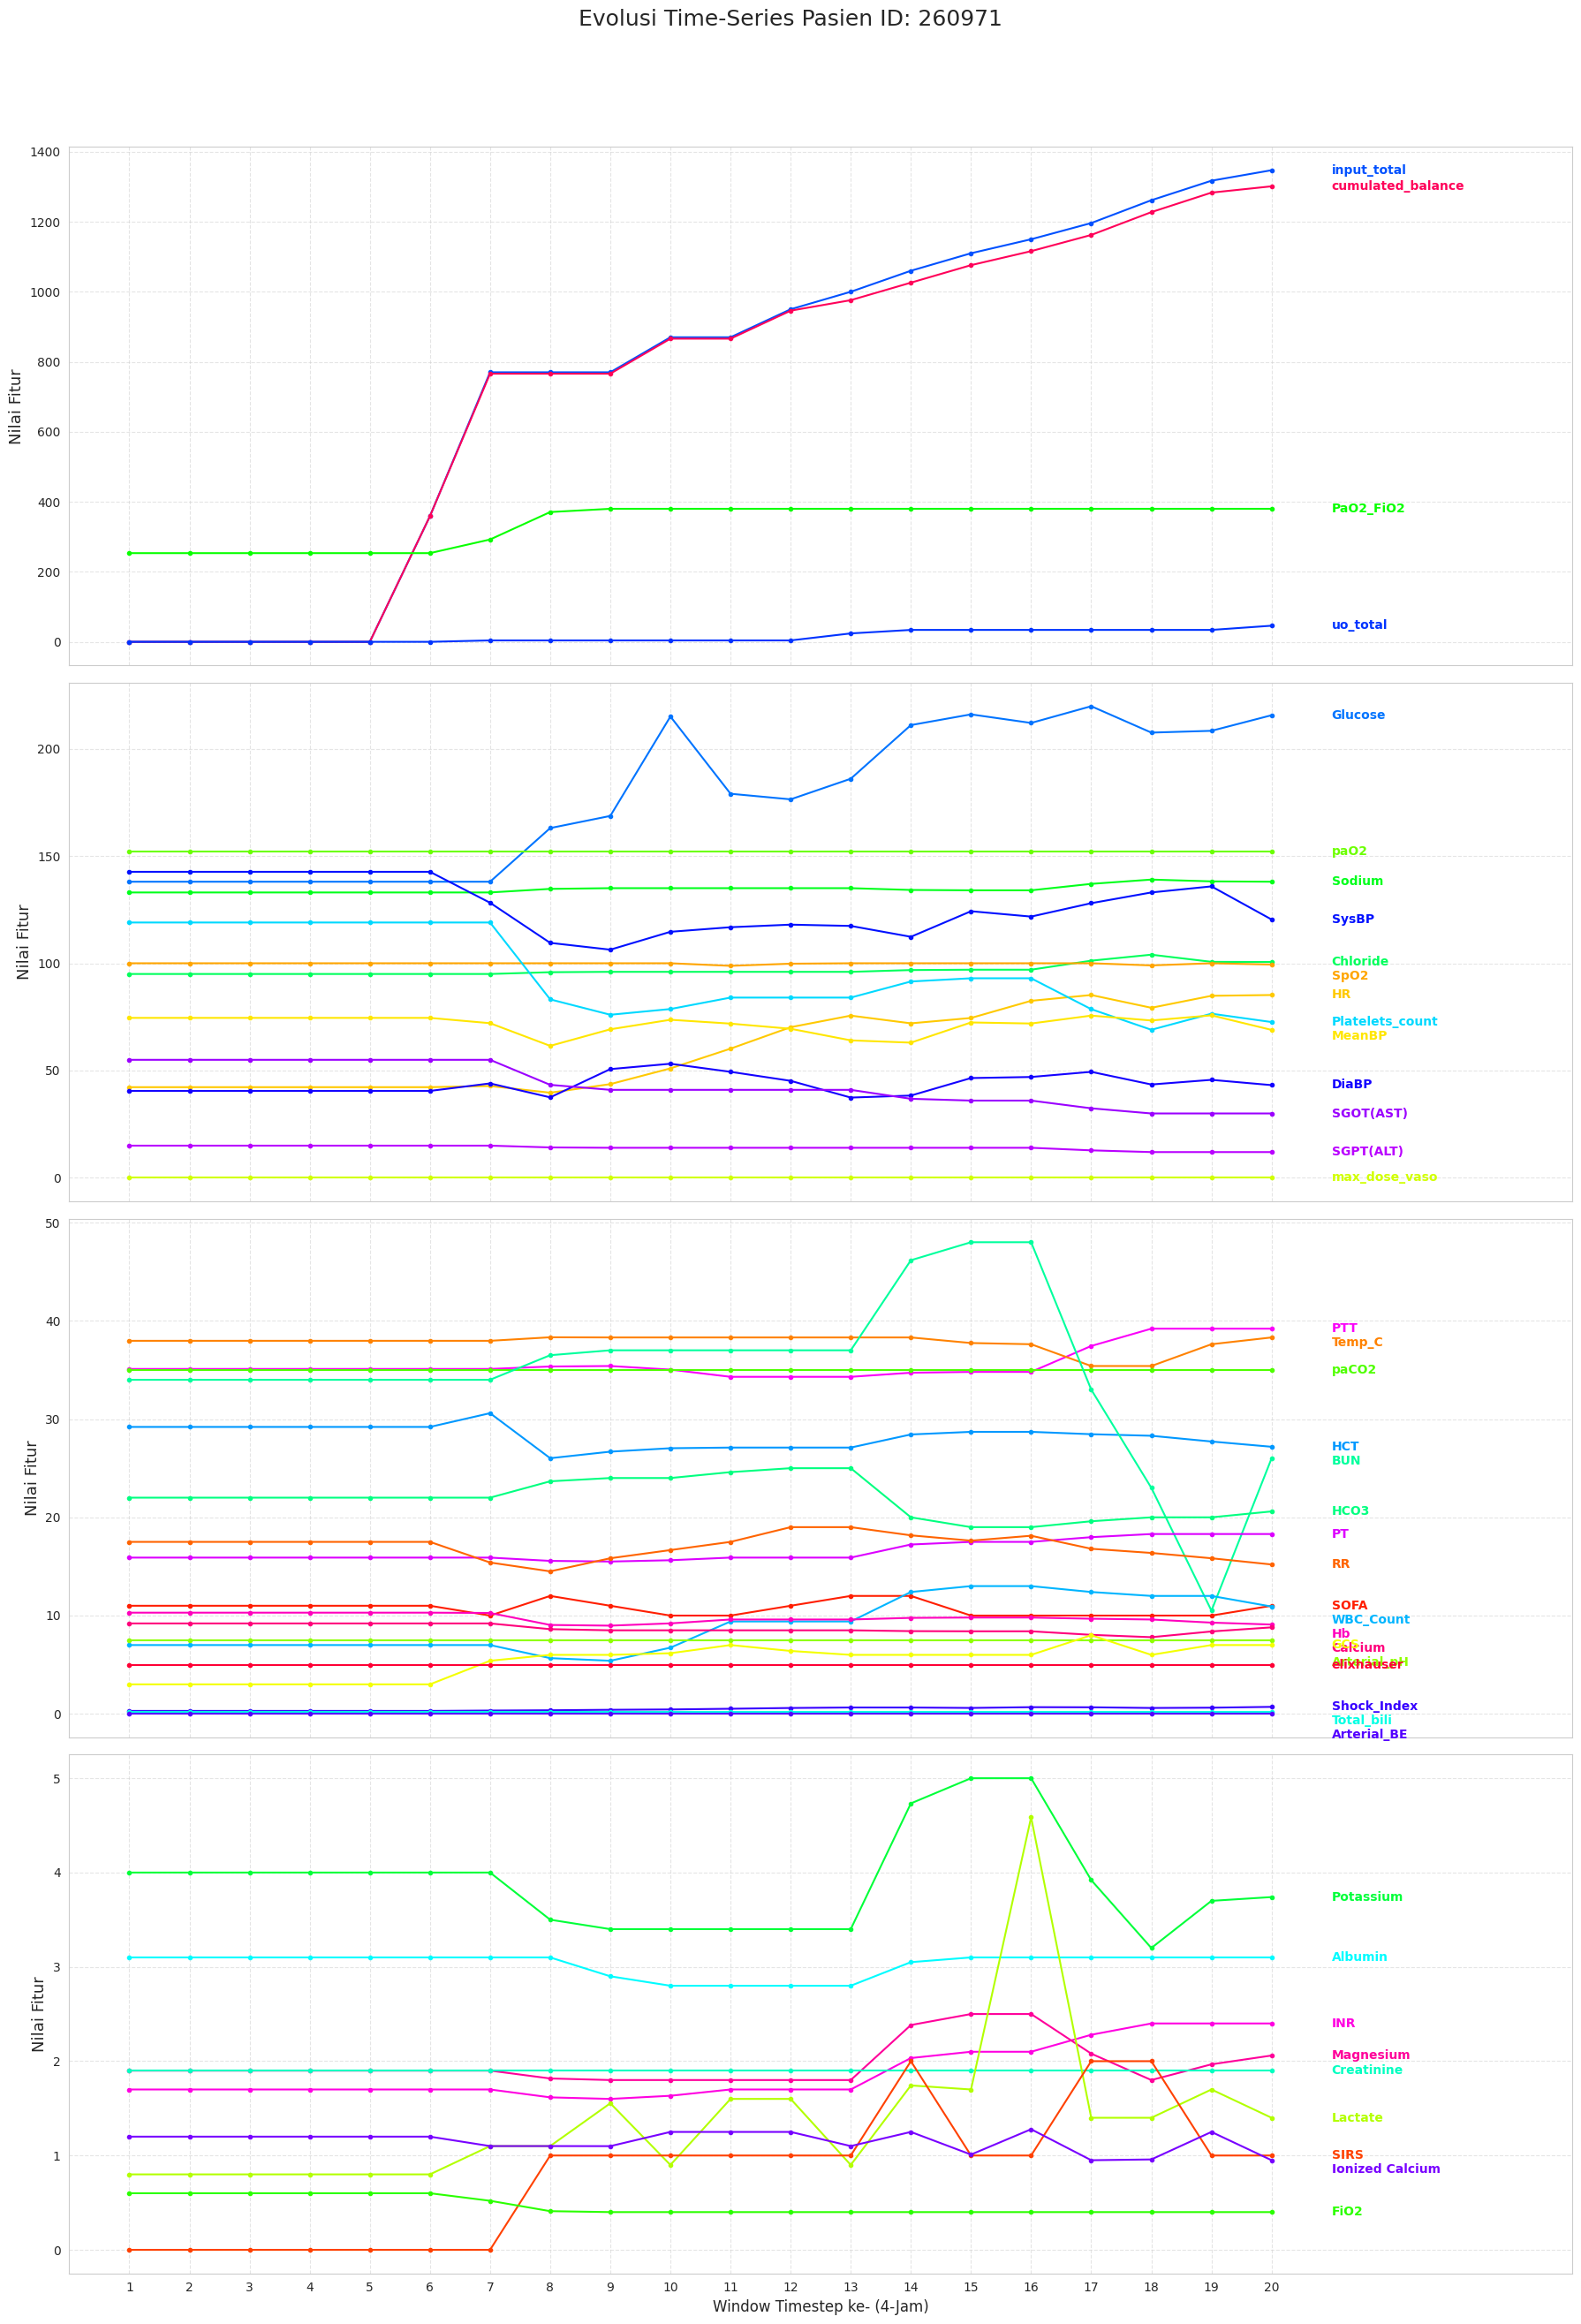

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ID Pasien Target
patient_id_to_plot = 260971

# Ambil data pasien
# Pastikan jalur file sudah benar
try:
    final_output_df = pd.read_csv('/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv')
except FileNotFoundError:
    print("⚠️ ERROR: Pastikan jalur file '/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv' sudah benar.")
    exit()

patient_data_raw = final_output_df[final_output_df['icustay_id'] == patient_id_to_plot].copy()

if patient_data_raw.empty:
    print(f"⚠️ Error: Pasien ID {patient_id_to_plot} tidak ditemukan dalam final_output_df.")
    exit()

# Daftar Fitur Time-Series (47 fitur asli + max_dose_vaso)
TS_ALL_FEATURES = [
    'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS', 'max_dose_vaso',
    'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium',
    'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count',
    'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index',
    'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb',
    'Magnesium', 'Calcium', 'cumulated_balance', 'elixhauser'
]

# Seleksi fitur time-series yang ada
TS_FEATURES_IN_DF = [col for col in TS_ALL_FEATURES if col in patient_data_raw.columns]

# --- PARAMETER PENGELOMPOKAN BERDASARKAN RENTANG NILAI (Skala Maksimum) ---
# Batas rentang maksimum absolut untuk pengelompokan
GROUPS = {
    "Kelompok 1 (Ribu+): Sangat Besar": 1000,
    "Kelompok 2 (Ratusan): Besar": 100,
    "Kelompok 3 (Puluhan): Sedang": 10,
    "Kelompok 4 (Desimal/Kecil): Kecil": 0 # Semua yang di bawah 10
}

# Hitung nilai maksimum (absolut) di seluruh kohort untuk menentukan skala
# Menggunakan seluruh kohort lebih robust daripada hanya data pasien ini
max_values = final_output_df[TS_FEATURES_IN_DF].abs().max().fillna(0)

# Inisialisasi kelompok
feature_groups_by_range = {key: [] for key in GROUPS}

# Lakukan pengelompokan dengan PENGECUALIAN MANUAL
for feature in TS_FEATURES_IN_DF:

    # Pengecualian 1: PaO2_FiO2 dipindahkan paksa ke Kelompok 1 (Paling Atas)
    if feature == 'PaO2_FiO2':
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
        continue

    # Pengecualian 2: Arterial_pH dipindahkan paksa ke Kelompok 3 (Puluhan)
    if feature == 'Arterial_pH':
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
        continue

    # Logika Pengelompokan Berdasarkan Rentang Nilai Default (max_values dari seluruh kohort)
    max_val = max_values[feature]
    if max_val >= GROUPS["Kelompok 1 (Ribu+): Sangat Besar"]:
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 2 (Ratusan): Besar"]:
        feature_groups_by_range["Kelompok 2 (Ratusan): Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 3 (Puluhan): Sedang"]:
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
    else:
        feature_groups_by_range["Kelompok 4 (Desimal/Kecil): Kecil"].append(feature)

# Hapus kelompok kosong
feature_groups_by_range = {k: v for k, v in feature_groups_by_range.items() if v}

# Ubah ke format list of lists untuk loop plotting
feature_chunks = list(feature_groups_by_range.values())
group_names = list(feature_groups_by_range.keys())
N_GROUPS = len(feature_chunks)

# --- Pemetaan Warna ---
n_features = len(TS_FEATURES_IN_DF)
colors = sns.color_palette("hsv", n_features)
color_map = {feature: colors[i] for i, feature in enumerate(TS_FEATURES_IN_DF)}

# =========================================================================
# PLOTTING SCRIPT DENGAN PENYESUAIAN UKURAN DAN JUDUL
# =========================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

TEXT_OFFSET_X = 1.0
X_AXIS_EXTENSION = 5
MIN_LABEL_DISTANCE_FACTOR = 0.03

# Ukuran figsize disesuaikan berdasarkan jumlah kelompok (agar lebih besar)
fig, axes = plt.subplots(N_GROUPS, 1, figsize=(18, 6.5 * N_GROUPS), sharex=True)
axes = axes.flatten()

# Judul utama diposisikan tinggi agar tidak menutupi chart
fig.suptitle(f"Evolusi Time-Series Pasien ID: {patient_id_to_plot}",
             fontsize=18,
             y=1.01)

# Bloc terakhir
last_bloc = patient_data_raw['bloc'].max()

for i, features in enumerate(feature_chunks):
    ax = axes[i]

    # 1. Mengurutkan fitur berdasarkan nilai terakhir (Bloc 20)
    last_values = patient_data_raw.loc[patient_data_raw['bloc'] == last_bloc, features].iloc[0]
    sorted_features = last_values.sort_values(ascending=False).index.tolist()

    # 2. Hitung Rentang Y dan Jarak Minimum
    plot_data_subset = patient_data_raw[features].melt()
    y_range = plot_data_subset['value'].max() - plot_data_subset['value'].min()
    min_distance = y_range * MIN_LABEL_DISTANCE_FACTOR
    if min_distance == 0:
        min_distance = 1e-6

    adjusted_positions = []

    # 3. Plot Data dan Penempatan Label Terurut
    for feature in sorted_features:
        color = color_map[feature]

        # Plot garis sinyal
        ax.plot(patient_data_raw['bloc'], patient_data_raw[feature],
                color=color, linewidth=1.5, marker='.')

        # Ambil nilai data pada bloc terakhir
        last_value = patient_data_raw.loc[patient_data_raw['bloc'] == last_bloc, feature].iloc[0]

        # --- Penyesuaian Posisi Y (Jittering Terkontrol) ---
        adjusted_y = last_value

        if pd.notna(last_value):
            if adjusted_positions:
                last_adjusted_y = adjusted_positions[-1]

                # Jittering Terkontrol
                if abs(adjusted_y - last_adjusted_y) < min_distance:
                    adjusted_y = last_adjusted_y - min_distance

            adjusted_positions.append(adjusted_y)

            # 4. Anotasi/Label Langsung
            ax.text(last_bloc + TEXT_OFFSET_X,
                    adjusted_y,
                    feature,
                    color=color,
                    fontsize=10,
                    weight='bold',
                    va='center')

    # Judul diambil dari nama kelompok baru
    ax.set_ylabel("Nilai Fitur", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Atur batas Y agar label yang disesuaikan terlihat
    current_ylim = ax.get_ylim()
    if adjusted_positions:
        min_y = min(adjusted_positions)
        max_y = max(adjusted_positions)
        ax.set_ylim(min(current_ylim[0], min_y * 0.95),
                    max(current_ylim[1], max_y * 1.05))

# Set sumbu X hanya pada subplot paling bawah
axes[-1].set_xlabel("Window Timestep ke- (4-Jam)", fontsize=12)
axes[-1].set_xticks(patient_data_raw['bloc'].unique())

# Perluas sumbu X untuk memberi ruang pada label teks
axes[0].set_xlim(patient_data_raw['bloc'].min() - 1, last_bloc + X_AXIS_EXTENSION)

plt.tight_layout(rect=[0, 0, 1, 1])
fig.subplots_adjust(top=0.95) # Menyesuaikan ruang di bagian atas figure

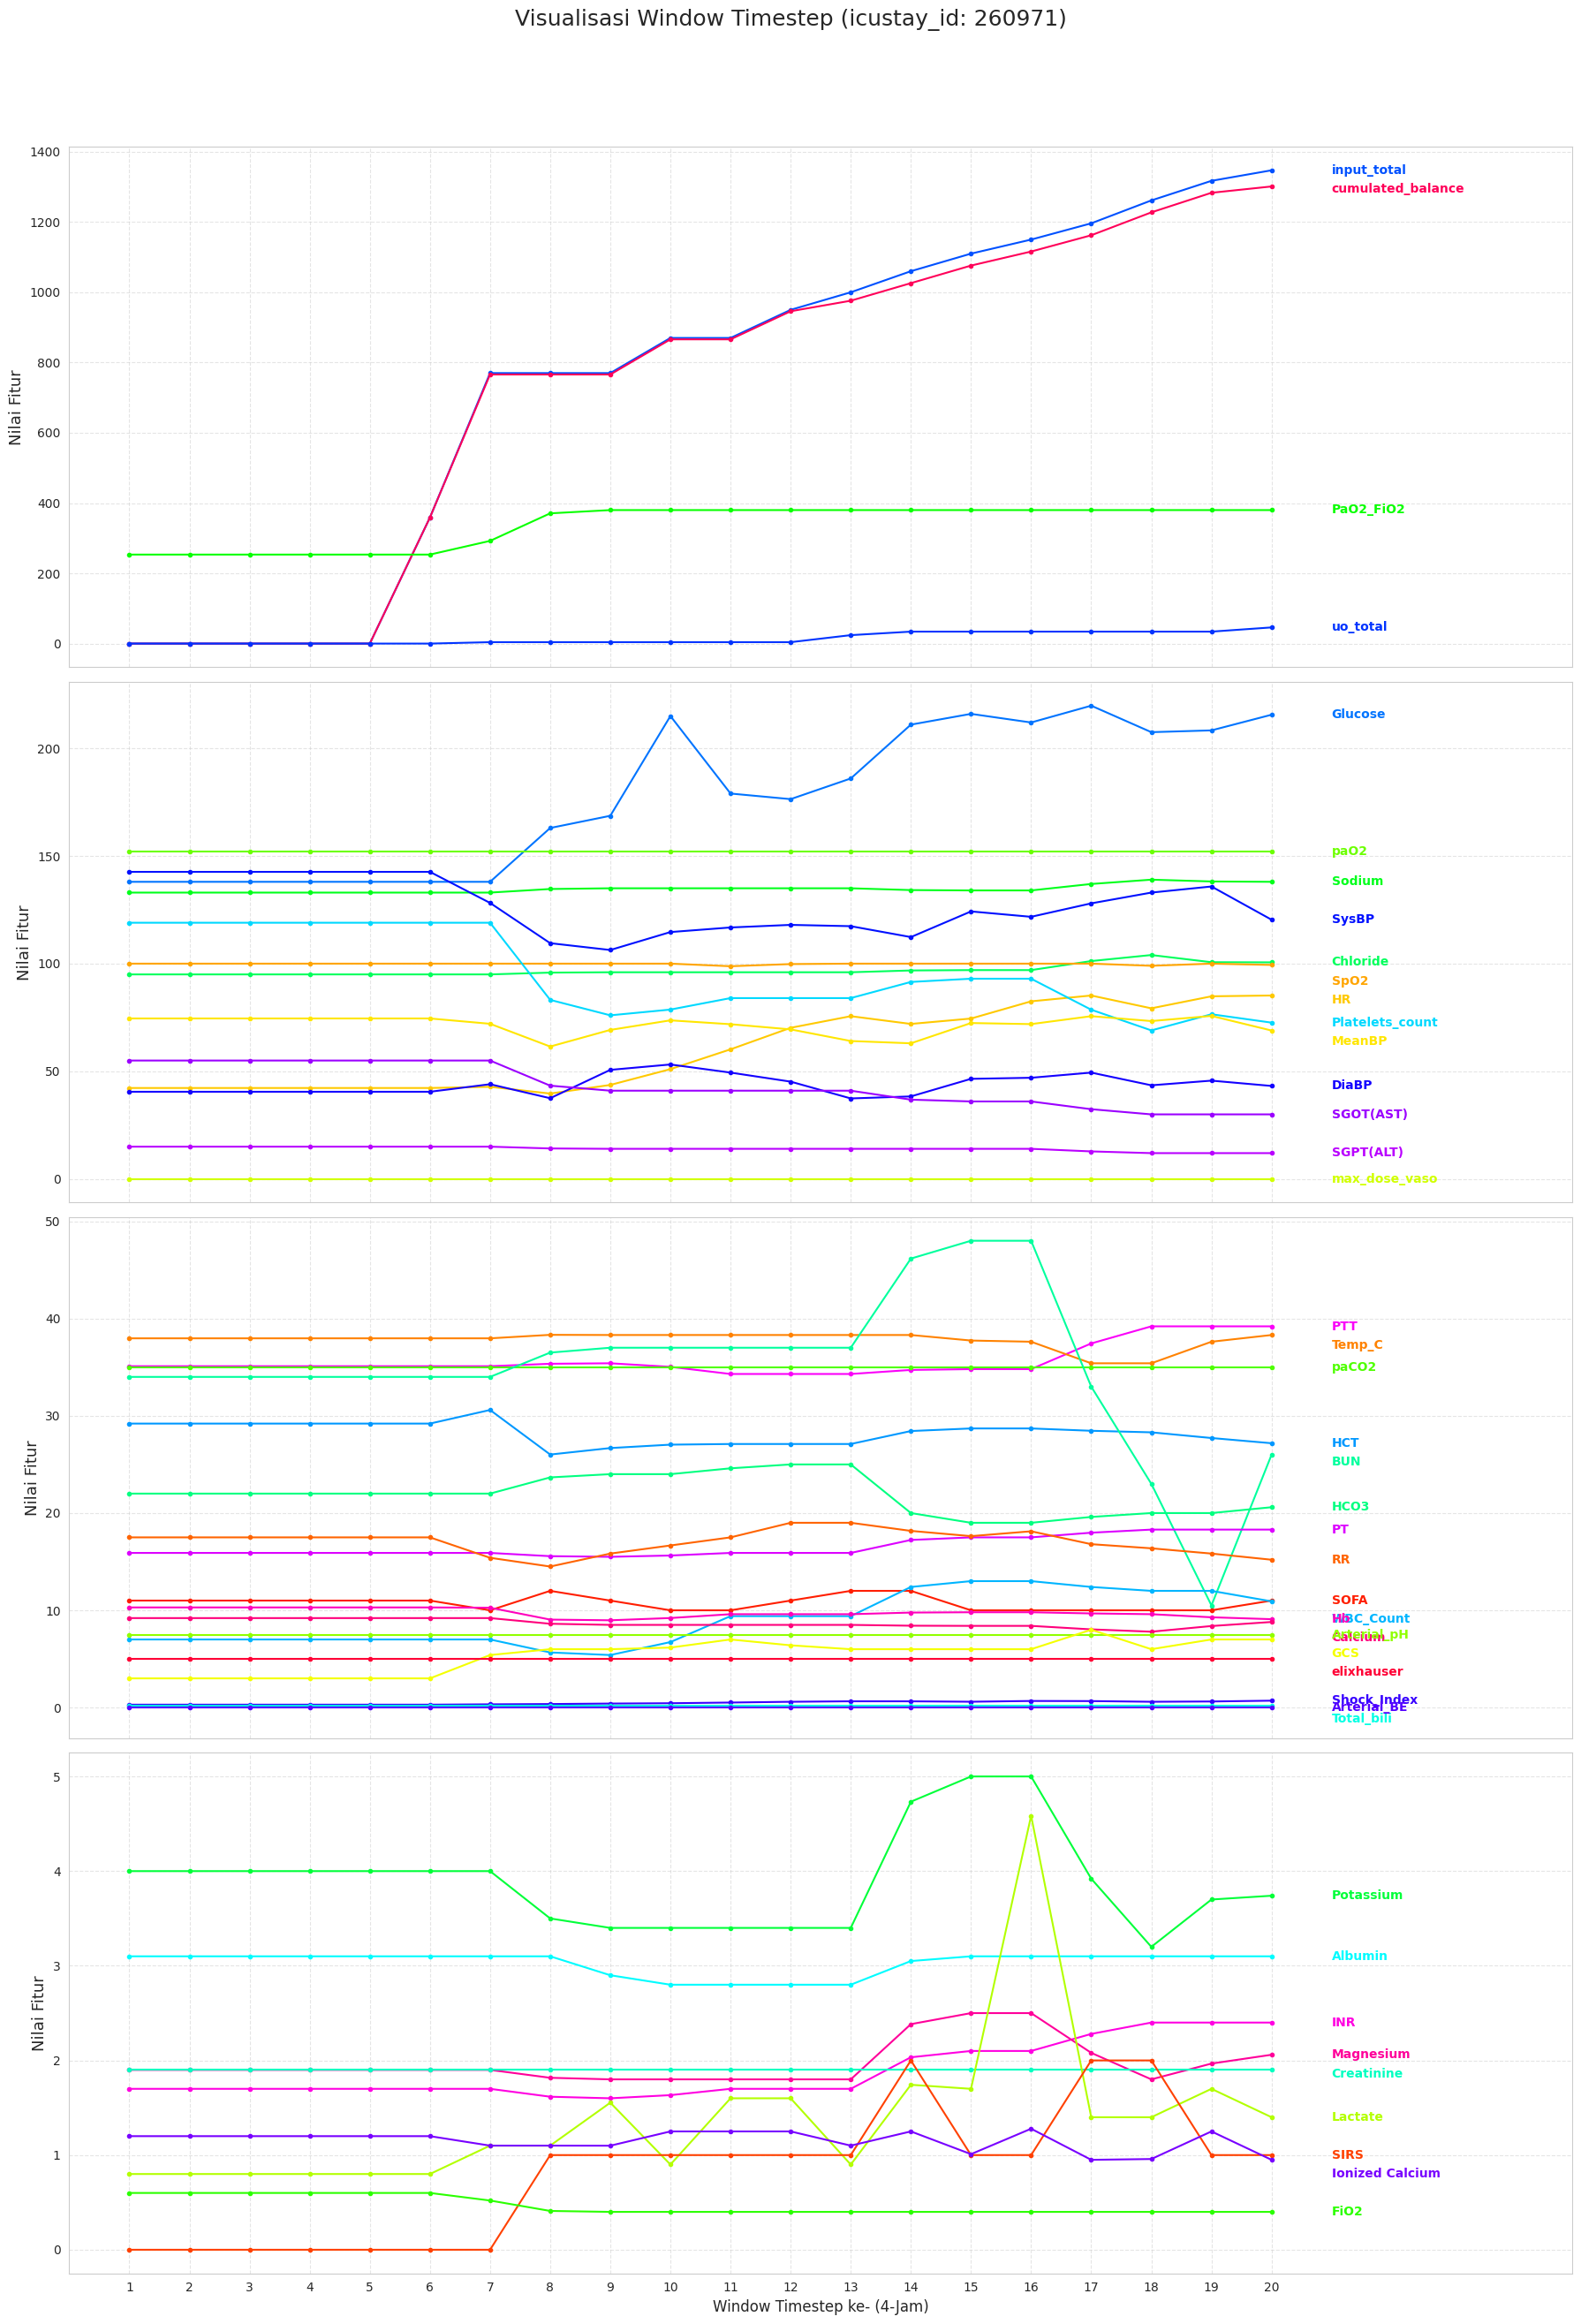

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ID Pasien Target
patient_id_to_plot = 260971

# Ambil data pasien
# Pastikan jalur file sudah benar
try:
    final_output_df = pd.read_csv('/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv')
except FileNotFoundError:
    print("⚠️ ERROR: Pastikan jalur file '/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv' sudah benar.")
    exit()

patient_data_raw = final_output_df[final_output_df['icustay_id'] == patient_id_to_plot].copy()

if patient_data_raw.empty:
    print(f"⚠️ Error: Pasien ID {patient_id_to_plot} tidak ditemukan dalam final_output_df.")
    exit()

# Daftar Fitur Time-Series (47 fitur asli + max_dose_vaso)
TS_ALL_FEATURES = [
    'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS', 'max_dose_vaso',
    'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium',
    'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count',
    'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index',
    'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb',
    'Magnesium', 'Calcium', 'cumulated_balance', 'elixhauser'
]

# Seleksi fitur time-series yang ada
TS_FEATURES_IN_DF = [col for col in TS_ALL_FEATURES if col in patient_data_raw.columns]

# --- PARAMETER PENGELOMPOKAN BERDASARKAN RENTANG NILAI (Skala Maksimum) ---
GROUPS = {
    "Kelompok 1 (Ribu+): Sangat Besar": 1000,
    "Kelompok 2 (Ratusan): Besar": 100,
    "Kelompok 3 (Puluhan): Sedang": 10,
    "Kelompok 4 (Desimal/Kecil): Kecil": 0
}

max_values = final_output_df[TS_FEATURES_IN_DF].abs().max().fillna(0)

# Inisialisasi kelompok
feature_groups_by_range = {key: [] for key in GROUPS}

# Lakukan pengelompokan dengan PENGECUALIAN MANUAL
for feature in TS_FEATURES_IN_DF:

    # Pengecualian 1: PaO2_FiO2 dipindahkan paksa ke Kelompok 1 (Paling Atas)
    if feature == 'PaO2_FiO2':
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
        continue

    # Pengecualian 2: Arterial_pH dipindahkan paksa ke Kelompok 3 (Puluhan)
    if feature == 'Arterial_pH':
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
        continue

    # Logika Pengelompokan Berdasarkan Rentang Nilai Default
    max_val = max_values[feature]
    if max_val >= GROUPS["Kelompok 1 (Ribu+): Sangat Besar"]:
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 2 (Ratusan): Besar"]:
        feature_groups_by_range["Kelompok 2 (Ratusan): Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 3 (Puluhan): Sedang"]:
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
    else:
        feature_groups_by_range["Kelompok 4 (Desimal/Kecil): Kecil"].append(feature)

# Hapus kelompok kosong
feature_groups_by_range = {k: v for k, v in feature_groups_by_range.items() if v}

# Ubah ke format list of lists untuk loop plotting
feature_chunks = list(feature_groups_by_range.values())
group_names = list(feature_groups_by_range.keys())
N_GROUPS = len(feature_chunks)

# --- Pemetaan Warna ---
n_features = len(TS_FEATURES_IN_DF)
colors = sns.color_palette("hsv", n_features)
color_map = {feature: colors[i] for i, feature in enumerate(TS_FEATURES_IN_DF)}

# =========================================================================
# PLOTTING SCRIPT DENGAN PENYESUAIAN UKURAN DAN JUDUL
# =========================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

TEXT_OFFSET_X = 1.0
X_AXIS_EXTENSION = 5
MIN_LABEL_DISTANCE_FACTOR = 0.04

# Ukuran figsize disesuaikan berdasarkan jumlah kelompok (agar lebih besar)
fig, axes = plt.subplots(N_GROUPS, 1, figsize=(18, 6.5 * N_GROUPS), sharex=True)
axes = axes.flatten()

# Judul utama diposisikan tinggi agar tidak menutupi chart
fig.suptitle(f"Visualisasi Window Timestep (icustay_id: {patient_id_to_plot})",
             fontsize=18,
             y=1.01)

# Bloc terakhir
last_bloc = patient_data_raw['bloc'].max()

for i, features in enumerate(feature_chunks):
    ax = axes[i]

    # 1. Mengurutkan fitur berdasarkan nilai terakhir (Bloc 20)
    last_values = patient_data_raw.loc[patient_data_raw['bloc'] == last_bloc, features].iloc[0]
    sorted_features = last_values.sort_values(ascending=False).index.tolist()

    # 2. Hitung Rentang Y dan Jarak Minimum
    plot_data_subset = patient_data_raw[features].melt()
    y_range = plot_data_subset['value'].max() - plot_data_subset['value'].min()
    min_distance = y_range * MIN_LABEL_DISTANCE_FACTOR
    if min_distance == 0:
        min_distance = 1e-6

    adjusted_positions = []

    # 3. Plot Data dan Penempatan Label Terurut
    for feature in sorted_features:
        color = color_map[feature]

        # Plot garis sinyal
        ax.plot(patient_data_raw['bloc'], patient_data_raw[feature],
                color=color, linewidth=1.5, marker='.')

        # Ambil nilai data pada bloc terakhir
        last_value = patient_data_raw.loc[patient_data_raw['bloc'] == last_bloc, feature].iloc[0]

        # --- PERBAIKAN LOGIKA JITTERING SEDERHANA ---
        adjusted_y = last_value

        if pd.notna(last_value):
            if adjusted_positions:
                last_adjusted_y = adjusted_positions[-1]

                # Jittering Sederhana: Hanya cek tumpukan dengan posisi sebelumnya
                # Jika terlalu dekat, geser adjusted_y KE BAWAH sebesar min_distance.
                # Karena fitur diurutkan dari nilai tertinggi, pergeseran ke bawah mencegah tumpukan.
                if adjusted_y < last_adjusted_y and abs(adjusted_y - last_adjusted_y) < min_distance:
                     adjusted_y = last_adjusted_y - min_distance
                # Kasus lain: jika nilainya sama persis (adjusted_y == last_adjusted_y)
                elif adjusted_y == last_adjusted_y:
                    adjusted_y = last_adjusted_y - min_distance

            adjusted_positions.append(adjusted_y)

            # 4. Anotasi/Label Langsung
            ax.text(last_bloc + TEXT_OFFSET_X,
                    adjusted_y,
                    feature,
                    color=color,
                    fontsize=10,
                    weight='bold',
                    va='center')

    # Judul diambil dari nama kelompok baru
    ax.set_ylabel("Nilai Fitur", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Atur batas Y agar label yang disesuaikan terlihat
    current_ylim = ax.get_ylim()
    if adjusted_positions:
        min_y = min(adjusted_positions)
        max_y = max(adjusted_positions)
        # Perluas sumbu Y agar label yang tergeser (jittered) terlihat
        ax.set_ylim(min(current_ylim[0], min_y - min_distance),
                    max(current_ylim[1], max_y + min_distance))

# Set sumbu X hanya pada subplot paling bawah
axes[-1].set_xlabel("Window Timestep ke- (4-Jam)", fontsize=12)
axes[-1].set_xticks(patient_data_raw['bloc'].unique())

# Perluas sumbu X untuk memberi ruang pada label teks
axes[0].set_xlim(patient_data_raw['bloc'].min() - 1, last_bloc + X_AXIS_EXTENSION)

plt.tight_layout(rect=[0, 0, 1, 1])
fig.subplots_adjust(top=0.95)

plt.show()

Memproses data untuk icustay_id: 260971


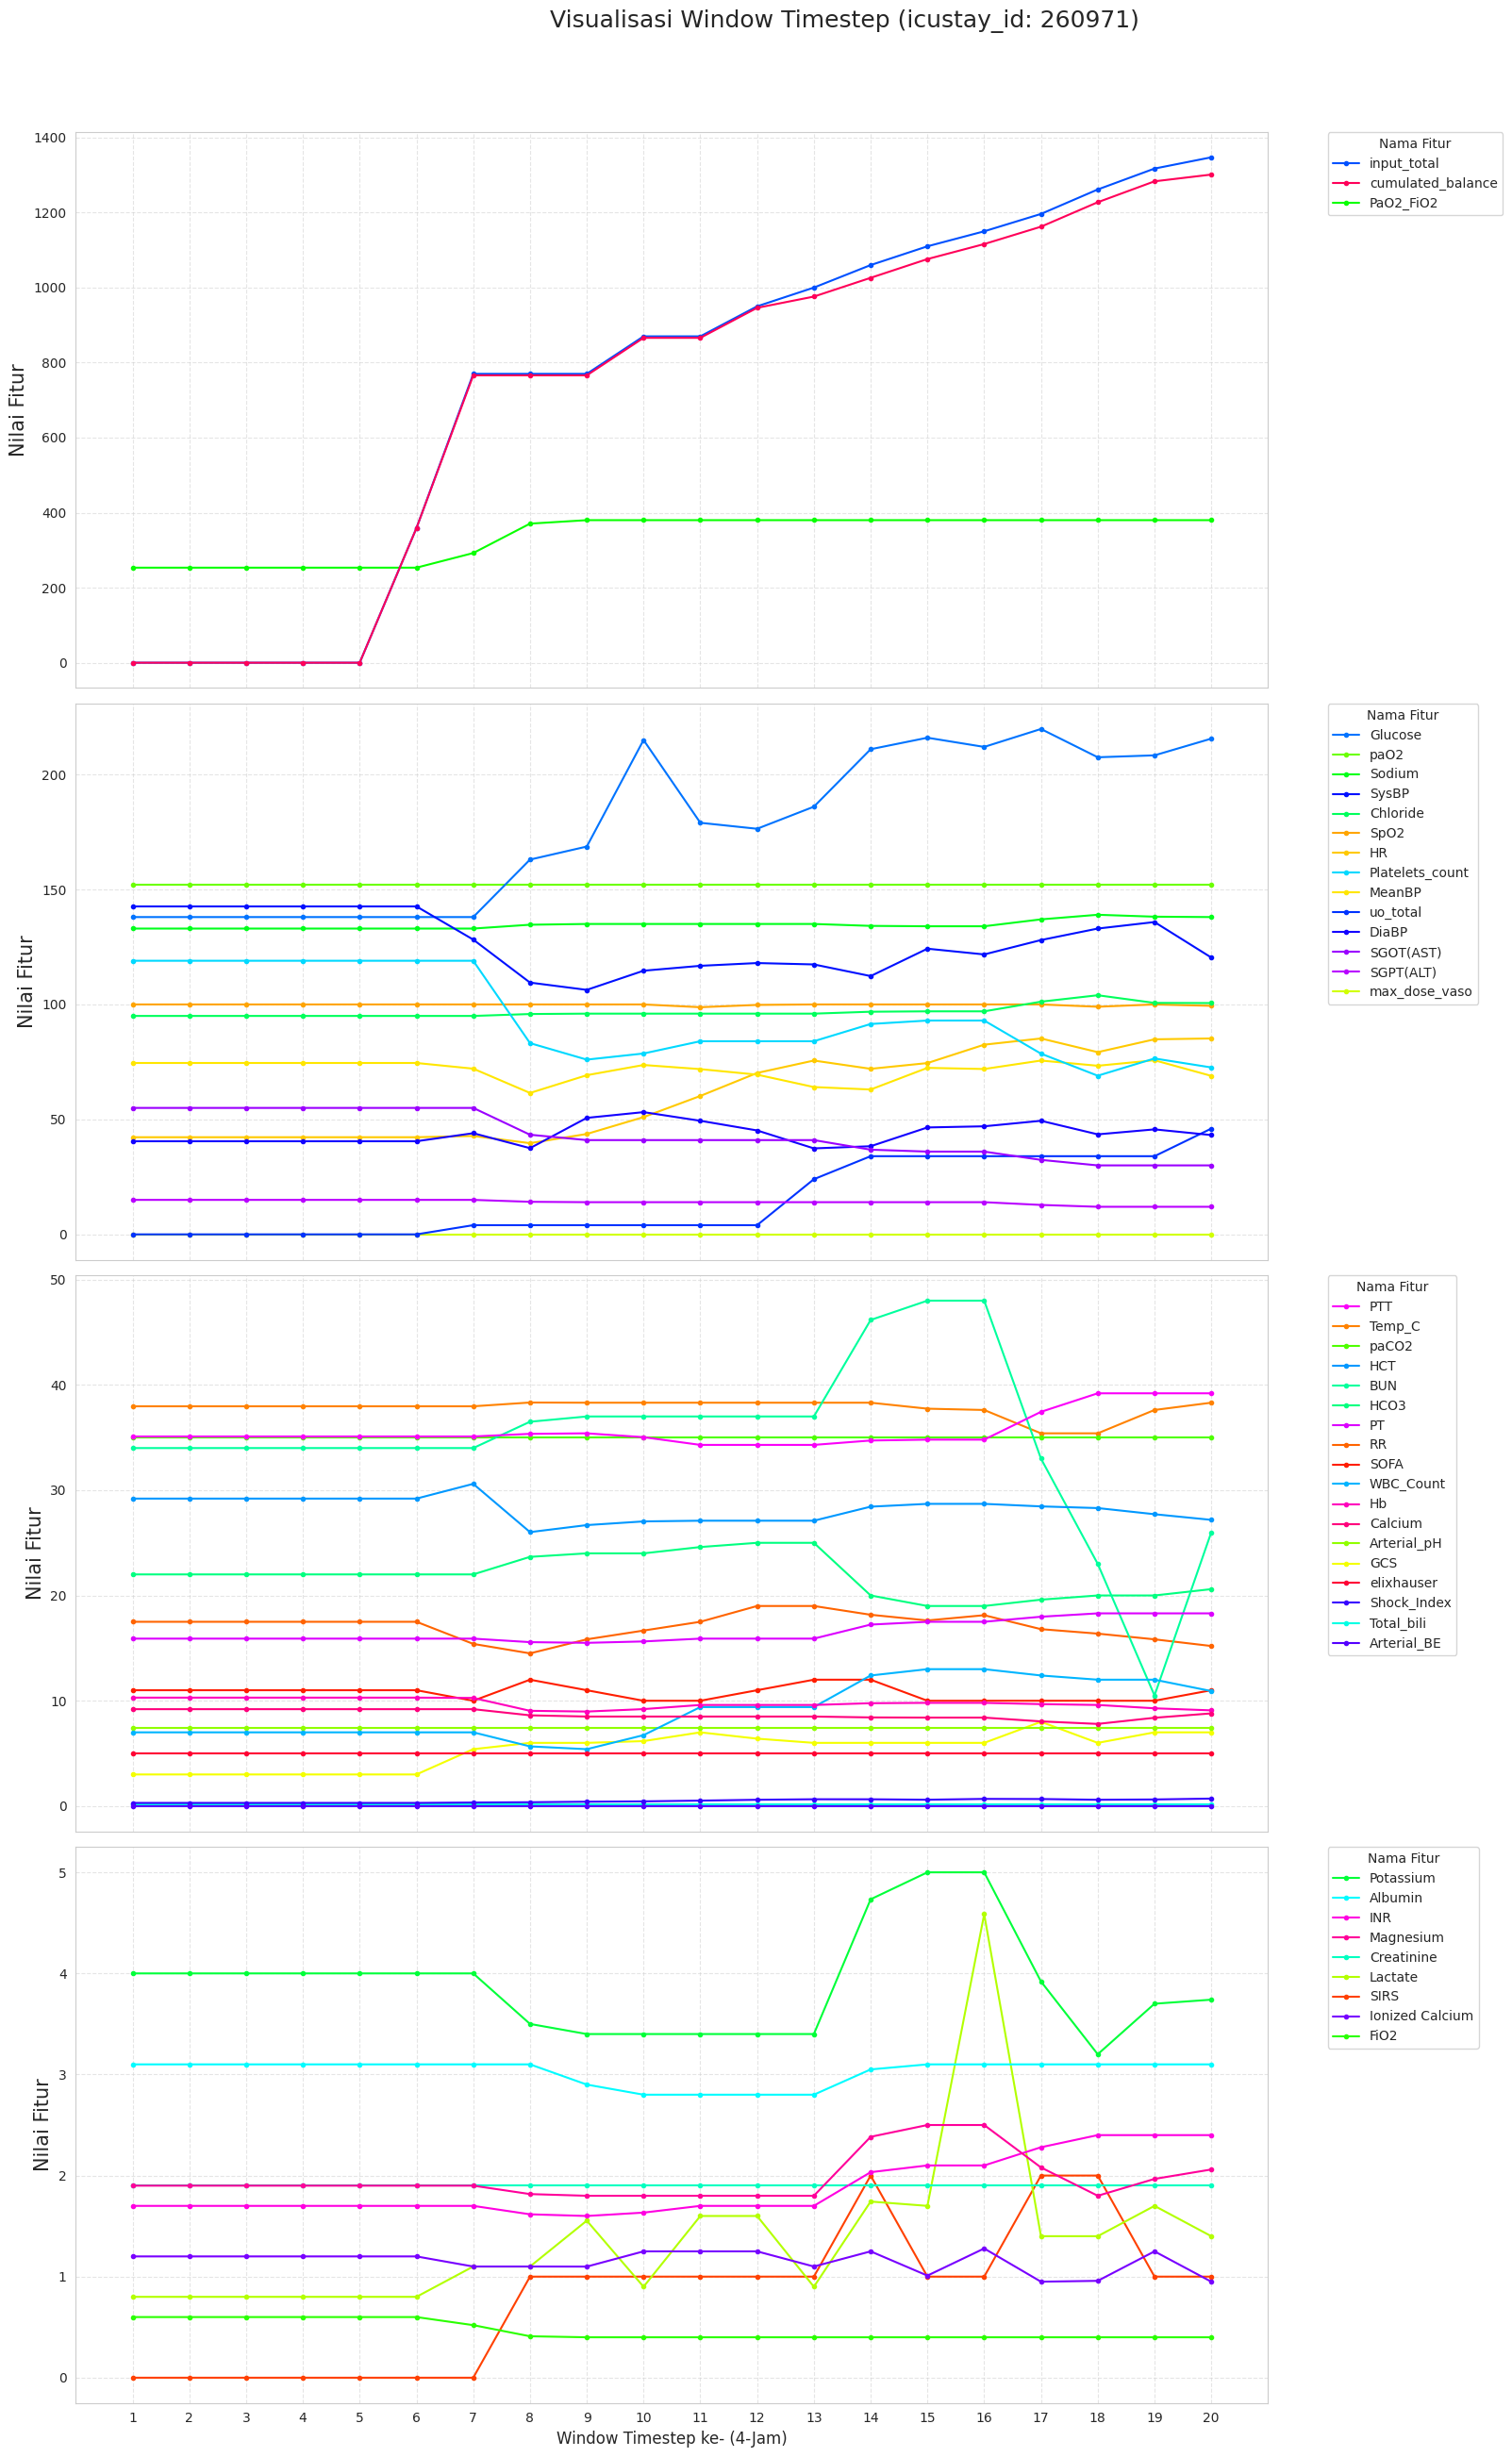

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ID Pasien Target
patient_id_to_plot = 260971
print(f"Memproses data untuk icustay_id: {patient_id_to_plot}")

# Ambil data pasien
# Pastikan jalur file sudah benar
try:
    final_output_df = pd.read_csv('/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv')
except FileNotFoundError:
    print("⚠️ ERROR: Pastikan jalur file '/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv' sudah benar.")
    exit()

patient_data_raw = final_output_df[final_output_df['icustay_id'] == patient_id_to_plot].copy()

if patient_data_raw.empty:
    print(f"⚠️ Error: Pasien ID {patient_id_to_plot} tidak ditemukan dalam final_output_df.")
    exit()

# Daftar Fitur Time-Series (47 fitur asli + max_dose_vaso)
TS_ALL_FEATURES = [
    'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS', 'max_dose_vaso',
    'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium',
    'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count',
    'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index',
    'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb',
    'Magnesium', 'Calcium', 'cumulated_balance', 'elixhauser'
]

# Seleksi fitur time-series yang ada
TS_FEATURES_IN_DF = [col for col in TS_ALL_FEATURES if col in patient_data_raw.columns]

# --- PARAMETER PENGELOMPOKAN BERDASARKAN RENTANG NILAI (Skala Maksimum) ---
GROUPS = {
    "Kelompok 1 (Ribu+): Sangat Besar": 1000,
    "Kelompok 2 (Ratusan): Besar": 100,
    "Kelompok 3 (Puluhan): Sedang": 10,
    "Kelompok 4 (Desimal/Kecil): Kecil": 0
}

max_values = final_output_df[TS_FEATURES_IN_DF].abs().max().fillna(0)

# Inisialisasi kelompok
feature_groups_by_range = {key: [] for key in GROUPS}

# Lakukan pengelompokan dengan PENGECUALIAN MANUAL
for feature in TS_FEATURES_IN_DF:

    # Pengecualian 1: PaO2_FiO2 dipindahkan paksa ke Kelompok 1 (Paling Atas)
    if feature == 'PaO2_FiO2':
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
        continue

    # Pengecualian 2: Arterial_pH dipindahkan paksa ke Kelompok 3 (Puluhan)
    if feature == 'Arterial_pH':
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
        continue

    # Pengecualian : uo_total dipindahkan paksa ke Kelompok 2 (Ratusan)
    if feature == 'uo_total':
        feature_groups_by_range["Kelompok 2 (Ratusan): Besar"].append(feature)
        continue

    # Logika Pengelompokan Berdasarkan Rentang Nilai Default
    max_val = max_values[feature]
    if max_val >= GROUPS["Kelompok 1 (Ribu+): Sangat Besar"]:
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 2 (Ratusan): Besar"]:
        feature_groups_by_range["Kelompok 2 (Ratusan): Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 3 (Puluhan): Sedang"]:
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
    else:
        feature_groups_by_range["Kelompok 4 (Desimal/Kecil): Kecil"].append(feature)

# Hapus kelompok kosong
feature_groups_by_range = {k: v for k, v in feature_groups_by_range.items() if v}

# Ubah ke format list of lists untuk loop plotting
feature_chunks = list(feature_groups_by_range.values())
group_names = list(feature_groups_by_range.keys())
N_GROUPS = len(feature_chunks)

# --- Pemetaan Warna ---
n_features = len(TS_FEATURES_IN_DF)
colors = sns.color_palette("hsv", n_features)
color_map = {feature: colors[i] for i, feature in enumerate(TS_FEATURES_IN_DF)}

# =========================================================================
# PLOTTING SCRIPT DENGAN LEGEND DIURUTKAN BERDASARKAN NILAI TERAKHIR
# =========================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Ukuran figsize disesuaikan berdasarkan jumlah kelompok
fig, axes = plt.subplots(N_GROUPS, 1, figsize=(18, 6.5 * N_GROUPS), sharex=True)
axes = axes.flatten()

# Judul utama
fig.suptitle(f"Visualisasi Window Timestep (icustay_id: {patient_id_to_plot})",
             fontsize=18,
             y=1.0)

# Bloc terakhir
last_bloc = patient_data_raw['bloc'].max()

for i, features in enumerate(feature_chunks):
    ax = axes[i]

    # 1. Mengumpulkan data garis dan nilai terakhir
    plot_items = []

    for feature in features:
        color = color_map[feature]

        # Plot garis sinyal
        line, = ax.plot(patient_data_raw['bloc'], patient_data_raw[feature],
                        color=color, linewidth=1.5, marker='.', label=feature)

        # Ambil nilai data pada bloc terakhir
        last_value = patient_data_raw.loc[patient_data_raw['bloc'] == last_bloc, feature].iloc[0]

        # Simpan sebagai tuple: (garis, label, nilai_terakhir)
        plot_items.append((line, feature, last_value))

    # 2. Urutkan berdasarkan nilai terakhir (Descending: Nilai tertinggi di atas)
    # Gunakan key=lambda x: x[2] untuk mengurutkan berdasarkan elemen ketiga (nilai_terakhir)
    sorted_plot_items = sorted(plot_items, key=lambda x: x[2], reverse=True)

    # 3. Pisahkan lagi menjadi lines dan labels yang sudah diurutkan
    sorted_lines = [item[0] for item in sorted_plot_items]
    sorted_labels = [item[1] for item in sorted_plot_items]

    ax.set_ylabel("Nilai Fitur", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.5)

    # 4. Tambahkan Legend yang sudah diurutkan
    ax.legend(sorted_lines, sorted_labels,
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              fontsize=10,
              title="Nama Fitur",
              frameon=True)

# Set sumbu X hanya pada subplot paling bawah
axes[-1].set_xlabel("Window Timestep ke- (4-Jam)", fontsize=12)
axes[-1].set_xticks(patient_data_raw['bloc'].unique())

# Perluas sumbu X sedikit saja
axes[0].set_xlim(patient_data_raw['bloc'].min() - 1, last_bloc + 1)

# Sesuaikan layout untuk memberi ruang pada legend
plt.tight_layout(rect=[0, 0, 0.9, 1])
fig.subplots_adjust(top=0.95)

plt.show()

Memproses data kohort untuk analisis tren Survivor vs Non-Survivor...
Total Pasien Survivor: 16201
Total Pasien Non-Survivor: 2629


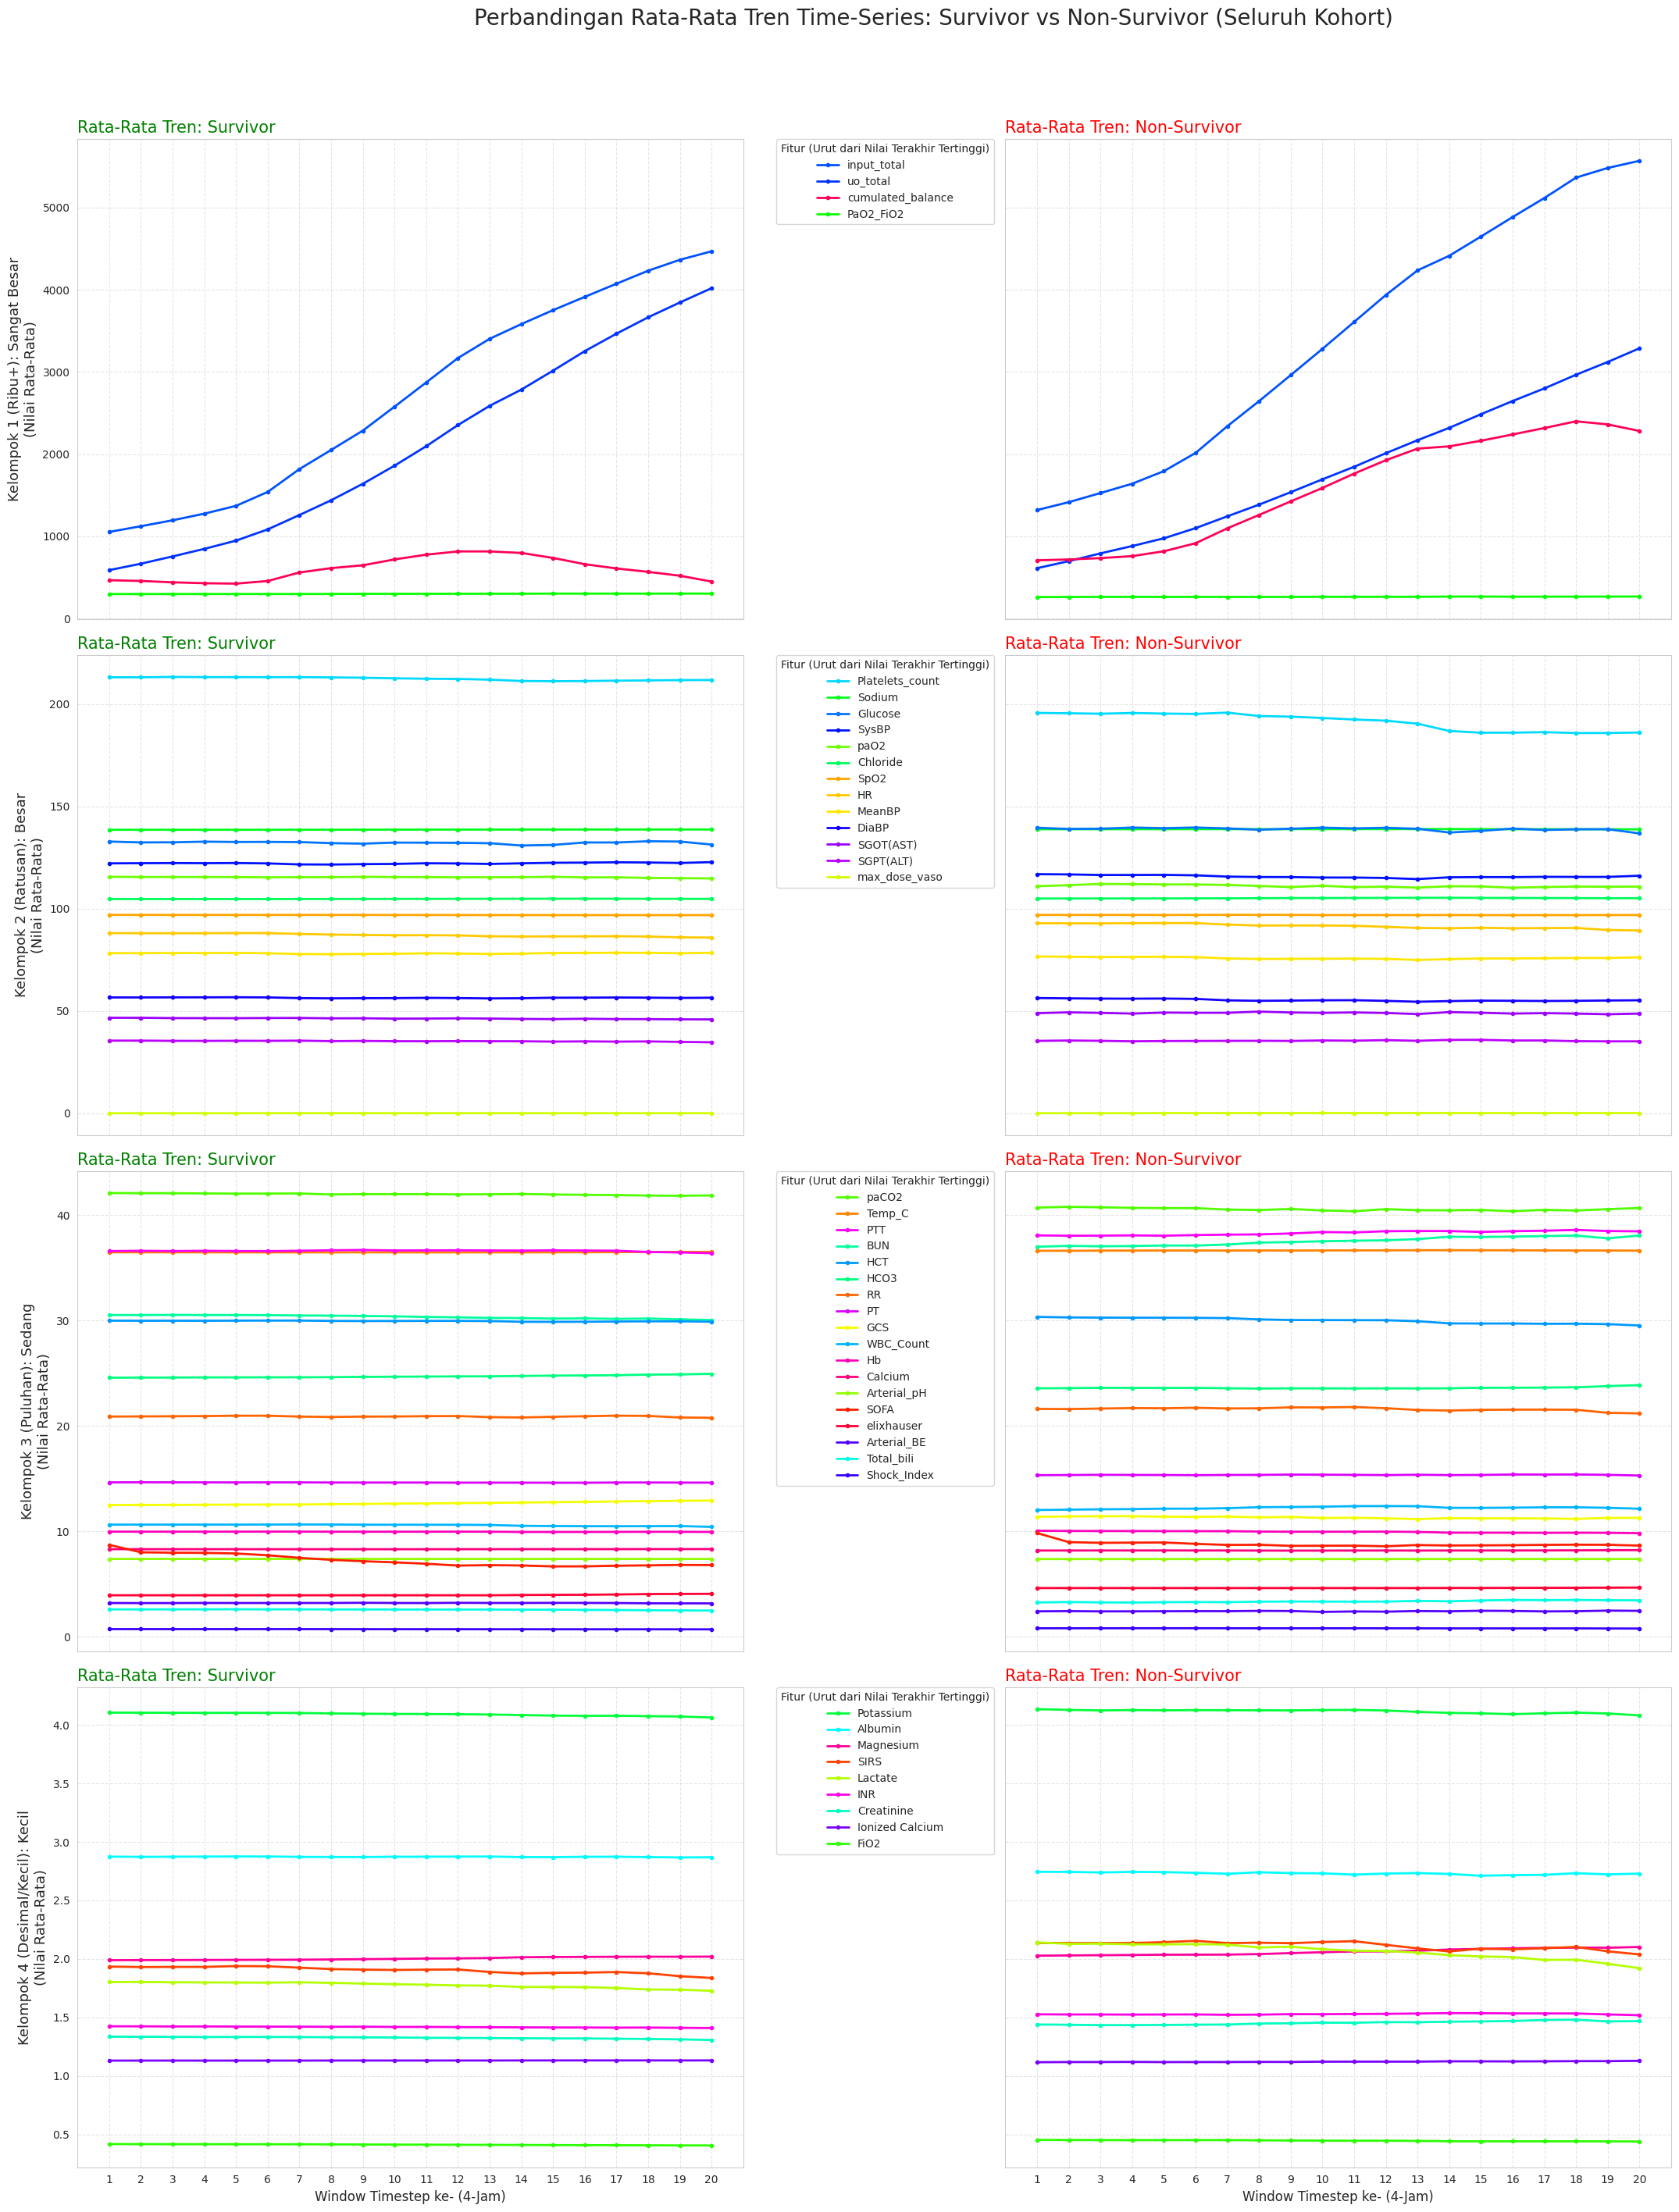


✅ Visualisasi perbandingan tren kohort selesai. Setiap baris membandingkan rata-rata fitur yang dikelompokkan untuk Survivor dan Non-Survivor.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Memproses data kohort untuk analisis tren Survivor vs Non-Survivor...")

# Ambil data kohort
# Asumsi jalur file sudah benar dan ini adalah sumber data yang menyebabkan lambat
try:
    final_output_df = pd.read_csv('/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv')
except FileNotFoundError:
    print("⚠️ ERROR: Pastikan jalur file '/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv' sudah benar.")
    exit()

# 1. Tentukan Kelompok Survivor
# hospital_expire_flag: 0 = Survivor, 1 = Non-Survivor (Meninggal di Rumah Sakit)
survivor_df = final_output_df[final_output_df['morta_hosp'] == 0]
non_survivor_df = final_output_df[final_output_df['morta_hosp'] == 1]

print(f"Total Pasien Survivor: {survivor_df['icustay_id'].nunique()}")
print(f"Total Pasien Non-Survivor: {non_survivor_df['icustay_id'].nunique()}")


# Daftar Fitur Time-Series (47 fitur asli + max_dose_vaso)
TS_ALL_FEATURES = [
    'SOFA', 'SIRS', 'RR', 'Temp_C', 'SpO2', 'HR', 'MeanBP', 'GCS', 'max_dose_vaso',
    'Lactate', 'Arterial_pH', 'paO2', 'paCO2', 'FiO2', 'PaO2_FiO2', 'Sodium', 'Potassium',
    'Chloride', 'HCO3', 'BUN', 'Creatinine', 'Total_bili', 'Albumin', 'Platelets_count',
    'WBC_Count', 'HCT', 'Glucose', 'input_total', 'uo_total', 'SysBP', 'DiaBP', 'Shock_Index',
    'Arterial_BE', 'Ionized Calcium', 'SGOT(AST)', 'SGPT(ALT)', 'PT', 'PTT', 'INR', 'Hb',
    'Magnesium', 'Calcium', 'cumulated_balance', 'elixhauser'
]

# Seleksi fitur time-series yang ada
TS_FEATURES_IN_DF = [col for col in TS_ALL_FEATURES if col in final_output_df.columns]

# --- PARAMETER PENGELOMPOKAN BERDASARKAN RENTANG NILAI (Skala Maksimum Kohort) ---
GROUPS = {
    "Kelompok 1 (Ribu+): Sangat Besar": 1000,
    "Kelompok 2 (Ratusan): Besar": 100,
    "Kelompok 3 (Puluhan): Sedang": 10,
    "Kelompok 4 (Desimal/Kecil): Kecil": 0
}

# Gunakan nilai maksimum dari SELURUH kohort untuk pengelompokan
max_values = final_output_df[TS_FEATURES_IN_DF].abs().max().fillna(0)

# Inisialisasi kelompok
feature_groups_by_range = {key: [] for key in GROUPS}

# Lakukan pengelompokan dengan PENGECUALIAN MANUAL
for feature in TS_FEATURES_IN_DF:

    # Pengecualian 1: PaO2_FiO2 dipindahkan paksa ke Kelompok 1
    if feature == 'PaO2_FiO2':
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
        continue

    # Pengecualian 2: Arterial_pH dipindahkan paksa ke Kelompok 3
    if feature == 'Arterial_pH':
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
        continue

    # Logika Pengelompokan Berdasarkan Rentang Nilai Default
    max_val = max_values[feature]
    if max_val >= GROUPS["Kelompok 1 (Ribu+): Sangat Besar"]:
        feature_groups_by_range["Kelompok 1 (Ribu+): Sangat Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 2 (Ratusan): Besar"]:
        feature_groups_by_range["Kelompok 2 (Ratusan): Besar"].append(feature)
    elif max_val >= GROUPS["Kelompok 3 (Puluhan): Sedang"]:
        feature_groups_by_range["Kelompok 3 (Puluhan): Sedang"].append(feature)
    else:
        feature_groups_by_range["Kelompok 4 (Desimal/Kecil): Kecil"].append(feature)

# Hapus kelompok kosong
feature_groups_by_range = {k: v for k, v in feature_groups_by_range.items() if v}

feature_chunks = list(feature_groups_by_range.values())
group_names = list(feature_groups_by_range.keys())
N_GROUPS = len(feature_chunks)

# 2. Hitung Rata-Rata Time-Series untuk Setiap Kelompok
# Menghitung rata-rata (mean) setiap fitur per 'bloc' untuk Survivor
survivor_mean_ts = survivor_df.groupby('bloc')[TS_FEATURES_IN_DF].mean().reset_index()
# Menghitung rata-rata (mean) setiap fitur per 'bloc' untuk Non-Survivor
non_survivor_mean_ts = non_survivor_df.groupby('bloc')[TS_FEATURES_IN_DF].mean().reset_index()

# Menentukan batas waktu maksimum (bloc)
max_bloc = final_output_df['bloc'].max()

# --- Pemetaan Warna ---
n_features = len(TS_FEATURES_IN_DF)
colors = sns.color_palette("hsv", n_features)
color_map = {feature: colors[i] for i, feature in enumerate(TS_FEATURES_IN_DF)}

# =========================================================================
# PLOTTING SCRIPT PERBANDINGAN RATA-RATA COHORT
# =========================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 2 Kolom (Survivor & Non-Survivor) dan N Baris (Jumlah Kelompok Fitur)
fig, axes = plt.subplots(N_GROUPS, 2, figsize=(24, 7 * N_GROUPS), sharex=True, sharey='row')
axes = axes.reshape(N_GROUPS, 2) # Pastikan array 2D

fig.suptitle("Perbandingan Rata-Rata Tren Time-Series: Survivor vs Non-Survivor (Seluruh Kohort)",
             fontsize=20,
             y=1.01)

cohort_data = {
    'Survivor': survivor_mean_ts,
    'Non-Survivor': non_survivor_mean_ts
}
cohort_titles = list(cohort_data.keys())

for i, features in enumerate(feature_chunks):

    # Kumpulkan garis dan label untuk legend bersama (Shared Legend)
    combined_lines = []
    combined_labels = []

    # Loop 2x (Kolom 0: Survivor, Kolom 1: Non-Survivor)
    for j, status in enumerate(cohort_titles):
        ax = axes[i, j]

        # 1. Plot Garis Tren Rata-Rata
        temp_lines = []
        temp_labels = []

        # Mengurutkan fitur berdasarkan nilai rata-rata terakhir untuk subplot
        last_values = cohort_data[status].loc[cohort_data[status]['bloc'] == max_bloc, features].iloc[0]
        sorted_features = last_values.sort_values(ascending=False).index.tolist()

        for feature in sorted_features:
            color = color_map[feature]

            # Plot garis sinyal
            line, = ax.plot(cohort_data[status]['bloc'], cohort_data[status][feature],
                            color=color,
                            linewidth=2.0,
                            marker='.',
                            label=feature)

            temp_lines.append(line)
            temp_labels.append(feature)

        # Hanya set judul subplot untuk kolom pertama
        if j == 0:
             ax.set_title(f"Rata-Rata Tren: {status}", fontsize=15, loc='left', color='green')
             ax.set_ylabel(f"{group_names[i]}\n(Nilai Rata-Rata)", fontsize=13)
        else:
             ax.set_title(f"Rata-Rata Tren: {status}", fontsize=15, loc='left', color='red')

        ax.grid(True, linestyle='--', alpha=0.5)

        # Simpan garis dan label dari kolom pertama untuk digunakan di legend global
        if j == 0:
            combined_lines = temp_lines
            combined_labels = temp_labels


    # 2. Tambahkan Legend (Hanya di kolom pertama atau tengah)
    # Tempatkan legend di antara dua kolom atau di kolom pertama
    axes[i, 0].legend(combined_lines, combined_labels,
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              fontsize=10,
              title="Fitur (Urut dari Nilai Terakhir Tertinggi)",
              frameon=True)

# Set sumbu X hanya pada subplot paling bawah
for j in range(2):
    axes[-1, j].set_xlabel("Window Timestep ke- (4-Jam)", fontsize=12)
    axes[-1, j].set_xticks(final_output_df['bloc'].unique())

# Perluas sumbu X sedikit
axes[0, 0].set_xlim(final_output_df['bloc'].min() - 1, max_bloc + 1)

# Sesuaikan layout untuk memberi ruang pada legend
plt.tight_layout(rect=[0, 0, 0.9, 1])
fig.subplots_adjust(top=0.95)

plt.show()

print("\n✅ Visualisasi perbandingan tren kohort selesai. Setiap baris membandingkan rata-rata fitur yang dikelompokkan untuk Survivor dan Non-Survivor.")

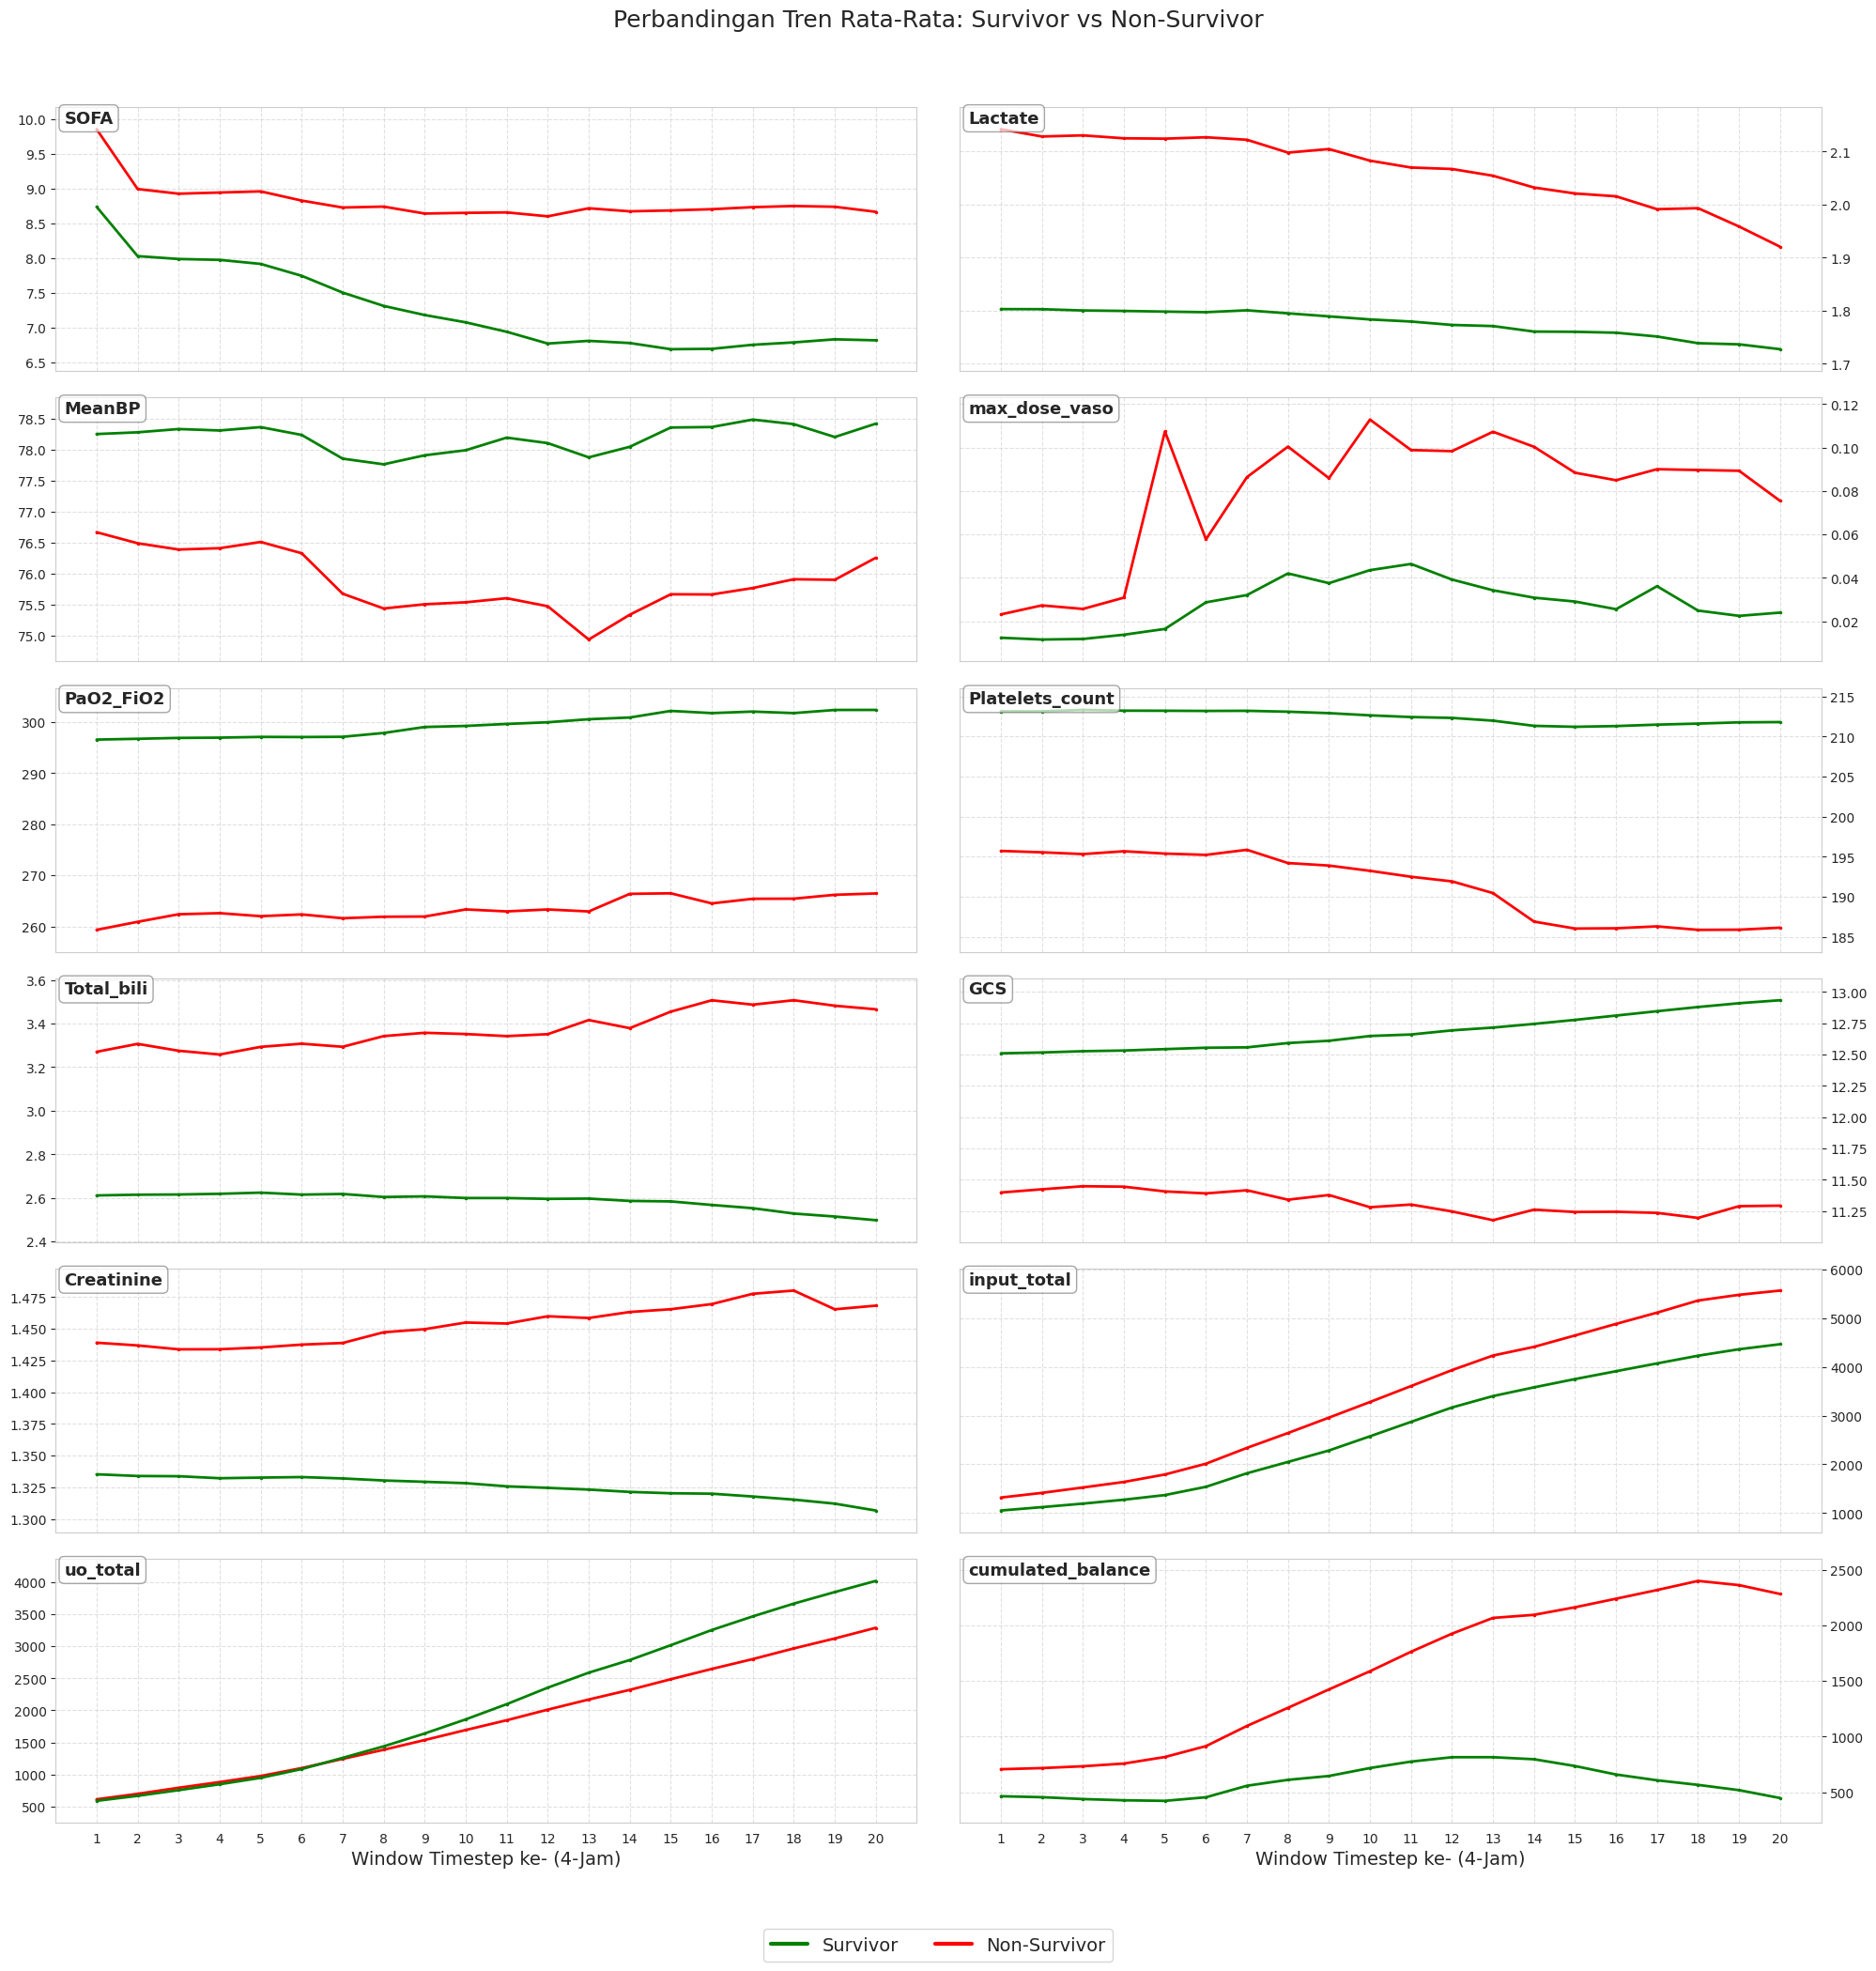

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Ambil data kohort
try:
    final_output_df = pd.read_csv('/content/drive/MyDrive/mimic3/SEPSIS-COHORT-FINAL-DF.csv')
except FileNotFoundError:
    exit()

# 1. Tentukan Kelompok Survivor
survivor_df = final_output_df[final_output_df['morta_hosp'] == 0]
non_survivor_df = final_output_df[final_output_df['morta_hosp'] == 1]

# 2. Daftar Fitur Relevan (SOFA & Hemodinamik/Balance) - Menghapus 'SIRS'
TS_SOFA_FEATURES = [
    'SOFA', 'Lactate', 'MeanBP', 'max_dose_vaso', 'PaO2_FiO2',
    'Platelets_count', 'Total_bili', 'GCS', 'Creatinine',
    'input_total', 'uo_total', 'cumulated_balance' # Total 12 fitur
]

# Seleksi fitur yang benar-benar ada di DataFrame
TS_FEATURES_FINAL = [col for col in TS_SOFA_FEATURES if col in final_output_df.columns]
N_FEATURES = len(TS_FEATURES_FINAL)

# Konfigurasi Subplot: 6 Baris, 2 Kolom
N_ROWS = 6
N_COLS = 2
if N_FEATURES > N_ROWS * N_COLS:
    TS_FEATURES_FINAL = TS_FEATURES_FINAL[:N_ROWS * N_COLS]
N_FEATURES = len(TS_FEATURES_FINAL)

# 3. Hitung Rata-Rata Tren
survivor_mean_ts = survivor_df.groupby('bloc')[TS_FEATURES_FINAL].mean().reset_index()
non_survivor_mean_ts = non_survivor_df.groupby('bloc')[TS_FEATURES_FINAL].mean().reset_index()
max_bloc = final_output_df['bloc'].max()

# --- Pemetaan Warna ---
COLOR_SURVIVOR = 'green'
COLOR_NON_SURVIVOR = 'red'

# =========================================================================
# PLOTTING SCRIPT DENGAN SUMBU Y INDEPENDEN & 2 KOLOM
# =========================================================================

sns.set_style("whitegrid")
# Hapus sharey=True untuk membiarkan setiap subplot menentukan skala Y-nya sendiri
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(20, 3.5 * N_ROWS), sharex=True)
axes = axes.flatten()

fig.suptitle("Perbandingan Tren Rata-Rata: Survivor vs Non-Survivor",
             fontsize=18,
             y=1.0)

# Loop melalui setiap fitur
for i, feature in enumerate(TS_FEATURES_FINAL):
    ax = axes[i]

    # 1. Plot tren Non-Survivor (Merah)
    ax.plot(non_survivor_mean_ts['bloc'], non_survivor_mean_ts[feature],
            color=COLOR_NON_SURVIVOR,
            linewidth=2.0,
            marker='o',
            markersize=1.5,
            label='Non-Survivor Mean')

    # 2. Plot tren Survivor (Hijau)
    ax.plot(survivor_mean_ts['bloc'], survivor_mean_ts[feature],
            color=COLOR_SURVIVOR,
            linewidth=2.0,
            marker='o',
            markersize=1.5,
            label='Survivor Mean')

    # 3. Pengaturan Sumbu Y dan Grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # 4. Penamaan Fitur
    ax.text(0.01, 0.99, feature,
            transform=ax.transAxes,
            fontsize=13,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec="gray"),
            weight='bold')

    # 5. Penentuan Batas Y (Opsional, tapi membantu)
    y_min = min(survivor_mean_ts[feature].min(), non_survivor_mean_ts[feature].min())
    y_max = max(survivor_mean_ts[feature].max(), non_survivor_mean_ts[feature].max())
    y_range = y_max - y_min
    padding = y_range * 0.1
    ax.set_ylim(y_min - padding, y_max + padding)

    # 6. Pengaturan Label Sumbu Y (Kiri dan Kanan)

    # Kolom Kiri (i % N_COLS == 0)
    if i % N_COLS == 0:

        ax.tick_params(axis='y', labelsize=10, right=False) # Pastikan tick di kiri
        ax.yaxis.tick_left()

    # Kolom Kanan (i % N_COLS == 1)
    else:
        # Tampilkan tick marks (angka) dan label di sisi kanan
        ax.tick_params(axis='y', labelsize=10, right=True, labelright=True)
        ax.yaxis.tick_right() # Memastikan tick marks muncul di kanan
        ax.yaxis.set_label_position("right") # Memastikan posisi label di kanan


# 5. Pengaturan Sumbu X (Hanya untuk subplot di baris terakhir)
for i in range(N_COLS):
    ax_bottom = axes[N_ROWS * N_COLS - N_COLS + i]
    ax_bottom.set_xlabel("Window Timestep ke- (4-Jam)", fontsize=14)
    ax_bottom.set_xticks(final_output_df['bloc'].unique())
    ax_bottom.tick_params(axis='x', labelsize=10)

# Perluas sumbu X sedikit
axes[0].set_xlim(final_output_df['bloc'].min() - 1, max_bloc + 1)

# 6. Tambahkan Legend Global di Bawah Figure
handles = [plt.Line2D([0], [0], color=COLOR_SURVIVOR, lw=3),
           plt.Line2D([0], [0], color=COLOR_NON_SURVIVOR, lw=3)]
labels = ['Survivor', 'Non-Survivor']

fig.legend(handles, labels,
           loc='lower center',
           ncol=2,
           fontsize=14,
           bbox_to_anchor=(0.5, 0.005))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.98])
# hspace (jarak vertikal) diperkecil, wspace (jarak horizontal) diperbesar sedikit
fig.subplots_adjust(top=0.95, bottom=0.08, hspace=0.1, wspace=0.05)

plt.show()